In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 44.6 MB/s eta 0:00:00


In [3]:
!pip install torch-fidelity

In [4]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torchmetrics.image.fid import FrechetInceptionDistance
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
from PIL import Image
from tqdm import tqdm
from torchvision.utils import save_image
# local module imports
import config
from utils import save_checkpoint, load_checkpoint, save_some_examples
from UvU_Net_Generator import OuterUNet as Generator
from UvU_Discriminator import Discriminator

torch.backends.cudnn.benchmark = True

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


torch.Size([1, 3, 512, 512])


In [5]:
def compute_gradient_penalty(disc, real_samples, fake_samples, device, lambda_gp):
    # Get random epsilon for interpolation
    batch_size, channels, height, width = real_samples.shape
    epsilon = torch.rand((batch_size, 1, 1, 1), device=device, requires_grad=True)

    # Interpolate between real and fake samples
    interpolated = epsilon * real_samples + (1 - epsilon) * fake_samples
    interpolated = interpolated.to(device)

    # Get the discriminator's prediction on the interpolated samples
    mixed_scores = disc(interpolated, interpolated)  # Pass the interpolated samples twice

    # Calculate gradients of the mixed_scores with respect to interpolated samples
    gradients = torch.autograd.grad(
        inputs=interpolated,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Flatten the gradients
    gradients = gradients.view(gradients.size(0), -1)

    # Compute the gradient norm (L2 norm)
    gradient_norm = gradients.norm(2, dim=1)

    # Compute the gradient penalty as (norm(gradients) - 1)^2
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    # Return the gradient penalty, scaled by lambda_gp
    return gradient_penalty

def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler, L1_LAMBDA=config.L1_LAMBDA, lambda_gp=10
):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(config.DEVICE)
        y = y.to(config.DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            gradient_penalty = compute_gradient_penalty(disc, y, y_fake.detach(), config.DEVICE, lambda_gp)
            D_loss = ((D_real_loss + D_fake_loss) / 2) + (lambda_gp * gradient_penalty)


        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )

In [6]:
!unzip -q Sample_dataset.zip

In [7]:
class PairedImageDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.input_images = sorted(os.listdir(input_dir))
        self.target_images = sorted(os.listdir(target_dir))
        self.transform = transform

        assert len(self.input_images) == len(self.target_images), "Mismatch between input and target images!"

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        input_image_path = os.path.join(self.input_dir, self.input_images[idx])
        target_image_path = os.path.join(self.target_dir, self.target_images[idx])

        input_image = Image.open(input_image_path).convert("RGB")
        target_image = Image.open(target_image_path).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image


input_dir = '/content/Sample_dataset/sobel_images'
target_dir = '/content/Sample_dataset/input_images'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = PairedImageDataset(input_dir=input_dir, target_dir=target_dir, transform=transform)

# Split dataset into training and validation (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader for training and validation
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Example to iterate over the data loader
for batch_idx, (input_images, target_images) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}")
    print(f"Input batch size: {input_images.shape}")
    print(f"Target batch size: {target_images.shape}")


Batch 1
Input batch size: torch.Size([16, 3, 256, 256])
Target batch size: torch.Size([16, 3, 256, 256])
Batch 2
Input batch size: torch.Size([4, 3, 256, 256])
Target batch size: torch.Size([4, 3, 256, 256])


<ipython-input-8-cdde3062e277>:230: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  g_scaler = torch.cuda.amp.GradScaler()
<ipython-input-8-cdde3062e277>:231: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  d_scaler = torch.cuda.amp.GradScaler()
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 38.1MB/s]
  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please 

y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 498.8802490234375
PSNR: 5.7803
Epoch 0 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 498.8802, PSNR: 5.7803


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.10it/s, D_fake=0.49, D_real=0.487]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 498.8783874511719
PSNR: 5.7803
Epoch 1 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 498.8784, PSNR: 5.7803


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.99it/s, D_fake=0.518, D_real=0.487]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 1.0000, TPR: 1.0000, FPR: 0.0000, TNR: 1.0000, FNR: 0.0000
Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
FID: 506.1965026855469
PSNR: 5.8546
Epoch 2 - Metrics: Accuracy: 1.0000, TPR: 1.0000, FPR: 0.0000, FID: 506.1965, PSNR: 5.8546


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.29it/s, D_fake=0.501, D_real=0.52]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1532, TPR: 0.0558, FPR: 0.7493, TNR: 0.2507, FNR: 0.9442
Precision: 0.0693, Recall: 0.0558, F1 Score: 0.0618
FID: 555.3163452148438
PSNR: 6.0597
Epoch 3 - Metrics: Accuracy: 0.1532, TPR: 0.0558, FPR: 0.7493, FID: 555.3163, PSNR: 6.0597


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.09it/s, D_fake=0.497, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0248, TPR: 0.0278, FPR: 0.9782, TNR: 0.0218, FNR: 0.9722
Precision: 0.0276, Recall: 0.0278, F1 Score: 0.0277
FID: 579.37060546875
PSNR: 6.3283
Epoch 4 - Metrics: Accuracy: 0.0248, TPR: 0.0278, FPR: 0.9782, FID: 579.3706, PSNR: 6.3283


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.24it/s, D_fake=0.5, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0042, TPR: 0.0062, FPR: 0.9978, TNR: 0.0022, FNR: 0.9938
Precision: 0.0062, Recall: 0.0062, F1 Score: 0.0062
FID: 589.7767333984375
PSNR: 6.6579
Epoch 5 - Metrics: Accuracy: 0.0042, TPR: 0.0062, FPR: 0.9978, FID: 589.7767, PSNR: 6.6579


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.12it/s, D_fake=0.493, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0006, TPR: 0.0011, FPR: 1.0000, TNR: 0.0000, FNR: 0.9989
Precision: 0.0011, Recall: 0.0011, F1 Score: 0.0011
FID: 510.6668395996094
PSNR: 7.2508
Epoch 6 - Metrics: Accuracy: 0.0006, TPR: 0.0011, FPR: 1.0000, FID: 510.6668, PSNR: 7.2508


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.02it/s, D_fake=0.493, D_real=0.494]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0018, TPR: 0.0036, FPR: 1.0000, TNR: 0.0000, FNR: 0.9964
Precision: 0.0035, Recall: 0.0036, F1 Score: 0.0035
FID: 525.648681640625
PSNR: 8.0813
Epoch 7 - Metrics: Accuracy: 0.0018, TPR: 0.0036, FPR: 1.0000, FID: 525.6487, PSNR: 8.0813


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.36it/s, D_fake=0.493, D_real=0.495]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0062, TPR: 0.0124, FPR: 1.0000, TNR: 0.0000, FNR: 0.9876
Precision: 0.0123, Recall: 0.0124, F1 Score: 0.0124
FID: 418.6154479980469
PSNR: 8.4568
Epoch 8 - Metrics: Accuracy: 0.0062, TPR: 0.0124, FPR: 1.0000, FID: 418.6154, PSNR: 8.4568


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, D_fake=0.494, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0158, TPR: 0.0313, FPR: 0.9998, TNR: 0.0002, FNR: 0.9687
Precision: 0.0304, Recall: 0.0313, F1 Score: 0.0309
FID: 458.5057373046875
PSNR: 8.5766
Epoch 9 - Metrics: Accuracy: 0.0158, TPR: 0.0313, FPR: 0.9998, FID: 458.5057, PSNR: 8.5766


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.17it/s, D_fake=0.494, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0234, TPR: 0.0467, FPR: 0.9998, TNR: 0.0002, FNR: 0.9533
Precision: 0.0446, Recall: 0.0467, F1 Score: 0.0456
FID: 484.4563903808594
PSNR: 8.9195
Epoch 10 - Metrics: Accuracy: 0.0234, TPR: 0.0467, FPR: 0.9998, FID: 484.4564, PSNR: 8.9195


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.82it/s, D_fake=0.494, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0304, TPR: 0.0607, FPR: 0.9998, TNR: 0.0002, FNR: 0.9393
Precision: 0.0572, Recall: 0.0607, F1 Score: 0.0589
FID: 489.120849609375
PSNR: 9.3240
Epoch 11 - Metrics: Accuracy: 0.0304, TPR: 0.0607, FPR: 0.9998, FID: 489.1208, PSNR: 9.3240


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.05it/s, D_fake=0.495, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0383, TPR: 0.0764, FPR: 0.9998, TNR: 0.0002, FNR: 0.9236
Precision: 0.0710, Recall: 0.0764, F1 Score: 0.0736
FID: 462.5865783691406
PSNR: 9.8838
Epoch 12 - Metrics: Accuracy: 0.0383, TPR: 0.0764, FPR: 0.9998, FID: 462.5866, PSNR: 9.8838


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.08it/s, D_fake=0.495, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0546, TPR: 0.1087, FPR: 0.9996, TNR: 0.0004, FNR: 0.8913
Precision: 0.0981, Recall: 0.1087, F1 Score: 0.1031
FID: 437.94744873046875
PSNR: 9.7336
Epoch 13 - Metrics: Accuracy: 0.0546, TPR: 0.1087, FPR: 0.9996, FID: 437.9474, PSNR: 9.7336


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.06it/s, D_fake=0.495, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0132, TPR: 0.0262, FPR: 0.9998, TNR: 0.0002, FNR: 0.9738
Precision: 0.0256, Recall: 0.0262, F1 Score: 0.0259
FID: 440.2208251953125
PSNR: 10.1395
Epoch 14 - Metrics: Accuracy: 0.0132, TPR: 0.0262, FPR: 0.9998, FID: 440.2208, PSNR: 10.1395


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.04it/s, D_fake=0.495, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0317, TPR: 0.0593, FPR: 0.9960, TNR: 0.0040, FNR: 0.9407
Precision: 0.0562, Recall: 0.0593, F1 Score: 0.0577
FID: 448.105224609375
PSNR: 10.2662
Epoch 15 - Metrics: Accuracy: 0.0317, TPR: 0.0593, FPR: 0.9960, FID: 448.1052, PSNR: 10.2662


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.95it/s, D_fake=0.496, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0417, TPR: 0.0813, FPR: 0.9980, TNR: 0.0020, FNR: 0.9187
Precision: 0.0754, Recall: 0.0813, F1 Score: 0.0782
FID: 479.91693115234375
PSNR: 9.9761
Epoch 16 - Metrics: Accuracy: 0.0417, TPR: 0.0813, FPR: 0.9980, FID: 479.9169, PSNR: 9.9761


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.495, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0509, TPR: 0.0993, FPR: 0.9976, TNR: 0.0024, FNR: 0.9007
Precision: 0.0906, Recall: 0.0993, F1 Score: 0.0947
FID: 475.465087890625
PSNR: 10.1486
Epoch 17 - Metrics: Accuracy: 0.0509, TPR: 0.0993, FPR: 0.9976, FID: 475.4651, PSNR: 10.1486


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.82it/s, D_fake=0.495, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0644, TPR: 0.1256, FPR: 0.9967, TNR: 0.0033, FNR: 0.8744
Precision: 0.1119, Recall: 0.1256, F1 Score: 0.1183
FID: 442.8349609375
PSNR: 10.5877
Epoch 18 - Metrics: Accuracy: 0.0644, TPR: 0.1256, FPR: 0.9967, FID: 442.8350, PSNR: 10.5877


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.96it/s, D_fake=0.496, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0666, TPR: 0.1302, FPR: 0.9971, TNR: 0.0029, FNR: 0.8698
Precision: 0.1155, Recall: 0.1302, F1 Score: 0.1224
FID: 457.3155517578125
PSNR: 10.5249
Epoch 19 - Metrics: Accuracy: 0.0666, TPR: 0.1302, FPR: 0.9971, FID: 457.3156, PSNR: 10.5249


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.31it/s, D_fake=0.496, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0731, TPR: 0.1433, FPR: 0.9971, TNR: 0.0029, FNR: 0.8567
Precision: 0.1257, Recall: 0.1433, F1 Score: 0.1339
FID: 467.30584716796875
PSNR: 10.4221
Epoch 20 - Metrics: Accuracy: 0.0731, TPR: 0.1433, FPR: 0.9971, FID: 467.3058, PSNR: 10.4221


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.25it/s, D_fake=0.496, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0804, TPR: 0.1569, FPR: 0.9960, TNR: 0.0040, FNR: 0.8431
Precision: 0.1361, Recall: 0.1569, F1 Score: 0.1457
FID: 448.4615478515625
PSNR: 10.7359
Epoch 21 - Metrics: Accuracy: 0.0804, TPR: 0.1569, FPR: 0.9960, FID: 448.4615, PSNR: 10.7359


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.00it/s, D_fake=0.496, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0916, TPR: 0.1729, FPR: 0.9898, TNR: 0.0102, FNR: 0.8271
Precision: 0.1487, Recall: 0.1729, F1 Score: 0.1599
FID: 450.6082763671875
PSNR: 10.8007
Epoch 22 - Metrics: Accuracy: 0.0916, TPR: 0.1729, FPR: 0.9898, FID: 450.6083, PSNR: 10.8007


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.12it/s, D_fake=0.496, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1050, TPR: 0.2049, FPR: 0.9949, TNR: 0.0051, FNR: 0.7951
Precision: 0.1708, Recall: 0.2049, F1 Score: 0.1863
FID: 483.8689270019531
PSNR: 10.1348
Epoch 23 - Metrics: Accuracy: 0.1050, TPR: 0.2049, FPR: 0.9949, FID: 483.8689, PSNR: 10.1348


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.97it/s, D_fake=0.496, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1321, TPR: 0.2542, FPR: 0.9900, TNR: 0.0100, FNR: 0.7458
Precision: 0.2043, Recall: 0.2542, F1 Score: 0.2266
FID: 479.8719482421875
PSNR: 10.1532
Epoch 24 - Metrics: Accuracy: 0.1321, TPR: 0.2542, FPR: 0.9900, FID: 479.8719, PSNR: 10.1532


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.496, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1513, TPR: 0.2856, FPR: 0.9829, TNR: 0.0171, FNR: 0.7144
Precision: 0.2251, Recall: 0.2856, F1 Score: 0.2518
FID: 450.6203308105469
PSNR: 10.6241
Epoch 25 - Metrics: Accuracy: 0.1513, TPR: 0.2856, FPR: 0.9829, FID: 450.6203, PSNR: 10.6241


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.09it/s, D_fake=0.496, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2122, TPR: 0.3738, FPR: 0.9493, TNR: 0.0507, FNR: 0.6262
Precision: 0.2825, Recall: 0.3738, F1 Score: 0.3218
FID: 451.3912048339844
PSNR: 10.7904
Epoch 26 - Metrics: Accuracy: 0.2122, TPR: 0.3738, FPR: 0.9493, FID: 451.3912, PSNR: 10.7904


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.498, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2008, TPR: 0.3687, FPR: 0.9671, TNR: 0.0329, FNR: 0.6313
Precision: 0.2760, Recall: 0.3687, F1 Score: 0.3157
FID: 457.06439208984375
PSNR: 10.7783
Epoch 27 - Metrics: Accuracy: 0.2008, TPR: 0.3687, FPR: 0.9671, FID: 457.0644, PSNR: 10.7783


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.13it/s, D_fake=0.497, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1932, TPR: 0.3562, FPR: 0.9698, TNR: 0.0302, FNR: 0.6438
Precision: 0.2686, Recall: 0.3562, F1 Score: 0.3063
FID: 436.93109130859375
PSNR: 10.7932
Epoch 28 - Metrics: Accuracy: 0.1932, TPR: 0.3562, FPR: 0.9698, FID: 436.9311, PSNR: 10.7932


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.498, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2011, TPR: 0.3742, FPR: 0.9720, TNR: 0.0280, FNR: 0.6258
Precision: 0.2780, Recall: 0.3742, F1 Score: 0.3190
FID: 444.24212646484375
PSNR: 10.8270
Epoch 29 - Metrics: Accuracy: 0.2011, TPR: 0.3742, FPR: 0.9720, FID: 444.2421, PSNR: 10.8270


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.08it/s, D_fake=0.497, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2029, TPR: 0.3833, FPR: 0.9776, TNR: 0.0224, FNR: 0.6167
Precision: 0.2817, Recall: 0.3833, F1 Score: 0.3247
FID: 460.4252624511719
PSNR: 10.7788
Epoch 30 - Metrics: Accuracy: 0.2029, TPR: 0.3833, FPR: 0.9776, FID: 460.4253, PSNR: 10.7788


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.14it/s, D_fake=0.497, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2118, TPR: 0.3887, FPR: 0.9651, TNR: 0.0349, FNR: 0.6113
Precision: 0.2871, Recall: 0.3887, F1 Score: 0.3302
FID: 457.6473083496094
PSNR: 10.8536
Epoch 31 - Metrics: Accuracy: 0.2118, TPR: 0.3887, FPR: 0.9651, FID: 457.6473, PSNR: 10.8536


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.93it/s, D_fake=0.497, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2346, TPR: 0.4336, FPR: 0.9644, TNR: 0.0356, FNR: 0.5664
Precision: 0.3101, Recall: 0.4336, F1 Score: 0.3616
FID: 459.49798583984375
PSNR: 10.8987
Epoch 32 - Metrics: Accuracy: 0.2346, TPR: 0.4336, FPR: 0.9644, FID: 459.4980, PSNR: 10.8987


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.498, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2310, TPR: 0.4291, FPR: 0.9671, TNR: 0.0329, FNR: 0.5709
Precision: 0.3073, Recall: 0.4291, F1 Score: 0.3582
FID: 445.1298828125
PSNR: 10.9194
Epoch 33 - Metrics: Accuracy: 0.2310, TPR: 0.4291, FPR: 0.9671, FID: 445.1299, PSNR: 10.9194


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.04it/s, D_fake=0.497, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2191, TPR: 0.4164, FPR: 0.9782, TNR: 0.0218, FNR: 0.5836
Precision: 0.2986, Recall: 0.4164, F1 Score: 0.3478
FID: 460.47113037109375
PSNR: 10.8125
Epoch 34 - Metrics: Accuracy: 0.2191, TPR: 0.4164, FPR: 0.9782, FID: 460.4711, PSNR: 10.8125


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.04it/s, D_fake=0.497, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2233, TPR: 0.4233, FPR: 0.9767, TNR: 0.0233, FNR: 0.5767
Precision: 0.3024, Recall: 0.4233, F1 Score: 0.3528
FID: 442.0703430175781
PSNR: 10.8738
Epoch 35 - Metrics: Accuracy: 0.2233, TPR: 0.4233, FPR: 0.9767, FID: 442.0703, PSNR: 10.8738


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.69it/s, D_fake=0.497, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2508, TPR: 0.4549, FPR: 0.9533, TNR: 0.0467, FNR: 0.5451
Precision: 0.3230, Recall: 0.4549, F1 Score: 0.3778
FID: 463.9671325683594
PSNR: 10.6068
Epoch 36 - Metrics: Accuracy: 0.2508, TPR: 0.4549, FPR: 0.9533, FID: 463.9671, PSNR: 10.6068


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.92it/s, D_fake=0.498, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2551, TPR: 0.4782, FPR: 0.9680, TNR: 0.0320, FNR: 0.5218
Precision: 0.3307, Recall: 0.4782, F1 Score: 0.3910
FID: 443.4765930175781
PSNR: 10.8339
Epoch 37 - Metrics: Accuracy: 0.2551, TPR: 0.4782, FPR: 0.9680, FID: 443.4766, PSNR: 10.8339


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.497, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2557, TPR: 0.4787, FPR: 0.9673, TNR: 0.0327, FNR: 0.5213
Precision: 0.3310, Recall: 0.4787, F1 Score: 0.3914
FID: 435.5806884765625
PSNR: 10.7653
Epoch 38 - Metrics: Accuracy: 0.2557, TPR: 0.4787, FPR: 0.9673, FID: 435.5807, PSNR: 10.7653


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.97it/s, D_fake=0.497, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2616, TPR: 0.4927, FPR: 0.9696, TNR: 0.0304, FNR: 0.5073
Precision: 0.3369, Recall: 0.4927, F1 Score: 0.4002
FID: 438.53692626953125
PSNR: 10.8179
Epoch 39 - Metrics: Accuracy: 0.2616, TPR: 0.4927, FPR: 0.9696, FID: 438.5369, PSNR: 10.8179


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.94it/s, D_fake=0.497, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2782, TPR: 0.5233, FPR: 0.9669, TNR: 0.0331, FNR: 0.4767
Precision: 0.3512, Recall: 0.5233, F1 Score: 0.4203
FID: 439.03436279296875
PSNR: 10.9100
Epoch 40 - Metrics: Accuracy: 0.2782, TPR: 0.5233, FPR: 0.9669, FID: 439.0344, PSNR: 10.9100


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.94it/s, D_fake=0.497, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2890, TPR: 0.5433, FPR: 0.9653, TNR: 0.0347, FNR: 0.4567
Precision: 0.3601, Recall: 0.5433, F1 Score: 0.4332
FID: 437.73907470703125
PSNR: 10.8956
Epoch 41 - Metrics: Accuracy: 0.2890, TPR: 0.5433, FPR: 0.9653, FID: 437.7391, PSNR: 10.8956


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.17it/s, D_fake=0.497, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2934, TPR: 0.5536, FPR: 0.9667, TNR: 0.0333, FNR: 0.4464
Precision: 0.3641, Recall: 0.5536, F1 Score: 0.4393
FID: 452.2370300292969
PSNR: 10.7468
Epoch 42 - Metrics: Accuracy: 0.2934, TPR: 0.5536, FPR: 0.9667, FID: 452.2370, PSNR: 10.7468


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.89it/s, D_fake=0.497, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2918, TPR: 0.5547, FPR: 0.9711, TNR: 0.0289, FNR: 0.4453
Precision: 0.3635, Recall: 0.5547, F1 Score: 0.4392
FID: 446.05328369140625
PSNR: 10.8469
Epoch 43 - Metrics: Accuracy: 0.2918, TPR: 0.5547, FPR: 0.9711, FID: 446.0533, PSNR: 10.8469


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.95it/s, D_fake=0.497, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3034, TPR: 0.5707, FPR: 0.9638, TNR: 0.0362, FNR: 0.4293
Precision: 0.3719, Recall: 0.5707, F1 Score: 0.4503
FID: 444.322509765625
PSNR: 10.8746
Epoch 44 - Metrics: Accuracy: 0.3034, TPR: 0.5707, FPR: 0.9638, FID: 444.3225, PSNR: 10.8746


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.15it/s, D_fake=0.497, D_real=0.502]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3247, TPR: 0.6080, FPR: 0.9587, TNR: 0.0413, FNR: 0.3920
Precision: 0.3881, Recall: 0.6080, F1 Score: 0.4738
FID: 447.68316650390625
PSNR: 10.8729
Epoch 45 - Metrics: Accuracy: 0.3247, TPR: 0.6080, FPR: 0.9587, FID: 447.6832, PSNR: 10.8729


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.497, D_real=0.502]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3324, TPR: 0.6127, FPR: 0.9478, TNR: 0.0522, FNR: 0.3873
Precision: 0.3926, Recall: 0.6127, F1 Score: 0.4786
FID: 452.2028503417969
PSNR: 10.7103
Epoch 46 - Metrics: Accuracy: 0.3324, TPR: 0.6127, FPR: 0.9478, FID: 452.2029, PSNR: 10.7103


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, D_fake=0.497, D_real=0.502]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3150, TPR: 0.5902, FPR: 0.9602, TNR: 0.0398, FNR: 0.4098
Precision: 0.3807, Recall: 0.5902, F1 Score: 0.4628
FID: 448.119384765625
PSNR: 10.6605
Epoch 47 - Metrics: Accuracy: 0.3150, TPR: 0.5902, FPR: 0.9602, FID: 448.1194, PSNR: 10.6605


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.09it/s, D_fake=0.497, D_real=0.502]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3026, TPR: 0.5787, FPR: 0.9736, TNR: 0.0264, FNR: 0.4213
Precision: 0.3728, Recall: 0.5787, F1 Score: 0.4535
FID: 450.1401672363281
PSNR: 10.7510
Epoch 48 - Metrics: Accuracy: 0.3026, TPR: 0.5787, FPR: 0.9736, FID: 450.1402, PSNR: 10.7510


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.59it/s, D_fake=0.497, D_real=0.502]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2978, TPR: 0.5744, FPR: 0.9789, TNR: 0.0211, FNR: 0.4256
Precision: 0.3698, Recall: 0.5744, F1 Score: 0.4500
FID: 446.0434875488281
PSNR: 10.8547
Epoch 49 - Metrics: Accuracy: 0.2978, TPR: 0.5744, FPR: 0.9789, FID: 446.0435, PSNR: 10.8547
Saving model at epoch 49


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.77it/s, D_fake=0.506, D_real=0.503]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2482, TPR: 0.4689, FPR: 0.9724, TNR: 0.0276, FNR: 0.5311
Precision: 0.3253, Recall: 0.4689, F1 Score: 0.3841
FID: 460.9079284667969
PSNR: 9.3320
Epoch 50 - Metrics: Accuracy: 0.2482, TPR: 0.4689, FPR: 0.9724, FID: 460.9079, PSNR: 9.3320


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.00it/s, D_fake=0.499, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.7384, TPR: 0.7198, FPR: 0.2429, TNR: 0.7571, FNR: 0.2802
Precision: 0.7477, Recall: 0.7198, F1 Score: 0.7335
FID: 491.3392333984375
PSNR: 9.3551
Epoch 51 - Metrics: Accuracy: 0.7384, TPR: 0.7198, FPR: 0.2429, FID: 491.3392, PSNR: 9.3551


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.02it/s, D_fake=0.504, D_real=0.503]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 1.0000, TPR: 1.0000, FPR: 0.0000, TNR: 1.0000, FNR: 0.0000
Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
FID: 514.1915283203125
PSNR: 7.4815
Epoch 52 - Metrics: Accuracy: 1.0000, TPR: 1.0000, FPR: 0.0000, FID: 514.1915, PSNR: 7.4815


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.73it/s, D_fake=0.501, D_real=0.511]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0003, TPR: 0.0007, FPR: 1.0000, TNR: 0.0000, FNR: 0.9993
Precision: 0.0007, Recall: 0.0007, F1 Score: 0.0007
FID: 480.3323974609375
PSNR: 9.5560
Epoch 53 - Metrics: Accuracy: 0.0003, TPR: 0.0007, FPR: 1.0000, FID: 480.3324, PSNR: 9.5560


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.99it/s, D_fake=0.501, D_real=0.494]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4312, TPR: 0.5587, FPR: 0.6962, TNR: 0.3038, FNR: 0.4413
Precision: 0.4452, Recall: 0.5587, F1 Score: 0.4955
FID: 426.44140625
PSNR: 10.8998
Epoch 54 - Metrics: Accuracy: 0.4312, TPR: 0.5587, FPR: 0.6962, FID: 426.4414, PSNR: 10.8998


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.93it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2973, TPR: 0.5049, FPR: 0.9102, TNR: 0.0898, FNR: 0.4951
Precision: 0.3568, Recall: 0.5049, F1 Score: 0.4181
FID: 447.7303771972656
PSNR: 8.7668
Epoch 55 - Metrics: Accuracy: 0.2973, TPR: 0.5049, FPR: 0.9102, FID: 447.7304, PSNR: 8.7668


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.05it/s, D_fake=0.497, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 440.1265563964844
PSNR: 9.6428
Epoch 56 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 440.1266, PSNR: 9.6428


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.48, D_real=0.483]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 445.26788330078125
PSNR: 9.2717
Epoch 57 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 445.2679, PSNR: 9.2717


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.95it/s, D_fake=0.477, D_real=0.486]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0172, TPR: 0.0344, FPR: 1.0000, TNR: 0.0000, FNR: 0.9656
Precision: 0.0333, Recall: 0.0344, F1 Score: 0.0339
FID: 429.7370300292969
PSNR: 9.8497
Epoch 58 - Metrics: Accuracy: 0.0172, TPR: 0.0344, FPR: 1.0000, FID: 429.7370, PSNR: 9.8497


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.89it/s, D_fake=0.509, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.8728, TPR: 0.7527, FPR: 0.0071, TNR: 0.9929, FNR: 0.2473
Precision: 0.9906, Recall: 0.7527, F1 Score: 0.8554
FID: 427.2628479003906
PSNR: 10.5246
Epoch 59 - Metrics: Accuracy: 0.8728, TPR: 0.7527, FPR: 0.0071, FID: 427.2628, PSNR: 10.5246


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.87it/s, D_fake=0.491, D_real=0.506]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 453.5260009765625
PSNR: 10.9181
Epoch 60 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 453.5260, PSNR: 10.9181


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.88it/s, D_fake=0.515, D_real=0.488]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 1.0000, TPR: 1.0000, FPR: 0.0000, TNR: 1.0000, FNR: 0.0000
Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
FID: 426.81597900390625
PSNR: 10.7551
Epoch 61 - Metrics: Accuracy: 1.0000, TPR: 1.0000, FPR: 0.0000, FID: 426.8160, PSNR: 10.7551


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.12it/s, D_fake=0.517, D_real=0.514]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 1.0000, TPR: 1.0000, FPR: 0.0000, TNR: 1.0000, FNR: 0.0000
Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
FID: 417.0829162597656
PSNR: 10.7824
Epoch 62 - Metrics: Accuracy: 1.0000, TPR: 1.0000, FPR: 0.0000, FID: 417.0829, PSNR: 10.7824


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.03it/s, D_fake=0.503, D_real=0.521]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0133, TPR: 0.0204, FPR: 0.9938, TNR: 0.0062, FNR: 0.9796
Precision: 0.0202, Recall: 0.0204, F1 Score: 0.0203
FID: 421.0003662109375
PSNR: 10.9566
Epoch 63 - Metrics: Accuracy: 0.0133, TPR: 0.0204, FPR: 0.9938, FID: 421.0004, PSNR: 10.9566


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, D_fake=0.489, D_real=0.495]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 419.1674499511719
PSNR: 10.9188
Epoch 64 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 419.1674, PSNR: 10.9188


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.08it/s, D_fake=0.483, D_real=0.482]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 409.33258056640625
PSNR: 10.7153
Epoch 65 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 409.3326, PSNR: 10.7153


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.80it/s, D_fake=0.482, D_real=0.483]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 410.2309875488281
PSNR: 10.4770
Epoch 66 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 410.2310, PSNR: 10.4770


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.11it/s, D_fake=0.483, D_real=0.483]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 412.8854675292969
PSNR: 10.7243
Epoch 67 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 412.8855, PSNR: 10.7243


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.83it/s, D_fake=0.483, D_real=0.483]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 418.8353271484375
PSNR: 10.9234
Epoch 68 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 418.8353, PSNR: 10.9234


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.02it/s, D_fake=0.485, D_real=0.484]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 415.5351867675781
PSNR: 10.9810
Epoch 69 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 415.5352, PSNR: 10.9810


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.92it/s, D_fake=0.484, D_real=0.485]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 408.95587158203125
PSNR: 10.9271
Epoch 70 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 408.9559, PSNR: 10.9271


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.80it/s, D_fake=0.485, D_real=0.485]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 412.7139892578125
PSNR: 10.9964
Epoch 71 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 412.7140, PSNR: 10.9964


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.88it/s, D_fake=0.486, D_real=0.486]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 411.2581787109375
PSNR: 11.0109
Epoch 72 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 411.2582, PSNR: 11.0109


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.83it/s, D_fake=0.486, D_real=0.486]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 410.0514831542969
PSNR: 11.0034
Epoch 73 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 410.0515, PSNR: 11.0034


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.486, D_real=0.487]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 410.8957824707031
PSNR: 10.9220
Epoch 74 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 410.8958, PSNR: 10.9220


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.65it/s, D_fake=0.487, D_real=0.487]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 413.6103210449219
PSNR: 10.8354
Epoch 75 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 413.6103, PSNR: 10.8354


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.02it/s, D_fake=0.487, D_real=0.488]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 419.9147644042969
PSNR: 10.8565
Epoch 76 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 419.9148, PSNR: 10.8565


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.487, D_real=0.489]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 425.23907470703125
PSNR: 10.9760
Epoch 77 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 425.2391, PSNR: 10.9760


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.09it/s, D_fake=0.488, D_real=0.489]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 434.9873046875
PSNR: 10.8478
Epoch 78 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 434.9873, PSNR: 10.8478


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.00it/s, D_fake=0.489, D_real=0.489]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 398.08624267578125
PSNR: 11.0119
Epoch 79 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 398.0862, PSNR: 11.0119


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.87it/s, D_fake=0.488, D_real=0.49]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 405.5173645019531
PSNR: 10.9768
Epoch 80 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 405.5174, PSNR: 10.9768


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.96it/s, D_fake=0.489, D_real=0.49]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 408.9543762207031
PSNR: 11.0246
Epoch 81 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 408.9544, PSNR: 11.0246


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.89it/s, D_fake=0.489, D_real=0.49]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0073, TPR: 0.0000, FPR: 0.9853, TNR: 0.0147, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 583.4303588867188
PSNR: 8.6211
Epoch 82 - Metrics: Accuracy: 0.0073, TPR: 0.0000, FPR: 0.9853, FID: 583.4304, PSNR: 8.6211


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.82it/s, D_fake=0.491, D_real=0.491]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 417.97589111328125
PSNR: 9.9175
Epoch 83 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 417.9759, PSNR: 9.9175


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, D_fake=0.49, D_real=0.491]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, TNR: 0.0000, FNR: 1.0000
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
FID: 403.5658264160156
PSNR: 10.2072
Epoch 84 - Metrics: Accuracy: 0.0000, TPR: 0.0000, FPR: 1.0000, FID: 403.5658, PSNR: 10.2072


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.93it/s, D_fake=0.49, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0001, TPR: 0.0002, FPR: 1.0000, TNR: 0.0000, FNR: 0.9998
Precision: 0.0002, Recall: 0.0002, F1 Score: 0.0002
FID: 401.9761047363281
PSNR: 10.8042
Epoch 85 - Metrics: Accuracy: 0.0001, TPR: 0.0002, FPR: 1.0000, FID: 401.9761, PSNR: 10.8042


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.49, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0002, TPR: 0.0004, FPR: 1.0000, TNR: 0.0000, FNR: 0.9996
Precision: 0.0004, Recall: 0.0004, F1 Score: 0.0004
FID: 403.79071044921875
PSNR: 10.9482
Epoch 86 - Metrics: Accuracy: 0.0002, TPR: 0.0004, FPR: 1.0000, FID: 403.7907, PSNR: 10.9482


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.49, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0002, TPR: 0.0004, FPR: 1.0000, TNR: 0.0000, FNR: 0.9996
Precision: 0.0004, Recall: 0.0004, F1 Score: 0.0004
FID: 405.7765808105469
PSNR: 10.9547
Epoch 87 - Metrics: Accuracy: 0.0002, TPR: 0.0004, FPR: 1.0000, FID: 405.7766, PSNR: 10.9547


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.09it/s, D_fake=0.49, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0003, TPR: 0.0007, FPR: 1.0000, TNR: 0.0000, FNR: 0.9993
Precision: 0.0007, Recall: 0.0007, F1 Score: 0.0007
FID: 406.8905944824219
PSNR: 10.8713
Epoch 88 - Metrics: Accuracy: 0.0003, TPR: 0.0007, FPR: 1.0000, FID: 406.8906, PSNR: 10.8713


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.90it/s, D_fake=0.49, D_real=0.493]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0003, TPR: 0.0007, FPR: 1.0000, TNR: 0.0000, FNR: 0.9993
Precision: 0.0007, Recall: 0.0007, F1 Score: 0.0007
FID: 409.07269287109375
PSNR: 10.8919
Epoch 89 - Metrics: Accuracy: 0.0003, TPR: 0.0007, FPR: 1.0000, FID: 409.0727, PSNR: 10.8919


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.491, D_real=0.493]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0006, TPR: 0.0011, FPR: 1.0000, TNR: 0.0000, FNR: 0.9989
Precision: 0.0011, Recall: 0.0011, F1 Score: 0.0011
FID: 416.9643859863281
PSNR: 10.9360
Epoch 90 - Metrics: Accuracy: 0.0006, TPR: 0.0011, FPR: 1.0000, FID: 416.9644, PSNR: 10.9360


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.80it/s, D_fake=0.491, D_real=0.493]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0013, TPR: 0.0027, FPR: 1.0000, TNR: 0.0000, FNR: 0.9973
Precision: 0.0027, Recall: 0.0027, F1 Score: 0.0027
FID: 421.62213134765625
PSNR: 11.0020
Epoch 91 - Metrics: Accuracy: 0.0013, TPR: 0.0027, FPR: 1.0000, FID: 421.6221, PSNR: 11.0020


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.83it/s, D_fake=0.491, D_real=0.494]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0019, TPR: 0.0038, FPR: 1.0000, TNR: 0.0000, FNR: 0.9962
Precision: 0.0038, Recall: 0.0038, F1 Score: 0.0038
FID: 420.4042663574219
PSNR: 11.0826
Epoch 92 - Metrics: Accuracy: 0.0019, TPR: 0.0038, FPR: 1.0000, FID: 420.4043, PSNR: 11.0826


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.77it/s, D_fake=0.491, D_real=0.494]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0022, TPR: 0.0044, FPR: 1.0000, TNR: 0.0000, FNR: 0.9956
Precision: 0.0044, Recall: 0.0044, F1 Score: 0.0044
FID: 458.1903076171875
PSNR: 11.1790
Epoch 93 - Metrics: Accuracy: 0.0022, TPR: 0.0044, FPR: 1.0000, FID: 458.1903, PSNR: 11.1790


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.06it/s, D_fake=0.492, D_real=0.494]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0031, TPR: 0.0058, FPR: 0.9996, TNR: 0.0004, FNR: 0.9942
Precision: 0.0057, Recall: 0.0058, F1 Score: 0.0058
FID: 507.91497802734375
PSNR: 11.0413
Epoch 94 - Metrics: Accuracy: 0.0031, TPR: 0.0058, FPR: 0.9996, FID: 507.9150, PSNR: 11.0413


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.07it/s, D_fake=0.492, D_real=0.495]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0036, TPR: 0.0071, FPR: 1.0000, TNR: 0.0000, FNR: 0.9929
Precision: 0.0071, Recall: 0.0071, F1 Score: 0.0071
FID: 426.1066589355469
PSNR: 10.8090
Epoch 95 - Metrics: Accuracy: 0.0036, TPR: 0.0071, FPR: 1.0000, FID: 426.1067, PSNR: 10.8090


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.95it/s, D_fake=0.492, D_real=0.495]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0046, TPR: 0.0089, FPR: 0.9998, TNR: 0.0002, FNR: 0.9911
Precision: 0.0088, Recall: 0.0089, F1 Score: 0.0089
FID: 434.55499267578125
PSNR: 11.2190
Epoch 96 - Metrics: Accuracy: 0.0046, TPR: 0.0089, FPR: 0.9998, FID: 434.5550, PSNR: 11.2190


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.11it/s, D_fake=0.492, D_real=0.495]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0053, TPR: 0.0104, FPR: 0.9998, TNR: 0.0002, FNR: 0.9896
Precision: 0.0103, Recall: 0.0104, F1 Score: 0.0104
FID: 506.8645935058594
PSNR: 10.6958
Epoch 97 - Metrics: Accuracy: 0.0053, TPR: 0.0104, FPR: 0.9998, FID: 506.8646, PSNR: 10.6958


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.11it/s, D_fake=0.493, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0080, TPR: 0.0156, FPR: 0.9996, TNR: 0.0004, FNR: 0.9844
Precision: 0.0153, Recall: 0.0156, F1 Score: 0.0154
FID: 431.986572265625
PSNR: 11.1206
Epoch 98 - Metrics: Accuracy: 0.0080, TPR: 0.0156, FPR: 0.9996, FID: 431.9866, PSNR: 11.1206


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.04it/s, D_fake=0.493, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0137, TPR: 0.0269, FPR: 0.9996, TNR: 0.0004, FNR: 0.9731
Precision: 0.0262, Recall: 0.0269, F1 Score: 0.0265
FID: 420.2365417480469
PSNR: 11.1328
Epoch 99 - Metrics: Accuracy: 0.0137, TPR: 0.0269, FPR: 0.9996, FID: 420.2365, PSNR: 11.1328
Saving model at epoch 99


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.75it/s, D_fake=0.498, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0154, TPR: 0.0276, FPR: 0.9967, TNR: 0.0033, FNR: 0.9724
Precision: 0.0269, Recall: 0.0276, F1 Score: 0.0272
FID: 511.47418212890625
PSNR: 11.0065
Epoch 100 - Metrics: Accuracy: 0.0154, TPR: 0.0276, FPR: 0.9967, FID: 511.4742, PSNR: 11.0065


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.04it/s, D_fake=0.494, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0176, TPR: 0.0264, FPR: 0.9913, TNR: 0.0087, FNR: 0.9736
Precision: 0.0260, Recall: 0.0264, F1 Score: 0.0262
FID: 526.7881469726562
PSNR: 10.7075
Epoch 101 - Metrics: Accuracy: 0.0176, TPR: 0.0264, FPR: 0.9913, FID: 526.7881, PSNR: 10.7075


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.94it/s, D_fake=0.495, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0168, TPR: 0.0333, FPR: 0.9998, TNR: 0.0002, FNR: 0.9667
Precision: 0.0323, Recall: 0.0333, F1 Score: 0.0328
FID: 422.1780700683594
PSNR: 10.1046
Epoch 102 - Metrics: Accuracy: 0.0168, TPR: 0.0333, FPR: 0.9998, FID: 422.1781, PSNR: 10.1046


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.03it/s, D_fake=0.494, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0277, TPR: 0.0542, FPR: 0.9989, TNR: 0.0011, FNR: 0.9458
Precision: 0.0515, Recall: 0.0542, F1 Score: 0.0528
FID: 444.84478759765625
PSNR: 11.0810
Epoch 103 - Metrics: Accuracy: 0.0277, TPR: 0.0542, FPR: 0.9989, FID: 444.8448, PSNR: 11.0810


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.06it/s, D_fake=0.493, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0472, TPR: 0.0893, FPR: 0.9949, TNR: 0.0051, FNR: 0.9107
Precision: 0.0824, Recall: 0.0893, F1 Score: 0.0857
FID: 444.6170654296875
PSNR: 11.1825
Epoch 104 - Metrics: Accuracy: 0.0472, TPR: 0.0893, FPR: 0.9949, FID: 444.6171, PSNR: 11.1825


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.494, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0568, TPR: 0.1096, FPR: 0.9960, TNR: 0.0040, FNR: 0.8904
Precision: 0.0991, Recall: 0.1096, F1 Score: 0.1041
FID: 435.0376281738281
PSNR: 10.7933
Epoch 105 - Metrics: Accuracy: 0.0568, TPR: 0.1096, FPR: 0.9960, FID: 435.0376, PSNR: 10.7933


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.64it/s, D_fake=0.494, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0532, TPR: 0.1007, FPR: 0.9942, TNR: 0.0058, FNR: 0.8993
Precision: 0.0919, Recall: 0.1007, F1 Score: 0.0961
FID: 505.6770935058594
PSNR: 11.0258
Epoch 106 - Metrics: Accuracy: 0.0532, TPR: 0.1007, FPR: 0.9942, FID: 505.6771, PSNR: 11.0258


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.495, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0593, TPR: 0.1142, FPR: 0.9956, TNR: 0.0044, FNR: 0.8858
Precision: 0.1029, Recall: 0.1142, F1 Score: 0.1083
FID: 444.002197265625
PSNR: 11.0318
Epoch 107 - Metrics: Accuracy: 0.0593, TPR: 0.1142, FPR: 0.9956, FID: 444.0022, PSNR: 11.0318


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.58it/s, D_fake=0.494, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0657, TPR: 0.1227, FPR: 0.9913, TNR: 0.0087, FNR: 0.8773
Precision: 0.1101, Recall: 0.1227, F1 Score: 0.1161
FID: 512.5894775390625
PSNR: 11.0431
Epoch 108 - Metrics: Accuracy: 0.0657, TPR: 0.1227, FPR: 0.9913, FID: 512.5895, PSNR: 11.0431


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.11it/s, D_fake=0.495, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0711, TPR: 0.1296, FPR: 0.9873, TNR: 0.0127, FNR: 0.8704
Precision: 0.1160, Recall: 0.1296, F1 Score: 0.1224
FID: 483.82220458984375
PSNR: 11.1256
Epoch 109 - Metrics: Accuracy: 0.0711, TPR: 0.1296, FPR: 0.9873, FID: 483.8222, PSNR: 11.1256


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.91it/s, D_fake=0.495, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0689, TPR: 0.1318, FPR: 0.9940, TNR: 0.0060, FNR: 0.8682
Precision: 0.1171, Recall: 0.1318, F1 Score: 0.1240
FID: 435.43756103515625
PSNR: 11.2194
Epoch 110 - Metrics: Accuracy: 0.0689, TPR: 0.1318, FPR: 0.9940, FID: 435.4376, PSNR: 11.2194


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.12it/s, D_fake=0.494, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0796, TPR: 0.1529, FPR: 0.9938, TNR: 0.0062, FNR: 0.8471
Precision: 0.1333, Recall: 0.1529, F1 Score: 0.1424
FID: 444.911865234375
PSNR: 11.0493
Epoch 111 - Metrics: Accuracy: 0.0796, TPR: 0.1529, FPR: 0.9938, FID: 444.9119, PSNR: 11.0493


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.08it/s, D_fake=0.494, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0977, TPR: 0.1727, FPR: 0.9773, TNR: 0.0227, FNR: 0.8273
Precision: 0.1501, Recall: 0.1727, F1 Score: 0.1606
FID: 426.2056579589844
PSNR: 10.9778
Epoch 112 - Metrics: Accuracy: 0.0977, TPR: 0.1727, FPR: 0.9773, FID: 426.2057, PSNR: 10.9778


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.94it/s, D_fake=0.494, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0996, TPR: 0.1878, FPR: 0.9887, TNR: 0.0113, FNR: 0.8122
Precision: 0.1596, Recall: 0.1878, F1 Score: 0.1726
FID: 433.7241516113281
PSNR: 11.1896
Epoch 113 - Metrics: Accuracy: 0.0996, TPR: 0.1878, FPR: 0.9887, FID: 433.7242, PSNR: 11.1896


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.99it/s, D_fake=0.494, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0992, TPR: 0.1867, FPR: 0.9882, TNR: 0.0118, FNR: 0.8133
Precision: 0.1589, Recall: 0.1867, F1 Score: 0.1717
FID: 445.4923095703125
PSNR: 11.1922
Epoch 114 - Metrics: Accuracy: 0.0992, TPR: 0.1867, FPR: 0.9882, FID: 445.4923, PSNR: 11.1922


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.494, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1063, TPR: 0.2042, FPR: 0.9916, TNR: 0.0084, FNR: 0.7958
Precision: 0.1708, Recall: 0.2042, F1 Score: 0.1860
FID: 438.5789794921875
PSNR: 10.9650
Epoch 115 - Metrics: Accuracy: 0.1063, TPR: 0.2042, FPR: 0.9916, FID: 438.5790, PSNR: 10.9650


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.06it/s, D_fake=0.494, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1133, TPR: 0.2091, FPR: 0.9824, TNR: 0.0176, FNR: 0.7909
Precision: 0.1755, Recall: 0.2091, F1 Score: 0.1908
FID: 457.7678527832031
PSNR: 11.0560
Epoch 116 - Metrics: Accuracy: 0.1133, TPR: 0.2091, FPR: 0.9824, FID: 457.7679, PSNR: 11.0560


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.72it/s, D_fake=0.494, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1123, TPR: 0.2147, FPR: 0.9900, TNR: 0.0100, FNR: 0.7853
Precision: 0.1782, Recall: 0.2147, F1 Score: 0.1947
FID: 438.6184997558594
PSNR: 10.9595
Epoch 117 - Metrics: Accuracy: 0.1123, TPR: 0.2147, FPR: 0.9900, FID: 438.6185, PSNR: 10.9595


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.81it/s, D_fake=0.494, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1199, TPR: 0.2271, FPR: 0.9873, TNR: 0.0127, FNR: 0.7729
Precision: 0.1870, Recall: 0.2271, F1 Score: 0.2051
FID: 447.1563720703125
PSNR: 10.9352
Epoch 118 - Metrics: Accuracy: 0.1199, TPR: 0.2271, FPR: 0.9873, FID: 447.1564, PSNR: 10.9352


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.73it/s, D_fake=0.494, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1276, TPR: 0.2400, FPR: 0.9849, TNR: 0.0151, FNR: 0.7600
Precision: 0.1959, Recall: 0.2400, F1 Score: 0.2157
FID: 441.035888671875
PSNR: 10.9908
Epoch 119 - Metrics: Accuracy: 0.1276, TPR: 0.2400, FPR: 0.9849, FID: 441.0359, PSNR: 10.9908


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.494, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1314, TPR: 0.2416, FPR: 0.9787, TNR: 0.0213, FNR: 0.7584
Precision: 0.1980, Recall: 0.2416, F1 Score: 0.2176
FID: 444.3655090332031
PSNR: 11.0761
Epoch 120 - Metrics: Accuracy: 0.1314, TPR: 0.2416, FPR: 0.9787, FID: 444.3655, PSNR: 11.0761


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.96it/s, D_fake=0.495, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1403, TPR: 0.2573, FPR: 0.9767, TNR: 0.0233, FNR: 0.7427
Precision: 0.2085, Recall: 0.2573, F1 Score: 0.2304
FID: 445.2657165527344
PSNR: 11.1391
Epoch 121 - Metrics: Accuracy: 0.1403, TPR: 0.2573, FPR: 0.9767, FID: 445.2657, PSNR: 11.1391


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.06it/s, D_fake=0.495, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1446, TPR: 0.2738, FPR: 0.9847, TNR: 0.0153, FNR: 0.7262
Precision: 0.2176, Recall: 0.2738, F1 Score: 0.2424
FID: 438.0579528808594
PSNR: 11.0643
Epoch 122 - Metrics: Accuracy: 0.1446, TPR: 0.2738, FPR: 0.9847, FID: 438.0580, PSNR: 11.0643


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.81it/s, D_fake=0.495, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1343, TPR: 0.2551, FPR: 0.9864, TNR: 0.0136, FNR: 0.7449
Precision: 0.2055, Recall: 0.2551, F1 Score: 0.2276
FID: 446.79681396484375
PSNR: 10.9865
Epoch 123 - Metrics: Accuracy: 0.1343, TPR: 0.2551, FPR: 0.9864, FID: 446.7968, PSNR: 10.9865


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.03it/s, D_fake=0.495, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1341, TPR: 0.2547, FPR: 0.9864, TNR: 0.0136, FNR: 0.7453
Precision: 0.2052, Recall: 0.2547, F1 Score: 0.2273
FID: 455.6296081542969
PSNR: 10.8546
Epoch 124 - Metrics: Accuracy: 0.1341, TPR: 0.2547, FPR: 0.9864, FID: 455.6296, PSNR: 10.8546


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.95it/s, D_fake=0.496, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1384, TPR: 0.2600, FPR: 0.9831, TNR: 0.0169, FNR: 0.7400
Precision: 0.2092, Recall: 0.2600, F1 Score: 0.2318
FID: 449.8096008300781
PSNR: 10.8839
Epoch 125 - Metrics: Accuracy: 0.1384, TPR: 0.2600, FPR: 0.9831, FID: 449.8096, PSNR: 10.8839


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.74it/s, D_fake=0.496, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1448, TPR: 0.2618, FPR: 0.9722, TNR: 0.0278, FNR: 0.7382
Precision: 0.2121, Recall: 0.2618, F1 Score: 0.2344
FID: 451.74603271484375
PSNR: 11.1444
Epoch 126 - Metrics: Accuracy: 0.1448, TPR: 0.2618, FPR: 0.9722, FID: 451.7460, PSNR: 11.1444


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.496, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1410, TPR: 0.2613, FPR: 0.9793, TNR: 0.0207, FNR: 0.7387
Precision: 0.2106, Recall: 0.2613, F1 Score: 0.2333
FID: 444.62255859375
PSNR: 11.3248
Epoch 127 - Metrics: Accuracy: 0.1410, TPR: 0.2613, FPR: 0.9793, FID: 444.6226, PSNR: 11.3248


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, D_fake=0.495, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1546, TPR: 0.2840, FPR: 0.9749, TNR: 0.0251, FNR: 0.7160
Precision: 0.2256, Recall: 0.2840, F1 Score: 0.2515
FID: 445.0329895019531
PSNR: 11.2858
Epoch 128 - Metrics: Accuracy: 0.1546, TPR: 0.2840, FPR: 0.9749, FID: 445.0330, PSNR: 11.2858


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.03it/s, D_fake=0.495, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1668, TPR: 0.3191, FPR: 0.9856, TNR: 0.0144, FNR: 0.6809
Precision: 0.2446, Recall: 0.3191, F1 Score: 0.2769
FID: 441.822265625
PSNR: 10.7712
Epoch 129 - Metrics: Accuracy: 0.1668, TPR: 0.3191, FPR: 0.9856, FID: 441.8223, PSNR: 10.7712


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.99it/s, D_fake=0.496, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1913, TPR: 0.3467, FPR: 0.9640, TNR: 0.0360, FNR: 0.6533
Precision: 0.2645, Recall: 0.3467, F1 Score: 0.3001
FID: 448.8619689941406
PSNR: 10.4997
Epoch 130 - Metrics: Accuracy: 0.1913, TPR: 0.3467, FPR: 0.9640, FID: 448.8620, PSNR: 10.4997


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.83it/s, D_fake=0.497, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2048, TPR: 0.3462, FPR: 0.9367, TNR: 0.0633, FNR: 0.6538
Precision: 0.2699, Recall: 0.3462, F1 Score: 0.3033
FID: 443.4042663574219
PSNR: 10.7746
Epoch 131 - Metrics: Accuracy: 0.2048, TPR: 0.3462, FPR: 0.9367, FID: 443.4043, PSNR: 10.7746


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.11it/s, D_fake=0.496, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1952, TPR: 0.3458, FPR: 0.9553, TNR: 0.0447, FNR: 0.6542
Precision: 0.2658, Recall: 0.3458, F1 Score: 0.3005
FID: 445.11968994140625
PSNR: 11.1725
Epoch 132 - Metrics: Accuracy: 0.1952, TPR: 0.3458, FPR: 0.9553, FID: 445.1197, PSNR: 11.1725


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.75it/s, D_fake=0.495, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1954, TPR: 0.3644, FPR: 0.9736, TNR: 0.0264, FNR: 0.6356
Precision: 0.2724, Recall: 0.3644, F1 Score: 0.3118
FID: 440.6106262207031
PSNR: 11.0974
Epoch 133 - Metrics: Accuracy: 0.1954, TPR: 0.3644, FPR: 0.9736, FID: 440.6106, PSNR: 11.0974


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.03it/s, D_fake=0.495, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2053, TPR: 0.3776, FPR: 0.9669, TNR: 0.0331, FNR: 0.6224
Precision: 0.2808, Recall: 0.3776, F1 Score: 0.3221
FID: 441.4750671386719
PSNR: 10.9649
Epoch 134 - Metrics: Accuracy: 0.2053, TPR: 0.3776, FPR: 0.9669, FID: 441.4751, PSNR: 10.9649


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.66it/s, D_fake=0.496, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2211, TPR: 0.3760, FPR: 0.9338, TNR: 0.0662, FNR: 0.6240
Precision: 0.2871, Recall: 0.3760, F1 Score: 0.3256
FID: 440.72186279296875
PSNR: 10.9742
Epoch 135 - Metrics: Accuracy: 0.2211, TPR: 0.3760, FPR: 0.9338, FID: 440.7219, PSNR: 10.9742


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.10it/s, D_fake=0.496, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2046, TPR: 0.3738, FPR: 0.9647, TNR: 0.0353, FNR: 0.6262
Precision: 0.2793, Recall: 0.3738, F1 Score: 0.3197
FID: 441.6463623046875
PSNR: 11.2335
Epoch 136 - Metrics: Accuracy: 0.2046, TPR: 0.3738, FPR: 0.9647, FID: 441.6464, PSNR: 11.2335


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.55it/s, D_fake=0.496, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2139, TPR: 0.3944, FPR: 0.9667, TNR: 0.0333, FNR: 0.6056
Precision: 0.2898, Recall: 0.3944, F1 Score: 0.3341
FID: 444.6711120605469
PSNR: 11.2956
Epoch 137 - Metrics: Accuracy: 0.2139, TPR: 0.3944, FPR: 0.9667, FID: 444.6711, PSNR: 11.2956


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.09it/s, D_fake=0.495, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2259, TPR: 0.4111, FPR: 0.9593, TNR: 0.0407, FNR: 0.5889
Precision: 0.3000, Recall: 0.4111, F1 Score: 0.3469
FID: 442.9890441894531
PSNR: 11.2725
Epoch 138 - Metrics: Accuracy: 0.2259, TPR: 0.4111, FPR: 0.9593, FID: 442.9890, PSNR: 11.2725


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.81it/s, D_fake=0.496, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2410, TPR: 0.4367, FPR: 0.9547, TNR: 0.0453, FNR: 0.5633
Precision: 0.3138, Recall: 0.4367, F1 Score: 0.3652
FID: 440.6206359863281
PSNR: 11.2536
Epoch 139 - Metrics: Accuracy: 0.2410, TPR: 0.4367, FPR: 0.9547, FID: 440.6206, PSNR: 11.2536


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.92it/s, D_fake=0.496, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2577, TPR: 0.4720, FPR: 0.9567, TNR: 0.0433, FNR: 0.5280
Precision: 0.3304, Recall: 0.4720, F1 Score: 0.3887
FID: 438.023193359375
PSNR: 11.1358
Epoch 140 - Metrics: Accuracy: 0.2577, TPR: 0.4720, FPR: 0.9567, FID: 438.0232, PSNR: 11.1358


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.90it/s, D_fake=0.496, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2757, TPR: 0.4856, FPR: 0.9342, TNR: 0.0658, FNR: 0.5144
Precision: 0.3420, Recall: 0.4856, F1 Score: 0.4013
FID: 435.9336242675781
PSNR: 11.1985
Epoch 141 - Metrics: Accuracy: 0.2757, TPR: 0.4856, FPR: 0.9342, FID: 435.9336, PSNR: 11.1985


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.496, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2747, TPR: 0.4880, FPR: 0.9387, TNR: 0.0613, FNR: 0.5120
Precision: 0.3421, Recall: 0.4880, F1 Score: 0.4022
FID: 435.0980224609375
PSNR: 11.3080
Epoch 142 - Metrics: Accuracy: 0.2747, TPR: 0.4880, FPR: 0.9387, FID: 435.0980, PSNR: 11.3080


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.08it/s, D_fake=0.496, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2866, TPR: 0.5049, FPR: 0.9318, TNR: 0.0682, FNR: 0.4951
Precision: 0.3514, Recall: 0.5049, F1 Score: 0.4144
FID: 439.2510681152344
PSNR: 11.3030
Epoch 143 - Metrics: Accuracy: 0.2866, TPR: 0.5049, FPR: 0.9318, FID: 439.2511, PSNR: 11.3030


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.95it/s, D_fake=0.496, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3208, TPR: 0.5389, FPR: 0.8973, TNR: 0.1027, FNR: 0.4611
Precision: 0.3752, Recall: 0.5389, F1 Score: 0.4424
FID: 425.1590576171875
PSNR: 11.2679
Epoch 144 - Metrics: Accuracy: 0.3208, TPR: 0.5389, FPR: 0.8973, FID: 425.1591, PSNR: 11.2679


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.91it/s, D_fake=0.496, D_real=0.502]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3519, TPR: 0.5904, FPR: 0.8867, TNR: 0.1133, FNR: 0.4096
Precision: 0.3997, Recall: 0.5904, F1 Score: 0.4767
FID: 435.3013000488281
PSNR: 11.2332
Epoch 145 - Metrics: Accuracy: 0.3519, TPR: 0.5904, FPR: 0.8867, FID: 435.3013, PSNR: 11.2332


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.71it/s, D_fake=0.495, D_real=0.502]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4389, TPR: 0.6482, FPR: 0.7704, TNR: 0.2296, FNR: 0.3518
Precision: 0.4569, Recall: 0.6482, F1 Score: 0.5360
FID: 441.1905822753906
PSNR: 10.9890
Epoch 146 - Metrics: Accuracy: 0.4389, TPR: 0.6482, FPR: 0.7704, FID: 441.1906, PSNR: 10.9890


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.15it/s, D_fake=0.495, D_real=0.503]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4159, TPR: 0.5789, FPR: 0.7471, TNR: 0.2529, FNR: 0.4211
Precision: 0.4366, Recall: 0.5789, F1 Score: 0.4978
FID: 434.52435302734375
PSNR: 10.9356
Epoch 147 - Metrics: Accuracy: 0.4159, TPR: 0.5789, FPR: 0.7471, FID: 434.5244, PSNR: 10.9356


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, D_fake=0.497, D_real=0.503]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3288, TPR: 0.5058, FPR: 0.8482, TNR: 0.1518, FNR: 0.4942
Precision: 0.3735, Recall: 0.5058, F1 Score: 0.4297
FID: 497.84344482421875
PSNR: 11.0607
Epoch 148 - Metrics: Accuracy: 0.3288, TPR: 0.5058, FPR: 0.8482, FID: 497.8434, PSNR: 11.0607


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.04it/s, D_fake=0.497, D_real=0.503]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2533, TPR: 0.4524, FPR: 0.9458, TNR: 0.0542, FNR: 0.5476
Precision: 0.3236, Recall: 0.4524, F1 Score: 0.3773
FID: 450.9659729003906
PSNR: 11.2914
Epoch 149 - Metrics: Accuracy: 0.2533, TPR: 0.4524, FPR: 0.9458, FID: 450.9660, PSNR: 11.2914
Saving model at epoch 149


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.502, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2770, TPR: 0.4562, FPR: 0.9022, TNR: 0.0978, FNR: 0.5438
Precision: 0.3358, Recall: 0.4562, F1 Score: 0.3869
FID: 487.9443664550781
PSNR: 11.1268
Epoch 150 - Metrics: Accuracy: 0.2770, TPR: 0.4562, FPR: 0.9022, FID: 487.9444, PSNR: 11.1268


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.83it/s, D_fake=0.496, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5049, TPR: 0.5776, FPR: 0.5678, TNR: 0.4322, FNR: 0.4224
Precision: 0.5043, Recall: 0.5776, F1 Score: 0.5384
FID: 423.22802734375
PSNR: 9.6723
Epoch 151 - Metrics: Accuracy: 0.5049, TPR: 0.5776, FPR: 0.5678, FID: 423.2280, PSNR: 9.6723


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.75it/s, D_fake=0.499, D_real=0.503]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2841, TPR: 0.4622, FPR: 0.8940, TNR: 0.1060, FNR: 0.5378
Precision: 0.3408, Recall: 0.4622, F1 Score: 0.3923
FID: 461.7038879394531
PSNR: 11.2469
Epoch 152 - Metrics: Accuracy: 0.2841, TPR: 0.4622, FPR: 0.8940, FID: 461.7039, PSNR: 11.2469


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.90it/s, D_fake=0.496, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2709, TPR: 0.4896, FPR: 0.9478, TNR: 0.0522, FNR: 0.5104
Precision: 0.3406, Recall: 0.4896, F1 Score: 0.4017
FID: 451.0443420410156
PSNR: 11.3344
Epoch 153 - Metrics: Accuracy: 0.2709, TPR: 0.4896, FPR: 0.9478, FID: 451.0443, PSNR: 11.3344


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.70it/s, D_fake=0.496, D_real=0.502]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3154, TPR: 0.5469, FPR: 0.9160, TNR: 0.0840, FNR: 0.4531
Precision: 0.3738, Recall: 0.5469, F1 Score: 0.4441
FID: 522.0253295898438
PSNR: 11.1101
Epoch 154 - Metrics: Accuracy: 0.3154, TPR: 0.5469, FPR: 0.9160, FID: 522.0253, PSNR: 11.1101


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.497, D_real=0.502]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3633, TPR: 0.5798, FPR: 0.8531, TNR: 0.1469, FNR: 0.4202
Precision: 0.4046, Recall: 0.5798, F1 Score: 0.4766
FID: 443.6527099609375
PSNR: 11.0713
Epoch 155 - Metrics: Accuracy: 0.3633, TPR: 0.5798, FPR: 0.8531, FID: 443.6527, PSNR: 11.0713


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.03it/s, D_fake=0.497, D_real=0.503]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3740, TPR: 0.6120, FPR: 0.8640, TNR: 0.1360, FNR: 0.3880
Precision: 0.4146, Recall: 0.6120, F1 Score: 0.4943
FID: 449.87652587890625
PSNR: 11.2382
Epoch 156 - Metrics: Accuracy: 0.3740, TPR: 0.6120, FPR: 0.8640, FID: 449.8765, PSNR: 11.2382


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.94it/s, D_fake=0.496, D_real=0.503]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4001, TPR: 0.6064, FPR: 0.8062, TNR: 0.1938, FNR: 0.3936
Precision: 0.4293, Recall: 0.6064, F1 Score: 0.5027
FID: 457.6766662597656
PSNR: 11.1020
Epoch 157 - Metrics: Accuracy: 0.4001, TPR: 0.6064, FPR: 0.8062, FID: 457.6767, PSNR: 11.1020


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.97it/s, D_fake=0.497, D_real=0.503]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4046, TPR: 0.6156, FPR: 0.8064, TNR: 0.1936, FNR: 0.3844
Precision: 0.4329, Recall: 0.6156, F1 Score: 0.5083
FID: 454.5874328613281
PSNR: 11.0822
Epoch 158 - Metrics: Accuracy: 0.4046, TPR: 0.6156, FPR: 0.8064, FID: 454.5874, PSNR: 11.0822


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.92it/s, D_fake=0.497, D_real=0.503]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4137, TPR: 0.6431, FPR: 0.8158, TNR: 0.1842, FNR: 0.3569
Precision: 0.4408, Recall: 0.6431, F1 Score: 0.5231
FID: 548.1768188476562
PSNR: 11.1218
Epoch 159 - Metrics: Accuracy: 0.4137, TPR: 0.6431, FPR: 0.8158, FID: 548.1768, PSNR: 11.1218


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.92it/s, D_fake=0.497, D_real=0.504]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3832, TPR: 0.6327, FPR: 0.8662, TNR: 0.1338, FNR: 0.3673
Precision: 0.4221, Recall: 0.6327, F1 Score: 0.5064
FID: 437.9291687011719
PSNR: 11.2623
Epoch 160 - Metrics: Accuracy: 0.3832, TPR: 0.6327, FPR: 0.8662, FID: 437.9292, PSNR: 11.2623


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.04it/s, D_fake=0.496, D_real=0.504]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4037, TPR: 0.6358, FPR: 0.8284, TNR: 0.1716, FNR: 0.3642
Precision: 0.4342, Recall: 0.6358, F1 Score: 0.5160
FID: 452.4573974609375
PSNR: 11.1133
Epoch 161 - Metrics: Accuracy: 0.4037, TPR: 0.6358, FPR: 0.8284, FID: 452.4574, PSNR: 11.1133


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.10it/s, D_fake=0.497, D_real=0.504]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4177, TPR: 0.6211, FPR: 0.7858, TNR: 0.2142, FNR: 0.3789
Precision: 0.4415, Recall: 0.6211, F1 Score: 0.5161
FID: 447.75640869140625
PSNR: 11.0828
Epoch 162 - Metrics: Accuracy: 0.4177, TPR: 0.6211, FPR: 0.7858, FID: 447.7564, PSNR: 11.0828


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.498, D_real=0.504]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3929, TPR: 0.6044, FPR: 0.8187, TNR: 0.1813, FNR: 0.3956
Precision: 0.4247, Recall: 0.6044, F1 Score: 0.4989
FID: 449.46136474609375
PSNR: 11.2389
Epoch 163 - Metrics: Accuracy: 0.3929, TPR: 0.6044, FPR: 0.8187, FID: 449.4614, PSNR: 11.2389


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.02it/s, D_fake=0.497, D_real=0.503]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4328, TPR: 0.6129, FPR: 0.7473, TNR: 0.2527, FNR: 0.3871
Precision: 0.4506, Recall: 0.6129, F1 Score: 0.5193
FID: 476.062744140625
PSNR: 11.0395
Epoch 164 - Metrics: Accuracy: 0.4328, TPR: 0.6129, FPR: 0.7473, FID: 476.0627, PSNR: 11.0395


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.51it/s, D_fake=0.498, D_real=0.504]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4259, TPR: 0.5944, FPR: 0.7427, TNR: 0.2573, FNR: 0.4056
Precision: 0.4446, Recall: 0.5944, F1 Score: 0.5087
FID: 469.7820129394531
PSNR: 10.9950
Epoch 165 - Metrics: Accuracy: 0.4259, TPR: 0.5944, FPR: 0.7427, FID: 469.7820, PSNR: 10.9950


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.81it/s, D_fake=0.497, D_real=0.504]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3941, TPR: 0.5736, FPR: 0.7853, TNR: 0.2147, FNR: 0.4264
Precision: 0.4221, Recall: 0.5736, F1 Score: 0.4863
FID: 454.16058349609375
PSNR: 11.0548
Epoch 166 - Metrics: Accuracy: 0.3941, TPR: 0.5736, FPR: 0.7853, FID: 454.1606, PSNR: 11.0548


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.75it/s, D_fake=0.497, D_real=0.504]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3963, TPR: 0.5729, FPR: 0.7802, TNR: 0.2198, FNR: 0.4271
Precision: 0.4234, Recall: 0.5729, F1 Score: 0.4869
FID: 454.1757507324219
PSNR: 11.0695
Epoch 167 - Metrics: Accuracy: 0.3963, TPR: 0.5729, FPR: 0.7802, FID: 454.1758, PSNR: 11.0695


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.97it/s, D_fake=0.497, D_real=0.505]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3771, TPR: 0.5871, FPR: 0.8329, TNR: 0.1671, FNR: 0.4129
Precision: 0.4135, Recall: 0.5871, F1 Score: 0.4852
FID: 453.9365234375
PSNR: 11.2100
Epoch 168 - Metrics: Accuracy: 0.3771, TPR: 0.5871, FPR: 0.8329, FID: 453.9365, PSNR: 11.2100


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.96it/s, D_fake=0.496, D_real=0.505]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4211, TPR: 0.6482, FPR: 0.8060, TNR: 0.1940, FNR: 0.3518
Precision: 0.4458, Recall: 0.6482, F1 Score: 0.5283
FID: 467.0517883300781
PSNR: 11.2422
Epoch 169 - Metrics: Accuracy: 0.4211, TPR: 0.6482, FPR: 0.8060, FID: 467.0518, PSNR: 11.2422


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.68it/s, D_fake=0.495, D_real=0.504]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4837, TPR: 0.6924, FPR: 0.7251, TNR: 0.2749, FNR: 0.3076
Precision: 0.4885, Recall: 0.6924, F1 Score: 0.5728
FID: 452.99493408203125
PSNR: 11.1627
Epoch 170 - Metrics: Accuracy: 0.4837, TPR: 0.6924, FPR: 0.7251, FID: 452.9949, PSNR: 11.1627


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.496, D_real=0.505]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4400, TPR: 0.6271, FPR: 0.7471, TNR: 0.2529, FNR: 0.3729
Precision: 0.4563, Recall: 0.6271, F1 Score: 0.5283
FID: 453.378662109375
PSNR: 11.1440
Epoch 171 - Metrics: Accuracy: 0.4400, TPR: 0.6271, FPR: 0.7471, FID: 453.3787, PSNR: 11.1440


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.82it/s, D_fake=0.497, D_real=0.506]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4023, TPR: 0.5733, FPR: 0.7687, TNR: 0.2313, FNR: 0.4267
Precision: 0.4272, Recall: 0.5733, F1 Score: 0.4896
FID: 451.5807800292969
PSNR: 11.1417
Epoch 172 - Metrics: Accuracy: 0.4023, TPR: 0.5733, FPR: 0.7687, FID: 451.5808, PSNR: 11.1417


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.92it/s, D_fake=0.498, D_real=0.505]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4479, TPR: 0.5596, FPR: 0.6638, TNR: 0.3362, FNR: 0.4404
Precision: 0.4574, Recall: 0.5596, F1 Score: 0.5033
FID: 458.5528869628906
PSNR: 10.9324
Epoch 173 - Metrics: Accuracy: 0.4479, TPR: 0.5596, FPR: 0.6638, FID: 458.5529, PSNR: 10.9324


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.499, D_real=0.506]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4102, TPR: 0.5502, FPR: 0.7298, TNR: 0.2702, FNR: 0.4498
Precision: 0.4299, Recall: 0.5502, F1 Score: 0.4827
FID: 500.4954833984375
PSNR: 10.9890
Epoch 174 - Metrics: Accuracy: 0.4102, TPR: 0.5502, FPR: 0.7298, FID: 500.4955, PSNR: 10.9890


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.97it/s, D_fake=0.498, D_real=0.507]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3480, TPR: 0.5540, FPR: 0.8580, TNR: 0.1420, FNR: 0.4460
Precision: 0.3924, Recall: 0.5540, F1 Score: 0.4594
FID: 455.1690368652344
PSNR: 11.2444
Epoch 175 - Metrics: Accuracy: 0.3480, TPR: 0.5540, FPR: 0.8580, FID: 455.1690, PSNR: 11.2444


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.91it/s, D_fake=0.496, D_real=0.506]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3500, TPR: 0.5618, FPR: 0.8618, TNR: 0.1382, FNR: 0.4382
Precision: 0.3946, Recall: 0.5618, F1 Score: 0.4636
FID: 470.16876220703125
PSNR: 11.2845
Epoch 176 - Metrics: Accuracy: 0.3500, TPR: 0.5618, FPR: 0.8618, FID: 470.1688, PSNR: 11.2845


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.82it/s, D_fake=0.496, D_real=0.505]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3850, TPR: 0.5618, FPR: 0.7918, TNR: 0.2082, FNR: 0.4382
Precision: 0.4150, Recall: 0.5618, F1 Score: 0.4774
FID: 473.7787780761719
PSNR: 11.1844
Epoch 177 - Metrics: Accuracy: 0.3850, TPR: 0.5618, FPR: 0.7918, FID: 473.7788, PSNR: 11.1844


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.89it/s, D_fake=0.497, D_real=0.506]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4329, TPR: 0.5600, FPR: 0.6942, TNR: 0.3058, FNR: 0.4400
Precision: 0.4465, Recall: 0.5600, F1 Score: 0.4968
FID: 442.388671875
PSNR: 11.0654
Epoch 178 - Metrics: Accuracy: 0.4329, TPR: 0.5600, FPR: 0.6942, FID: 442.3887, PSNR: 11.0654


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.90it/s, D_fake=0.498, D_real=0.505]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4679, TPR: 0.5338, FPR: 0.5980, TNR: 0.4020, FNR: 0.4662
Precision: 0.4716, Recall: 0.5338, F1 Score: 0.5008
FID: 448.8949890136719
PSNR: 10.8672
Epoch 179 - Metrics: Accuracy: 0.4679, TPR: 0.5338, FPR: 0.5980, FID: 448.8950, PSNR: 10.8672


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.75it/s, D_fake=0.499, D_real=0.508]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3723, TPR: 0.5018, FPR: 0.7571, TNR: 0.2429, FNR: 0.4982
Precision: 0.3986, Recall: 0.5018, F1 Score: 0.4443
FID: 447.3582458496094
PSNR: 11.0932
Epoch 180 - Metrics: Accuracy: 0.3723, TPR: 0.5018, FPR: 0.7571, FID: 447.3582, PSNR: 11.0932


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.77it/s, D_fake=0.496, D_real=0.506]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3838, TPR: 0.5018, FPR: 0.7342, TNR: 0.2658, FNR: 0.4982
Precision: 0.4060, Recall: 0.5018, F1 Score: 0.4488
FID: 450.1302490234375
PSNR: 11.1237
Epoch 181 - Metrics: Accuracy: 0.3838, TPR: 0.5018, FPR: 0.7342, FID: 450.1302, PSNR: 11.1237


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.80it/s, D_fake=0.496, D_real=0.507]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3641, TPR: 0.4867, FPR: 0.7584, TNR: 0.2416, FNR: 0.5133
Precision: 0.3909, Recall: 0.4867, F1 Score: 0.4335
FID: 448.6076354980469
PSNR: 11.1282
Epoch 182 - Metrics: Accuracy: 0.3641, TPR: 0.4867, FPR: 0.7584, FID: 448.6076, PSNR: 11.1282


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.81it/s, D_fake=0.496, D_real=0.506]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3501, TPR: 0.4636, FPR: 0.7633, TNR: 0.2367, FNR: 0.5364
Precision: 0.3778, Recall: 0.4636, F1 Score: 0.4163
FID: 456.3956298828125
PSNR: 11.1265
Epoch 183 - Metrics: Accuracy: 0.3501, TPR: 0.4636, FPR: 0.7633, FID: 456.3956, PSNR: 11.1265


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.496, D_real=0.507]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3198, TPR: 0.4627, FPR: 0.8231, TNR: 0.1769, FNR: 0.5373
Precision: 0.3598, Recall: 0.4627, F1 Score: 0.4048
FID: 451.5860290527344
PSNR: 11.2427
Epoch 184 - Metrics: Accuracy: 0.3198, TPR: 0.4627, FPR: 0.8231, FID: 451.5860, PSNR: 11.2427


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.81it/s, D_fake=0.495, D_real=0.504]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4712, TPR: 0.4682, FPR: 0.5258, TNR: 0.4742, FNR: 0.5318
Precision: 0.4710, Recall: 0.4682, F1 Score: 0.4696
FID: 440.07086181640625
PSNR: 10.4476
Epoch 185 - Metrics: Accuracy: 0.4712, TPR: 0.4682, FPR: 0.5258, FID: 440.0709, PSNR: 10.4476


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.90it/s, D_fake=0.5, D_real=0.507]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3664, TPR: 0.4044, FPR: 0.6716, TNR: 0.3284, FNR: 0.5956
Precision: 0.3759, Recall: 0.4044, F1 Score: 0.3896
FID: 426.1642761230469
PSNR: 10.6280
Epoch 186 - Metrics: Accuracy: 0.3664, TPR: 0.4044, FPR: 0.6716, FID: 426.1643, PSNR: 10.6280


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.05it/s, D_fake=0.497, D_real=0.506]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2643, TPR: 0.3616, FPR: 0.8329, TNR: 0.1671, FNR: 0.6384
Precision: 0.3027, Recall: 0.3616, F1 Score: 0.3295
FID: 426.5268249511719
PSNR: 10.9514
Epoch 187 - Metrics: Accuracy: 0.2643, TPR: 0.3616, FPR: 0.8329, FID: 426.5268, PSNR: 10.9514


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.97it/s, D_fake=0.495, D_real=0.506]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2090, TPR: 0.3556, FPR: 0.9376, TNR: 0.0624, FNR: 0.6444
Precision: 0.2750, Recall: 0.3556, F1 Score: 0.3101
FID: 447.5118103027344
PSNR: 11.1260
Epoch 188 - Metrics: Accuracy: 0.2090, TPR: 0.3556, FPR: 0.9376, FID: 447.5118, PSNR: 11.1260


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.493, D_real=0.506]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2153, TPR: 0.3767, FPR: 0.9460, TNR: 0.0540, FNR: 0.6233
Precision: 0.2848, Recall: 0.3767, F1 Score: 0.3243
FID: 465.8854064941406
PSNR: 11.2007
Epoch 189 - Metrics: Accuracy: 0.2153, TPR: 0.3767, FPR: 0.9460, FID: 465.8854, PSNR: 11.2007


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.70it/s, D_fake=0.493, D_real=0.504]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3046, TPR: 0.4176, FPR: 0.8084, TNR: 0.1916, FNR: 0.5824
Precision: 0.3406, Recall: 0.4176, F1 Score: 0.3752
FID: 444.0475158691406
PSNR: 11.0143
Epoch 190 - Metrics: Accuracy: 0.3046, TPR: 0.4176, FPR: 0.8084, FID: 444.0475, PSNR: 11.0143


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.99it/s, D_fake=0.496, D_real=0.507]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3226, TPR: 0.4389, FPR: 0.7938, TNR: 0.2062, FNR: 0.5611
Precision: 0.3560, Recall: 0.4389, F1 Score: 0.3932
FID: 427.9229431152344
PSNR: 11.0397
Epoch 191 - Metrics: Accuracy: 0.3226, TPR: 0.4389, FPR: 0.7938, FID: 427.9229, PSNR: 11.0397


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.62it/s, D_fake=0.494, D_real=0.51]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2728, TPR: 0.4416, FPR: 0.8960, TNR: 0.1040, FNR: 0.5584
Precision: 0.3301, Recall: 0.4416, F1 Score: 0.3778
FID: 426.6275939941406
PSNR: 11.2578
Epoch 192 - Metrics: Accuracy: 0.2728, TPR: 0.4416, FPR: 0.8960, FID: 426.6276, PSNR: 11.2578


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.10it/s, D_fake=0.492, D_real=0.509]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3383, TPR: 0.4589, FPR: 0.7822, TNR: 0.2178, FNR: 0.5411
Precision: 0.3697, Recall: 0.4589, F1 Score: 0.4095
FID: 458.6688537597656
PSNR: 11.0931
Epoch 193 - Metrics: Accuracy: 0.3383, TPR: 0.4589, FPR: 0.7822, FID: 458.6689, PSNR: 11.0931


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.495, D_real=0.508]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3392, TPR: 0.4429, FPR: 0.7644, TNR: 0.2356, FNR: 0.5571
Precision: 0.3668, Recall: 0.4429, F1 Score: 0.4013
FID: 433.81329345703125
PSNR: 11.0960
Epoch 194 - Metrics: Accuracy: 0.3392, TPR: 0.4429, FPR: 0.7644, FID: 433.8133, PSNR: 11.0960


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.02it/s, D_fake=0.496, D_real=0.508]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2993, TPR: 0.4164, FPR: 0.8178, TNR: 0.1822, FNR: 0.5836
Precision: 0.3374, Recall: 0.4164, F1 Score: 0.3728
FID: 415.0621337890625
PSNR: 11.1212
Epoch 195 - Metrics: Accuracy: 0.2993, TPR: 0.4164, FPR: 0.8178, FID: 415.0621, PSNR: 11.1212


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.90it/s, D_fake=0.495, D_real=0.509]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3188, TPR: 0.4098, FPR: 0.7722, TNR: 0.2278, FNR: 0.5902
Precision: 0.3467, Recall: 0.4098, F1 Score: 0.3756
FID: 435.63720703125
PSNR: 11.0645
Epoch 196 - Metrics: Accuracy: 0.3188, TPR: 0.4098, FPR: 0.7722, FID: 435.6372, PSNR: 11.0645


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.81it/s, D_fake=0.496, D_real=0.513]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2420, TPR: 0.3956, FPR: 0.9116, TNR: 0.0884, FNR: 0.6044
Precision: 0.3026, Recall: 0.3956, F1 Score: 0.3429
FID: 431.30206298828125
PSNR: 11.2259
Epoch 197 - Metrics: Accuracy: 0.2420, TPR: 0.3956, FPR: 0.9116, FID: 431.3021, PSNR: 11.2259


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.87it/s, D_fake=0.492, D_real=0.508]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2824, TPR: 0.4133, FPR: 0.8484, TNR: 0.1516, FNR: 0.5867
Precision: 0.3276, Recall: 0.4133, F1 Score: 0.3655
FID: 444.3429260253906
PSNR: 11.2274
Epoch 198 - Metrics: Accuracy: 0.2824, TPR: 0.4133, FPR: 0.8484, FID: 444.3429, PSNR: 11.2274


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.92it/s, D_fake=0.494, D_real=0.513]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2782, TPR: 0.4320, FPR: 0.8756, TNR: 0.1244, FNR: 0.5680
Precision: 0.3304, Recall: 0.4320, F1 Score: 0.3744
FID: 448.866943359375
PSNR: 11.1516
Epoch 199 - Metrics: Accuracy: 0.2782, TPR: 0.4320, FPR: 0.8756, FID: 448.8669, PSNR: 11.1516
Saving model at epoch 199


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.509, D_real=0.513]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1384, TPR: 0.2733, FPR: 0.9964, TNR: 0.0036, FNR: 0.7267
Precision: 0.2153, Recall: 0.2733, F1 Score: 0.2408
FID: 492.298583984375
PSNR: 11.0764
Epoch 200 - Metrics: Accuracy: 0.1384, TPR: 0.2733, FPR: 0.9964, FID: 492.2986, PSNR: 11.0764


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.75it/s, D_fake=0.488, D_real=0.504]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1354, TPR: 0.2709, FPR: 1.0000, TNR: 0.0000, FNR: 0.7291
Precision: 0.2131, Recall: 0.2709, F1 Score: 0.2386
FID: 464.5929870605469
PSNR: 11.2074
Epoch 201 - Metrics: Accuracy: 0.1354, TPR: 0.2709, FPR: 1.0000, FID: 464.5930, PSNR: 11.2074


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.04it/s, D_fake=0.487, D_real=0.502]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2070, TPR: 0.3293, FPR: 0.9153, TNR: 0.0847, FNR: 0.6707
Precision: 0.2646, Recall: 0.3293, F1 Score: 0.2934
FID: 445.86517333984375
PSNR: 10.8959
Epoch 202 - Metrics: Accuracy: 0.2070, TPR: 0.3293, FPR: 0.9153, FID: 445.8652, PSNR: 10.8959


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.11it/s, D_fake=0.491, D_real=0.507]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2348, TPR: 0.3667, FPR: 0.8971, TNR: 0.1029, FNR: 0.6333
Precision: 0.2901, Recall: 0.3667, F1 Score: 0.3239
FID: 433.4169921875
PSNR: 11.0323
Epoch 203 - Metrics: Accuracy: 0.2348, TPR: 0.3667, FPR: 0.8971, FID: 433.4170, PSNR: 11.0323


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.89it/s, D_fake=0.492, D_real=0.511]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2122, TPR: 0.3856, FPR: 0.9611, TNR: 0.0389, FNR: 0.6144
Precision: 0.2863, Recall: 0.3856, F1 Score: 0.3286
FID: 462.6589660644531
PSNR: 11.2751
Epoch 204 - Metrics: Accuracy: 0.2122, TPR: 0.3856, FPR: 0.9611, FID: 462.6590, PSNR: 11.2751


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.491, D_real=0.511]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2510, TPR: 0.4184, FPR: 0.9164, TNR: 0.0836, FNR: 0.5816
Precision: 0.3135, Recall: 0.4184, F1 Score: 0.3584
FID: 452.71484375
PSNR: 11.3136
Epoch 205 - Metrics: Accuracy: 0.2510, TPR: 0.4184, FPR: 0.9164, FID: 452.7148, PSNR: 11.3136


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.492, D_real=0.508]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3534, TPR: 0.4687, FPR: 0.7618, TNR: 0.2382, FNR: 0.5313
Precision: 0.3809, Recall: 0.4687, F1 Score: 0.4202
FID: 447.92938232421875
PSNR: 11.0538
Epoch 206 - Metrics: Accuracy: 0.3534, TPR: 0.4687, FPR: 0.7618, FID: 447.9294, PSNR: 11.0538


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.94it/s, D_fake=0.494, D_real=0.51]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3652, TPR: 0.4449, FPR: 0.7144, TNR: 0.2856, FNR: 0.5551
Precision: 0.3837, Recall: 0.4449, F1 Score: 0.4121
FID: 428.2405700683594
PSNR: 10.9819
Epoch 207 - Metrics: Accuracy: 0.3652, TPR: 0.4449, FPR: 0.7144, FID: 428.2406, PSNR: 10.9819


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.56it/s, D_fake=0.497, D_real=0.514]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2387, TPR: 0.4107, FPR: 0.9333, TNR: 0.0667, FNR: 0.5893
Precision: 0.3056, Recall: 0.4107, F1 Score: 0.3504
FID: 469.4281311035156
PSNR: 10.8141
Epoch 208 - Metrics: Accuracy: 0.2387, TPR: 0.4107, FPR: 0.9333, FID: 469.4281, PSNR: 10.8141


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.04it/s, D_fake=0.493, D_real=0.511]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3136, TPR: 0.4091, FPR: 0.7820, TNR: 0.2180, FNR: 0.5909
Precision: 0.3435, Recall: 0.4091, F1 Score: 0.3734
FID: 450.9004821777344
PSNR: 11.0100
Epoch 209 - Metrics: Accuracy: 0.3136, TPR: 0.4091, FPR: 0.7820, FID: 450.9005, PSNR: 11.0100


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.71it/s, D_fake=0.494, D_real=0.508]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3009, TPR: 0.3991, FPR: 0.7973, TNR: 0.2027, FNR: 0.6009
Precision: 0.3336, Recall: 0.3991, F1 Score: 0.3634
FID: 468.230712890625
PSNR: 10.9845
Epoch 210 - Metrics: Accuracy: 0.3009, TPR: 0.3991, FPR: 0.7973, FID: 468.2307, PSNR: 10.9845


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.97it/s, D_fake=0.494, D_real=0.508]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3446, TPR: 0.3940, FPR: 0.7049, TNR: 0.2951, FNR: 0.6060
Precision: 0.3585, Recall: 0.3940, F1 Score: 0.3754
FID: 432.55419921875
PSNR: 10.7337
Epoch 211 - Metrics: Accuracy: 0.3446, TPR: 0.3940, FPR: 0.7049, FID: 432.5542, PSNR: 10.7337


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.498, D_real=0.508]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3204, TPR: 0.3764, FPR: 0.7356, TNR: 0.2644, FNR: 0.6236
Precision: 0.3385, Recall: 0.3764, F1 Score: 0.3565
FID: 424.9941101074219
PSNR: 10.7781
Epoch 212 - Metrics: Accuracy: 0.3204, TPR: 0.3764, FPR: 0.7356, FID: 424.9941, PSNR: 10.7781


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.96it/s, D_fake=0.496, D_real=0.511]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2700, TPR: 0.3587, FPR: 0.8187, TNR: 0.1813, FNR: 0.6413
Precision: 0.3046, Recall: 0.3587, F1 Score: 0.3295
FID: 419.6244201660156
PSNR: 10.9455
Epoch 213 - Metrics: Accuracy: 0.2700, TPR: 0.3587, FPR: 0.8187, FID: 419.6244, PSNR: 10.9455


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.493, D_real=0.51]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2537, TPR: 0.3620, FPR: 0.8547, TNR: 0.1453, FNR: 0.6380
Precision: 0.2975, Recall: 0.3620, F1 Score: 0.3266
FID: 421.7363586425781
PSNR: 11.0798
Epoch 214 - Metrics: Accuracy: 0.2537, TPR: 0.3620, FPR: 0.8547, FID: 421.7364, PSNR: 11.0798


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.491, D_real=0.511]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2757, TPR: 0.3796, FPR: 0.8282, TNR: 0.1718, FNR: 0.6204
Precision: 0.3143, Recall: 0.3796, F1 Score: 0.3438
FID: 410.00787353515625
PSNR: 11.0948
Epoch 215 - Metrics: Accuracy: 0.2757, TPR: 0.3796, FPR: 0.8282, FID: 410.0079, PSNR: 11.0948


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.491, D_real=0.51]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3136, TPR: 0.3898, FPR: 0.7627, TNR: 0.2373, FNR: 0.6102
Precision: 0.3382, Recall: 0.3898, F1 Score: 0.3622
FID: 407.27996826171875
PSNR: 10.9284
Epoch 216 - Metrics: Accuracy: 0.3136, TPR: 0.3898, FPR: 0.7627, FID: 407.2800, PSNR: 10.9284


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.02it/s, D_fake=0.493, D_real=0.514]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2948, TPR: 0.3818, FPR: 0.7922, TNR: 0.2078, FNR: 0.6182
Precision: 0.3252, Recall: 0.3818, F1 Score: 0.3512
FID: 399.8995666503906
PSNR: 11.0502
Epoch 217 - Metrics: Accuracy: 0.2948, TPR: 0.3818, FPR: 0.7922, FID: 399.8996, PSNR: 11.0502


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.493, D_real=0.513]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2520, TPR: 0.3756, FPR: 0.8716, TNR: 0.1284, FNR: 0.6244
Precision: 0.3011, Recall: 0.3756, F1 Score: 0.3343
FID: 422.4034729003906
PSNR: 11.2258
Epoch 218 - Metrics: Accuracy: 0.2520, TPR: 0.3756, FPR: 0.8716, FID: 422.4035, PSNR: 11.2258


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.54it/s, D_fake=0.491, D_real=0.515]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2907, TPR: 0.3822, FPR: 0.8009, TNR: 0.1991, FNR: 0.6178
Precision: 0.3231, Recall: 0.3822, F1 Score: 0.3502
FID: 386.7288513183594
PSNR: 11.1061
Epoch 219 - Metrics: Accuracy: 0.2907, TPR: 0.3822, FPR: 0.8009, FID: 386.7289, PSNR: 11.1061


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.94it/s, D_fake=0.493, D_real=0.515]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2419, TPR: 0.3793, FPR: 0.8956, TNR: 0.1044, FNR: 0.6207
Precision: 0.2975, Recall: 0.3793, F1 Score: 0.3335
FID: 441.67242431640625
PSNR: 11.3318
Epoch 220 - Metrics: Accuracy: 0.2419, TPR: 0.3793, FPR: 0.8956, FID: 441.6724, PSNR: 11.3318


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.71it/s, D_fake=0.49, D_real=0.513]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3542, TPR: 0.3931, FPR: 0.6847, TNR: 0.3153, FNR: 0.6069
Precision: 0.3647, Recall: 0.3931, F1 Score: 0.3784
FID: 381.17254638671875
PSNR: 10.9274
Epoch 221 - Metrics: Accuracy: 0.3542, TPR: 0.3931, FPR: 0.6847, FID: 381.1725, PSNR: 10.9274


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.02it/s, D_fake=0.495, D_real=0.517]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3043, TPR: 0.3853, FPR: 0.7767, TNR: 0.2233, FNR: 0.6147
Precision: 0.3316, Recall: 0.3853, F1 Score: 0.3565
FID: 400.3710632324219
PSNR: 11.0497
Epoch 222 - Metrics: Accuracy: 0.3043, TPR: 0.3853, FPR: 0.7767, FID: 400.3711, PSNR: 11.0497


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.80it/s, D_fake=0.491, D_real=0.519]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2327, TPR: 0.3713, FPR: 0.9060, TNR: 0.0940, FNR: 0.6287
Precision: 0.2907, Recall: 0.3713, F1 Score: 0.3261
FID: 461.1422424316406
PSNR: 11.3611
Epoch 223 - Metrics: Accuracy: 0.2327, TPR: 0.3713, FPR: 0.9060, FID: 461.1422, PSNR: 11.3611


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.488, D_real=0.519]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2946, TPR: 0.3882, FPR: 0.7991, TNR: 0.2009, FNR: 0.6118
Precision: 0.3270, Recall: 0.3882, F1 Score: 0.3550
FID: 438.35382080078125
PSNR: 11.1894
Epoch 224 - Metrics: Accuracy: 0.2946, TPR: 0.3882, FPR: 0.7991, FID: 438.3538, PSNR: 11.1894


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, D_fake=0.494, D_real=0.515]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3504, TPR: 0.4011, FPR: 0.7002, TNR: 0.2998, FNR: 0.5989
Precision: 0.3642, Recall: 0.4011, F1 Score: 0.3818
FID: 452.8491516113281
PSNR: 10.9137
Epoch 225 - Metrics: Accuracy: 0.3504, TPR: 0.4011, FPR: 0.7002, FID: 452.8492, PSNR: 10.9137


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.00it/s, D_fake=0.497, D_real=0.52]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2114, TPR: 0.3864, FPR: 0.9636, TNR: 0.0364, FNR: 0.6136
Precision: 0.2863, Recall: 0.3864, F1 Score: 0.3289
FID: 504.6175842285156
PSNR: 9.6945
Epoch 226 - Metrics: Accuracy: 0.2114, TPR: 0.3864, FPR: 0.9636, FID: 504.6176, PSNR: 9.6945


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.95it/s, D_fake=0.491, D_real=0.518]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2161, TPR: 0.3749, FPR: 0.9427, TNR: 0.0573, FNR: 0.6251
Precision: 0.2845, Recall: 0.3749, F1 Score: 0.3235
FID: 440.9610290527344
PSNR: 10.5450
Epoch 227 - Metrics: Accuracy: 0.2161, TPR: 0.3749, FPR: 0.9427, FID: 440.9610, PSNR: 10.5450


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, D_fake=0.481, D_real=0.516]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5169, TPR: 0.3998, FPR: 0.3660, TNR: 0.6340, FNR: 0.6002
Precision: 0.5221, Recall: 0.3998, F1 Score: 0.4528
FID: 480.64044189453125
PSNR: 9.6252
Epoch 228 - Metrics: Accuracy: 0.5169, TPR: 0.3998, FPR: 0.3660, FID: 480.6404, PSNR: 9.6252


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.06it/s, D_fake=0.503, D_real=0.516]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2411, TPR: 0.3882, FPR: 0.9060, TNR: 0.0940, FNR: 0.6118
Precision: 0.3000, Recall: 0.3882, F1 Score: 0.3384
FID: 506.6138000488281
PSNR: 11.0895
Epoch 229 - Metrics: Accuracy: 0.2411, TPR: 0.3882, FPR: 0.9060, FID: 506.6138, PSNR: 11.0895


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.66it/s, D_fake=0.489, D_real=0.514]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2839, TPR: 0.4020, FPR: 0.8342, TNR: 0.1658, FNR: 0.5980
Precision: 0.3252, Recall: 0.4020, F1 Score: 0.3595
FID: 496.8183898925781
PSNR: 10.8422
Epoch 230 - Metrics: Accuracy: 0.2839, TPR: 0.4020, FPR: 0.8342, FID: 496.8184, PSNR: 10.8422


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.00it/s, D_fake=0.493, D_real=0.519]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2479, TPR: 0.4016, FPR: 0.9058, TNR: 0.0942, FNR: 0.5984
Precision: 0.3072, Recall: 0.4016, F1 Score: 0.3481
FID: 496.17254638671875
PSNR: 11.0545
Epoch 231 - Metrics: Accuracy: 0.2479, TPR: 0.4016, FPR: 0.9058, FID: 496.1725, PSNR: 11.0545


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.90it/s, D_fake=0.49, D_real=0.513]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4639, TPR: 0.4249, FPR: 0.4971, TNR: 0.5029, FNR: 0.5751
Precision: 0.4608, Recall: 0.4249, F1 Score: 0.4421
FID: 540.8978271484375
PSNR: 10.1233
Epoch 232 - Metrics: Accuracy: 0.4639, TPR: 0.4249, FPR: 0.4971, FID: 540.8978, PSNR: 10.1233


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.505, D_real=0.524]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2964, TPR: 0.3813, FPR: 0.7884, TNR: 0.2116, FNR: 0.6187
Precision: 0.3260, Recall: 0.3813, F1 Score: 0.3515
FID: 489.0423889160156
PSNR: 10.8038
Epoch 233 - Metrics: Accuracy: 0.2964, TPR: 0.3813, FPR: 0.7884, FID: 489.0424, PSNR: 10.8038


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.491, D_real=0.52]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2067, TPR: 0.3691, FPR: 0.9558, TNR: 0.0442, FNR: 0.6309
Precision: 0.2786, Recall: 0.3691, F1 Score: 0.3175
FID: 462.5442199707031
PSNR: 11.1008
Epoch 234 - Metrics: Accuracy: 0.2067, TPR: 0.3691, FPR: 0.9558, FID: 462.5442, PSNR: 11.1008


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.09it/s, D_fake=0.486, D_real=0.521]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2689, TPR: 0.4002, FPR: 0.8624, TNR: 0.1376, FNR: 0.5998
Precision: 0.3170, Recall: 0.4002, F1 Score: 0.3538
FID: 449.0010681152344
PSNR: 11.1336
Epoch 235 - Metrics: Accuracy: 0.2689, TPR: 0.4002, FPR: 0.8624, FID: 449.0011, PSNR: 11.1336


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.93it/s, D_fake=0.489, D_real=0.516]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3284, TPR: 0.4109, FPR: 0.7540, TNR: 0.2460, FNR: 0.5891
Precision: 0.3527, Recall: 0.4109, F1 Score: 0.3796
FID: 491.94305419921875
PSNR: 10.9088
Epoch 236 - Metrics: Accuracy: 0.3284, TPR: 0.4109, FPR: 0.7540, FID: 491.9431, PSNR: 10.9088


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.91it/s, D_fake=0.495, D_real=0.521]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3783, TPR: 0.4151, FPR: 0.6584, TNR: 0.3416, FNR: 0.5849
Precision: 0.3867, Recall: 0.4151, F1 Score: 0.4004
FID: 502.469482421875
PSNR: 10.7807
Epoch 237 - Metrics: Accuracy: 0.3783, TPR: 0.4151, FPR: 0.6584, FID: 502.4695, PSNR: 10.7807


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.06it/s, D_fake=0.495, D_real=0.534]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2386, TPR: 0.3778, FPR: 0.9007, TNR: 0.0993, FNR: 0.6222
Precision: 0.2955, Recall: 0.3778, F1 Score: 0.3316
FID: 509.71533203125
PSNR: 10.8940
Epoch 238 - Metrics: Accuracy: 0.2386, TPR: 0.3778, FPR: 0.9007, FID: 509.7153, PSNR: 10.8940


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.66it/s, D_fake=0.487, D_real=0.52]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2584, TPR: 0.3776, FPR: 0.8607, TNR: 0.1393, FNR: 0.6224
Precision: 0.3049, Recall: 0.3776, F1 Score: 0.3374
FID: 484.8341369628906
PSNR: 11.0203
Epoch 239 - Metrics: Accuracy: 0.2584, TPR: 0.3776, FPR: 0.8607, FID: 484.8341, PSNR: 11.0203


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.78it/s, D_fake=0.488, D_real=0.525]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2302, TPR: 0.3796, FPR: 0.9191, TNR: 0.0809, FNR: 0.6204
Precision: 0.2923, Recall: 0.3796, F1 Score: 0.3302
FID: 476.6267395019531
PSNR: 11.1767
Epoch 240 - Metrics: Accuracy: 0.2302, TPR: 0.3796, FPR: 0.9191, FID: 476.6267, PSNR: 11.1767


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.71it/s, D_fake=0.484, D_real=0.52]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2818, TPR: 0.4033, FPR: 0.8398, TNR: 0.1602, FNR: 0.5967
Precision: 0.3245, Recall: 0.4033, F1 Score: 0.3596
FID: 470.41058349609375
PSNR: 11.1265
Epoch 241 - Metrics: Accuracy: 0.2818, TPR: 0.4033, FPR: 0.8398, FID: 470.4106, PSNR: 11.1265


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.80it/s, D_fake=0.49, D_real=0.528]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3428, TPR: 0.4189, FPR: 0.7333, TNR: 0.2667, FNR: 0.5811
Precision: 0.3635, Recall: 0.4189, F1 Score: 0.3893
FID: 447.588623046875
PSNR: 10.9823
Epoch 242 - Metrics: Accuracy: 0.3428, TPR: 0.4189, FPR: 0.7333, FID: 447.5886, PSNR: 10.9823


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.09it/s, D_fake=0.494, D_real=0.528]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3801, TPR: 0.4162, FPR: 0.6560, TNR: 0.3440, FNR: 0.5838
Precision: 0.3882, Recall: 0.4162, F1 Score: 0.4017
FID: 435.82647705078125
PSNR: 10.8232
Epoch 243 - Metrics: Accuracy: 0.3801, TPR: 0.4162, FPR: 0.6560, FID: 435.8265, PSNR: 10.8232


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.80it/s, D_fake=0.495, D_real=0.532]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2919, TPR: 0.3847, FPR: 0.8009, TNR: 0.1991, FNR: 0.6153
Precision: 0.3245, Recall: 0.3847, F1 Score: 0.3520
FID: 465.10552978515625
PSNR: 10.8941
Epoch 244 - Metrics: Accuracy: 0.2919, TPR: 0.3847, FPR: 0.8009, FID: 465.1055, PSNR: 10.8941


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.11it/s, D_fake=0.49, D_real=0.536]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2124, TPR: 0.3609, FPR: 0.9360, TNR: 0.0640, FNR: 0.6391
Precision: 0.2783, Recall: 0.3609, F1 Score: 0.3142
FID: 696.6715698242188
PSNR: 11.0695
Epoch 245 - Metrics: Accuracy: 0.2124, TPR: 0.3609, FPR: 0.9360, FID: 696.6716, PSNR: 11.0695


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.00it/s, D_fake=0.485, D_real=0.523]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1986, TPR: 0.3604, FPR: 0.9633, TNR: 0.0367, FNR: 0.6396
Precision: 0.2723, Recall: 0.3604, F1 Score: 0.3102
FID: 439.75244140625
PSNR: 11.1409
Epoch 246 - Metrics: Accuracy: 0.1986, TPR: 0.3604, FPR: 0.9633, FID: 439.7524, PSNR: 11.1409


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.484, D_real=0.515]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3102, TPR: 0.3969, FPR: 0.7764, TNR: 0.2236, FNR: 0.6031
Precision: 0.3383, Recall: 0.3969, F1 Score: 0.3652
FID: 443.14471435546875
PSNR: 10.9856
Epoch 247 - Metrics: Accuracy: 0.3102, TPR: 0.3969, FPR: 0.7764, FID: 443.1447, PSNR: 10.9856


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.68it/s, D_fake=0.493, D_real=0.517]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3592, TPR: 0.4031, FPR: 0.6847, TNR: 0.3153, FNR: 0.5969
Precision: 0.3706, Recall: 0.4031, F1 Score: 0.3862
FID: 437.32073974609375
PSNR: 10.8202
Epoch 248 - Metrics: Accuracy: 0.3592, TPR: 0.4031, FPR: 0.6847, FID: 437.3207, PSNR: 10.8202


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.87it/s, D_fake=0.495, D_real=0.523]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2860, TPR: 0.3862, FPR: 0.8142, TNR: 0.1858, FNR: 0.6138
Precision: 0.3217, Recall: 0.3862, F1 Score: 0.3510
FID: 426.26702880859375
PSNR: 10.9779
Epoch 249 - Metrics: Accuracy: 0.2860, TPR: 0.3862, FPR: 0.8142, FID: 426.2670, PSNR: 10.9779
Saving model at epoch 249


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.91it/s, D_fake=0.518, D_real=0.517]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1849, TPR: 0.3256, FPR: 0.9558, TNR: 0.0442, FNR: 0.6744
Precision: 0.2541, Recall: 0.3256, F1 Score: 0.2854
FID: 494.5279235839844
PSNR: 11.0552
Epoch 250 - Metrics: Accuracy: 0.1849, TPR: 0.3256, FPR: 0.9558, FID: 494.5279, PSNR: 11.0552


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.479, D_real=0.512]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2364, TPR: 0.3351, FPR: 0.8622, TNR: 0.1378, FNR: 0.6649
Precision: 0.2799, Recall: 0.3351, F1 Score: 0.3050
FID: 461.271728515625
PSNR: 10.8401
Epoch 251 - Metrics: Accuracy: 0.2364, TPR: 0.3351, FPR: 0.8622, FID: 461.2717, PSNR: 10.8401


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.02it/s, D_fake=0.485, D_real=0.521]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1948, TPR: 0.3338, FPR: 0.9442, TNR: 0.0558, FNR: 0.6662
Precision: 0.2612, Recall: 0.3338, F1 Score: 0.2930
FID: 529.1580810546875
PSNR: 10.9251
Epoch 252 - Metrics: Accuracy: 0.1948, TPR: 0.3338, FPR: 0.9442, FID: 529.1581, PSNR: 10.9251


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.97it/s, D_fake=0.482, D_real=0.522]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2123, TPR: 0.3529, FPR: 0.9282, TNR: 0.0718, FNR: 0.6471
Precision: 0.2755, Recall: 0.3529, F1 Score: 0.3094
FID: 417.7759094238281
PSNR: 11.1023
Epoch 253 - Metrics: Accuracy: 0.2123, TPR: 0.3529, FPR: 0.9282, FID: 417.7759, PSNR: 11.1023


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.75it/s, D_fake=0.483, D_real=0.529]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2114, TPR: 0.3729, FPR: 0.9500, TNR: 0.0500, FNR: 0.6271
Precision: 0.2819, Recall: 0.3729, F1 Score: 0.3211
FID: 514.8636474609375
PSNR: 11.2010
Epoch 254 - Metrics: Accuracy: 0.2114, TPR: 0.3729, FPR: 0.9500, FID: 514.8636, PSNR: 11.2010


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.87it/s, D_fake=0.482, D_real=0.535]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2260, TPR: 0.3969, FPR: 0.9449, TNR: 0.0551, FNR: 0.6031
Precision: 0.2958, Recall: 0.3969, F1 Score: 0.3390
FID: 438.71966552734375
PSNR: 11.2706
Epoch 255 - Metrics: Accuracy: 0.2260, TPR: 0.3969, FPR: 0.9449, FID: 438.7197, PSNR: 11.2706


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.68it/s, D_fake=0.482, D_real=0.539]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2600, TPR: 0.4244, FPR: 0.9044, TNR: 0.0956, FNR: 0.5756
Precision: 0.3194, Recall: 0.4244, F1 Score: 0.3645
FID: 421.751708984375
PSNR: 11.2698
Epoch 256 - Metrics: Accuracy: 0.2600, TPR: 0.4244, FPR: 0.9044, FID: 421.7517, PSNR: 11.2698


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.93it/s, D_fake=0.484, D_real=0.532]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3212, TPR: 0.4493, FPR: 0.8069, TNR: 0.1931, FNR: 0.5507
Precision: 0.3577, Recall: 0.4493, F1 Score: 0.3983
FID: 425.0750732421875
PSNR: 11.2347
Epoch 257 - Metrics: Accuracy: 0.3212, TPR: 0.4493, FPR: 0.8069, FID: 425.0751, PSNR: 11.2347


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.89it/s, D_fake=0.491, D_real=0.547]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3269, TPR: 0.4489, FPR: 0.7951, TNR: 0.2049, FNR: 0.5511
Precision: 0.3608, Recall: 0.4489, F1 Score: 0.4001
FID: 410.66259765625
PSNR: 11.2570
Epoch 258 - Metrics: Accuracy: 0.3269, TPR: 0.4489, FPR: 0.7951, FID: 410.6626, PSNR: 11.2570


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.77it/s, D_fake=0.489, D_real=0.538]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3446, TPR: 0.4433, FPR: 0.7542, TNR: 0.2458, FNR: 0.5567
Precision: 0.3702, Recall: 0.4433, F1 Score: 0.4035
FID: 410.416748046875
PSNR: 11.1827
Epoch 259 - Metrics: Accuracy: 0.3446, TPR: 0.4433, FPR: 0.7542, FID: 410.4167, PSNR: 11.1827


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.77it/s, D_fake=0.491, D_real=0.543]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2987, TPR: 0.4220, FPR: 0.8247, TNR: 0.1753, FNR: 0.5780
Precision: 0.3385, Recall: 0.4220, F1 Score: 0.3757
FID: 403.7735900878906
PSNR: 11.1931
Epoch 260 - Metrics: Accuracy: 0.2987, TPR: 0.4220, FPR: 0.8247, FID: 403.7736, PSNR: 11.1931


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.02it/s, D_fake=0.485, D_real=0.54]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2742, TPR: 0.4116, FPR: 0.8631, TNR: 0.1369, FNR: 0.5884
Precision: 0.3229, Recall: 0.4116, F1 Score: 0.3619
FID: 390.741943359375
PSNR: 11.2956
Epoch 261 - Metrics: Accuracy: 0.2742, TPR: 0.4116, FPR: 0.8631, FID: 390.7419, PSNR: 11.2956


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.89it/s, D_fake=0.485, D_real=0.55]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2412, TPR: 0.4069, FPR: 0.9244, TNR: 0.0756, FNR: 0.5931
Precision: 0.3056, Recall: 0.4069, F1 Score: 0.3491
FID: 391.460693359375
PSNR: 11.3507
Epoch 262 - Metrics: Accuracy: 0.2412, TPR: 0.4069, FPR: 0.9244, FID: 391.4607, PSNR: 11.3507


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.63it/s, D_fake=0.48, D_real=0.542]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2557, TPR: 0.4224, FPR: 0.9111, TNR: 0.0889, FNR: 0.5776
Precision: 0.3168, Recall: 0.4224, F1 Score: 0.3621
FID: 409.97552490234375
PSNR: 11.4069
Epoch 263 - Metrics: Accuracy: 0.2557, TPR: 0.4224, FPR: 0.9111, FID: 409.9755, PSNR: 11.4069


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.482, D_real=0.549]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2552, TPR: 0.4329, FPR: 0.9224, TNR: 0.0776, FNR: 0.5671
Precision: 0.3194, Recall: 0.4329, F1 Score: 0.3676
FID: 408.4816589355469
PSNR: 11.3587
Epoch 264 - Metrics: Accuracy: 0.2552, TPR: 0.4329, FPR: 0.9224, FID: 408.4817, PSNR: 11.3587


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.88it/s, D_fake=0.48, D_real=0.542]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3337, TPR: 0.4638, FPR: 0.7964, TNR: 0.2036, FNR: 0.5362
Precision: 0.3680, Recall: 0.4638, F1 Score: 0.4104
FID: 410.56256103515625
PSNR: 11.2721
Epoch 265 - Metrics: Accuracy: 0.3337, TPR: 0.4638, FPR: 0.7964, FID: 410.5626, PSNR: 11.2721


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.07it/s, D_fake=0.49, D_real=0.545]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3793, TPR: 0.4582, FPR: 0.6996, TNR: 0.3004, FNR: 0.5418
Precision: 0.3958, Recall: 0.4582, F1 Score: 0.4247
FID: 394.1239318847656
PSNR: 11.1266
Epoch 266 - Metrics: Accuracy: 0.3793, TPR: 0.4582, FPR: 0.6996, FID: 394.1239, PSNR: 11.1266


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.00it/s, D_fake=0.489, D_real=0.543]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3628, TPR: 0.4300, FPR: 0.7044, TNR: 0.2956, FNR: 0.5700
Precision: 0.3790, Recall: 0.4300, F1 Score: 0.4029
FID: 386.54571533203125
PSNR: 10.9961
Epoch 267 - Metrics: Accuracy: 0.3628, TPR: 0.4300, FPR: 0.7044, FID: 386.5457, PSNR: 10.9961


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.96it/s, D_fake=0.488, D_real=0.555]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2708, TPR: 0.3820, FPR: 0.8404, TNR: 0.1596, FNR: 0.6180
Precision: 0.3125, Recall: 0.3820, F1 Score: 0.3438
FID: 388.8848571777344
PSNR: 11.0211
Epoch 268 - Metrics: Accuracy: 0.2708, TPR: 0.3820, FPR: 0.8404, FID: 388.8849, PSNR: 11.0211


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.97it/s, D_fake=0.478, D_real=0.549]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2153, TPR: 0.3513, FPR: 0.9207, TNR: 0.0793, FNR: 0.6487
Precision: 0.2762, Recall: 0.3513, F1 Score: 0.3093
FID: 395.9017639160156
PSNR: 11.1763
Epoch 269 - Metrics: Accuracy: 0.2153, TPR: 0.3513, FPR: 0.9207, FID: 395.9018, PSNR: 11.1763


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.89it/s, D_fake=0.474, D_real=0.537]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2214, TPR: 0.3622, FPR: 0.9193, TNR: 0.0807, FNR: 0.6378
Precision: 0.2826, Recall: 0.3622, F1 Score: 0.3175
FID: 396.2100524902344
PSNR: 11.1864
Epoch 270 - Metrics: Accuracy: 0.2214, TPR: 0.3622, FPR: 0.9193, FID: 396.2101, PSNR: 11.1864


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.96it/s, D_fake=0.476, D_real=0.546]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2208, TPR: 0.3824, FPR: 0.9409, TNR: 0.0591, FNR: 0.6176
Precision: 0.2890, Recall: 0.3824, F1 Score: 0.3292
FID: 402.4759521484375
PSNR: 11.2100
Epoch 271 - Metrics: Accuracy: 0.2208, TPR: 0.3824, FPR: 0.9409, FID: 402.4760, PSNR: 11.2100


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.06it/s, D_fake=0.473, D_real=0.541]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3099, TPR: 0.4147, FPR: 0.7949, TNR: 0.2051, FNR: 0.5853
Precision: 0.3428, Recall: 0.4147, F1 Score: 0.3753
FID: 397.84228515625
PSNR: 11.1101
Epoch 272 - Metrics: Accuracy: 0.3099, TPR: 0.4147, FPR: 0.7949, FID: 397.8423, PSNR: 11.1101


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.81it/s, D_fake=0.485, D_real=0.559]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2589, TPR: 0.3911, FPR: 0.8733, TNR: 0.1267, FNR: 0.6089
Precision: 0.3093, Recall: 0.3911, F1 Score: 0.3454
FID: 386.6520080566406
PSNR: 11.1001
Epoch 273 - Metrics: Accuracy: 0.2589, TPR: 0.3911, FPR: 0.8733, FID: 386.6520, PSNR: 11.1001


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.05it/s, D_fake=0.474, D_real=0.568]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1943, TPR: 0.3580, FPR: 0.9693, TNR: 0.0307, FNR: 0.6420
Precision: 0.2697, Recall: 0.3580, F1 Score: 0.3076
FID: 384.5585021972656
PSNR: 11.2669
Epoch 274 - Metrics: Accuracy: 0.1943, TPR: 0.3580, FPR: 0.9693, FID: 384.5585, PSNR: 11.2669


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, D_fake=0.468, D_real=0.547]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2210, TPR: 0.3922, FPR: 0.9502, TNR: 0.0498, FNR: 0.6078
Precision: 0.2922, Recall: 0.3922, F1 Score: 0.3349
FID: 386.5391540527344
PSNR: 11.3323
Epoch 275 - Metrics: Accuracy: 0.2210, TPR: 0.3922, FPR: 0.9502, FID: 386.5392, PSNR: 11.3323


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.63it/s, D_fake=0.471, D_real=0.548]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3109, TPR: 0.4316, FPR: 0.8098, TNR: 0.1902, FNR: 0.5684
Precision: 0.3477, Recall: 0.4316, F1 Score: 0.3851
FID: 387.5065612792969
PSNR: 11.1719
Epoch 276 - Metrics: Accuracy: 0.3109, TPR: 0.4316, FPR: 0.8098, FID: 387.5066, PSNR: 11.1719


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.94it/s, D_fake=0.484, D_real=0.572]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2586, TPR: 0.4178, FPR: 0.9007, TNR: 0.0993, FNR: 0.5822
Precision: 0.3169, Recall: 0.4178, F1 Score: 0.3604
FID: 395.72540283203125
PSNR: 11.2249
Epoch 277 - Metrics: Accuracy: 0.2586, TPR: 0.4178, FPR: 0.9007, FID: 395.7254, PSNR: 11.2249


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.87it/s, D_fake=0.49, D_real=0.566]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3150, TPR: 0.4149, FPR: 0.7849, TNR: 0.2151, FNR: 0.5851
Precision: 0.3458, Recall: 0.4149, F1 Score: 0.3772
FID: 384.12213134765625
PSNR: 11.3184
Epoch 278 - Metrics: Accuracy: 0.3150, TPR: 0.4149, FPR: 0.7849, FID: 384.1221, PSNR: 11.3184


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.05it/s, D_fake=0.487, D_real=0.519]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3176, TPR: 0.3738, FPR: 0.7387, TNR: 0.2613, FNR: 0.6262
Precision: 0.3360, Recall: 0.3738, F1 Score: 0.3539
FID: 380.1624450683594
PSNR: 11.2286
Epoch 279 - Metrics: Accuracy: 0.3176, TPR: 0.3738, FPR: 0.7387, FID: 380.1624, PSNR: 11.2286


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.488, D_real=0.513]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2344, TPR: 0.3533, FPR: 0.8844, TNR: 0.1156, FNR: 0.6467
Precision: 0.2855, Recall: 0.3533, F1 Score: 0.3158
FID: 409.42706298828125
PSNR: 11.3351
Epoch 280 - Metrics: Accuracy: 0.2344, TPR: 0.3533, FPR: 0.8844, FID: 409.4271, PSNR: 11.3351


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.91it/s, D_fake=0.482, D_real=0.508]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2839, TPR: 0.3720, FPR: 0.8042, TNR: 0.1958, FNR: 0.6280
Precision: 0.3163, Recall: 0.3720, F1 Score: 0.3419
FID: 384.24005126953125
PSNR: 11.2897
Epoch 281 - Metrics: Accuracy: 0.2839, TPR: 0.3720, FPR: 0.8042, FID: 384.2401, PSNR: 11.2897


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.76it/s, D_fake=0.485, D_real=0.512]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3247, TPR: 0.3884, FPR: 0.7391, TNR: 0.2609, FNR: 0.6116
Precision: 0.3445, Recall: 0.3884, F1 Score: 0.3652
FID: 382.1676940917969
PSNR: 11.2562
Epoch 282 - Metrics: Accuracy: 0.3247, TPR: 0.3884, FPR: 0.7391, FID: 382.1677, PSNR: 11.2562


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.05it/s, D_fake=0.489, D_real=0.514]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2987, TPR: 0.3838, FPR: 0.7864, TNR: 0.2136, FNR: 0.6162
Precision: 0.3280, Recall: 0.3838, F1 Score: 0.3537
FID: 385.661376953125
PSNR: 11.2735
Epoch 283 - Metrics: Accuracy: 0.2987, TPR: 0.3838, FPR: 0.7864, FID: 385.6614, PSNR: 11.2735


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.485, D_real=0.514]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3611, TPR: 0.3909, FPR: 0.6687, TNR: 0.3313, FNR: 0.6091
Precision: 0.3689, Recall: 0.3909, F1 Score: 0.3796
FID: 385.1053771972656
PSNR: 11.1511
Epoch 284 - Metrics: Accuracy: 0.3611, TPR: 0.3909, FPR: 0.6687, FID: 385.1054, PSNR: 11.1511


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.72it/s, D_fake=0.493, D_real=0.519]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3338, TPR: 0.3884, FPR: 0.7209, TNR: 0.2791, FNR: 0.6116
Precision: 0.3502, Recall: 0.3884, F1 Score: 0.3683
FID: 394.5393371582031
PSNR: 11.1974
Epoch 285 - Metrics: Accuracy: 0.3338, TPR: 0.3884, FPR: 0.7209, FID: 394.5393, PSNR: 11.1974


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.05it/s, D_fake=0.491, D_real=0.523]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2294, TPR: 0.3707, FPR: 0.9118, TNR: 0.0882, FNR: 0.6293
Precision: 0.2890, Recall: 0.3707, F1 Score: 0.3248
FID: 472.1429443359375
PSNR: 11.3072
Epoch 286 - Metrics: Accuracy: 0.2294, TPR: 0.3707, FPR: 0.9118, FID: 472.1429, PSNR: 11.3072


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.81it/s, D_fake=0.483, D_real=0.517]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3413, TPR: 0.3856, FPR: 0.7029, TNR: 0.2971, FNR: 0.6144
Precision: 0.3542, Recall: 0.3856, F1 Score: 0.3692
FID: 406.8851013183594
PSNR: 11.1254
Epoch 287 - Metrics: Accuracy: 0.3413, TPR: 0.3856, FPR: 0.7029, FID: 406.8851, PSNR: 11.1254


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.78it/s, D_fake=0.493, D_real=0.524]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2624, TPR: 0.3820, FPR: 0.8571, TNR: 0.1429, FNR: 0.6180
Precision: 0.3083, Recall: 0.3820, F1 Score: 0.3412
FID: 419.7102355957031
PSNR: 11.3294
Epoch 288 - Metrics: Accuracy: 0.2624, TPR: 0.3820, FPR: 0.8571, FID: 419.7102, PSNR: 11.3294


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.484, D_real=0.526]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2781, TPR: 0.3793, FPR: 0.8231, TNR: 0.1769, FNR: 0.6207
Precision: 0.3155, Recall: 0.3793, F1 Score: 0.3445
FID: 425.779296875
PSNR: 11.1494
Epoch 289 - Metrics: Accuracy: 0.2781, TPR: 0.3793, FPR: 0.8231, FID: 425.7793, PSNR: 11.1494


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.92it/s, D_fake=0.487, D_real=0.521]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5724, TPR: 0.3836, FPR: 0.2387, TNR: 0.7613, FNR: 0.6164
Precision: 0.6164, Recall: 0.3836, F1 Score: 0.4729
FID: 529.2556762695312
PSNR: 8.6057
Epoch 290 - Metrics: Accuracy: 0.5724, TPR: 0.3836, FPR: 0.2387, FID: 529.2557, PSNR: 8.6057


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.90it/s, D_fake=0.531, D_real=0.521]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3198, TPR: 0.3478, FPR: 0.7082, TNR: 0.2918, FNR: 0.6522
Precision: 0.3293, Recall: 0.3478, F1 Score: 0.3383
FID: 429.97021484375
PSNR: 10.8410
Epoch 291 - Metrics: Accuracy: 0.3198, TPR: 0.3478, FPR: 0.7082, FID: 429.9702, PSNR: 10.8410


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.95it/s, D_fake=0.49, D_real=0.527]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1891, TPR: 0.3293, FPR: 0.9511, TNR: 0.0489, FNR: 0.6707
Precision: 0.2572, Recall: 0.3293, F1 Score: 0.2888
FID: 562.4755249023438
PSNR: 11.1071
Epoch 292 - Metrics: Accuracy: 0.1891, TPR: 0.3293, FPR: 0.9511, FID: 562.4755, PSNR: 11.1071


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.81it/s, D_fake=0.477, D_real=0.516]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2912, TPR: 0.3422, FPR: 0.7598, TNR: 0.2402, FNR: 0.6578
Precision: 0.3105, Recall: 0.3422, F1 Score: 0.3256
FID: 410.8851623535156
PSNR: 10.9944
Epoch 293 - Metrics: Accuracy: 0.2912, TPR: 0.3422, FPR: 0.7598, FID: 410.8852, PSNR: 10.9944


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.49, D_real=0.528]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2353, TPR: 0.3276, FPR: 0.8569, TNR: 0.1431, FNR: 0.6724
Precision: 0.2765, Recall: 0.3276, F1 Score: 0.2999
FID: 475.5058898925781
PSNR: 11.1973
Epoch 294 - Metrics: Accuracy: 0.2353, TPR: 0.3276, FPR: 0.8569, FID: 475.5059, PSNR: 11.1973


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.485, D_real=0.529]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1779, TPR: 0.3044, FPR: 0.9487, TNR: 0.0513, FNR: 0.6956
Precision: 0.2430, Recall: 0.3044, F1 Score: 0.2702
FID: 483.38507080078125
PSNR: 11.3547
Epoch 295 - Metrics: Accuracy: 0.1779, TPR: 0.3044, FPR: 0.9487, FID: 483.3851, PSNR: 11.3547


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.478, D_real=0.525]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1982, TPR: 0.3149, FPR: 0.9184, TNR: 0.0816, FNR: 0.6851
Precision: 0.2553, Recall: 0.3149, F1 Score: 0.2820
FID: 440.9413146972656
PSNR: 10.9298
Epoch 296 - Metrics: Accuracy: 0.1982, TPR: 0.3149, FPR: 0.9184, FID: 440.9413, PSNR: 10.9298


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.06it/s, D_fake=0.48, D_real=0.52]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2951, TPR: 0.3440, FPR: 0.7538, TNR: 0.2462, FNR: 0.6560
Precision: 0.3134, Recall: 0.3440, F1 Score: 0.3280
FID: 457.27191162109375
PSNR: 10.7158
Epoch 297 - Metrics: Accuracy: 0.2951, TPR: 0.3440, FPR: 0.7538, FID: 457.2719, PSNR: 10.7158


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.70it/s, D_fake=0.492, D_real=0.529]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2438, TPR: 0.3307, FPR: 0.8431, TNR: 0.1569, FNR: 0.6693
Precision: 0.2817, Recall: 0.3307, F1 Score: 0.3042
FID: 502.25067138671875
PSNR: 11.0865
Epoch 298 - Metrics: Accuracy: 0.2438, TPR: 0.3307, FPR: 0.8431, FID: 502.2507, PSNR: 11.0865


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.97it/s, D_fake=0.488, D_real=0.523]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2609, TPR: 0.3011, FPR: 0.7793, TNR: 0.2207, FNR: 0.6989
Precision: 0.2787, Recall: 0.3011, F1 Score: 0.2895
FID: 424.5126647949219
PSNR: 10.2142
Epoch 299 - Metrics: Accuracy: 0.2609, TPR: 0.3011, FPR: 0.7793, FID: 424.5127, PSNR: 10.2142
Saving model at epoch 299


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.70it/s, D_fake=0.51, D_real=0.525]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0940, TPR: 0.1716, FPR: 0.9836, TNR: 0.0164, FNR: 0.8284
Precision: 0.1485, Recall: 0.1716, F1 Score: 0.1592
FID: 455.12939453125
PSNR: 10.7560
Epoch 300 - Metrics: Accuracy: 0.0940, TPR: 0.1716, FPR: 0.9836, FID: 455.1294, PSNR: 10.7560


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.473, D_real=0.506]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0874, TPR: 0.1467, FPR: 0.9718, TNR: 0.0282, FNR: 0.8533
Precision: 0.1311, Recall: 0.1467, F1 Score: 0.1385
FID: 465.5706787109375
PSNR: 11.0353
Epoch 301 - Metrics: Accuracy: 0.0874, TPR: 0.1467, FPR: 0.9718, FID: 465.5707, PSNR: 11.0353


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.88it/s, D_fake=0.476, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1664, TPR: 0.1582, FPR: 0.8253, TNR: 0.1747, FNR: 0.8418
Precision: 0.1609, Recall: 0.1582, F1 Score: 0.1595
FID: 509.4393615722656
PSNR: 10.3764
Epoch 302 - Metrics: Accuracy: 0.1664, TPR: 0.1582, FPR: 0.8253, FID: 509.4394, PSNR: 10.3764


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.00it/s, D_fake=0.491, D_real=0.502]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1142, TPR: 0.1607, FPR: 0.9322, TNR: 0.0678, FNR: 0.8393
Precision: 0.1470, Recall: 0.1607, F1 Score: 0.1535
FID: 414.238525390625
PSNR: 10.6924
Epoch 303 - Metrics: Accuracy: 0.1142, TPR: 0.1607, FPR: 0.9322, FID: 414.2385, PSNR: 10.6924


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.76it/s, D_fake=0.485, D_real=0.507]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1729, TPR: 0.1642, FPR: 0.8184, TNR: 0.1816, FNR: 0.8358
Precision: 0.1671, Recall: 0.1642, F1 Score: 0.1657
FID: 464.3116760253906
PSNR: 10.2197
Epoch 304 - Metrics: Accuracy: 0.1729, TPR: 0.1642, FPR: 0.8184, FID: 464.3117, PSNR: 10.2197


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.96it/s, D_fake=0.492, D_real=0.503]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1562, TPR: 0.1540, FPR: 0.8416, TNR: 0.1584, FNR: 0.8460
Precision: 0.1547, Recall: 0.1540, F1 Score: 0.1543
FID: 458.11083984375
PSNR: 10.3023
Epoch 305 - Metrics: Accuracy: 0.1562, TPR: 0.1540, FPR: 0.8416, FID: 458.1108, PSNR: 10.3023


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.60it/s, D_fake=0.492, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1451, TPR: 0.1460, FPR: 0.8558, TNR: 0.1442, FNR: 0.8540
Precision: 0.1457, Recall: 0.1460, F1 Score: 0.1459
FID: 460.16107177734375
PSNR: 10.4851
Epoch 306 - Metrics: Accuracy: 0.1451, TPR: 0.1460, FPR: 0.8558, FID: 460.1611, PSNR: 10.4851


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.491, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2040, TPR: 0.1364, FPR: 0.7284, TNR: 0.2716, FNR: 0.8636
Precision: 0.1578, Recall: 0.1364, F1 Score: 0.1463
FID: 478.54901123046875
PSNR: 9.1413
Epoch 307 - Metrics: Accuracy: 0.2040, TPR: 0.1364, FPR: 0.7284, FID: 478.5490, PSNR: 9.1413


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.80it/s, D_fake=0.499, D_real=0.502]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0682, TPR: 0.1131, FPR: 0.9767, TNR: 0.0233, FNR: 0.8869
Precision: 0.1038, Recall: 0.1131, F1 Score: 0.1083
FID: 503.5902099609375
PSNR: 10.3031
Epoch 308 - Metrics: Accuracy: 0.0682, TPR: 0.1131, FPR: 0.9767, FID: 503.5902, PSNR: 10.3031


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.93it/s, D_fake=0.484, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1123, TPR: 0.1142, FPR: 0.8896, TNR: 0.1104, FNR: 0.8858
Precision: 0.1138, Recall: 0.1142, F1 Score: 0.1140
FID: 489.5685119628906
PSNR: 10.9243
Epoch 309 - Metrics: Accuracy: 0.1123, TPR: 0.1142, FPR: 0.8896, FID: 489.5685, PSNR: 10.9243


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.495, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1334, TPR: 0.1122, FPR: 0.8453, TNR: 0.1547, FNR: 0.8878
Precision: 0.1172, Recall: 0.1122, F1 Score: 0.1147
FID: 414.2891540527344
PSNR: 10.1438
Epoch 310 - Metrics: Accuracy: 0.1334, TPR: 0.1122, FPR: 0.8453, FID: 414.2892, PSNR: 10.1438


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.5, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1061, TPR: 0.1053, FPR: 0.8931, TNR: 0.1069, FNR: 0.8947
Precision: 0.1055, Recall: 0.1053, F1 Score: 0.1054
FID: 467.6189880371094
PSNR: 10.4014
Epoch 311 - Metrics: Accuracy: 0.1061, TPR: 0.1053, FPR: 0.8931, FID: 467.6190, PSNR: 10.4014


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.95it/s, D_fake=0.498, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0601, TPR: 0.0962, FPR: 0.9760, TNR: 0.0240, FNR: 0.9038
Precision: 0.0897, Recall: 0.0962, F1 Score: 0.0929
FID: 430.5145263671875
PSNR: 10.9412
Epoch 312 - Metrics: Accuracy: 0.0601, TPR: 0.0962, FPR: 0.9760, FID: 430.5145, PSNR: 10.9412


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.97it/s, D_fake=0.489, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0983, TPR: 0.0989, FPR: 0.9022, TNR: 0.0978, FNR: 0.9011
Precision: 0.0988, Recall: 0.0989, F1 Score: 0.0988
FID: 450.6026306152344
PSNR: 10.5154
Epoch 313 - Metrics: Accuracy: 0.0983, TPR: 0.0989, FPR: 0.9022, FID: 450.6026, PSNR: 10.5154


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.83it/s, D_fake=0.497, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0767, TPR: 0.0956, FPR: 0.9422, TNR: 0.0578, FNR: 0.9044
Precision: 0.0921, Recall: 0.0956, F1 Score: 0.0938
FID: 476.0536804199219
PSNR: 10.8592
Epoch 314 - Metrics: Accuracy: 0.0767, TPR: 0.0956, FPR: 0.9422, FID: 476.0537, PSNR: 10.8592


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.87it/s, D_fake=0.494, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0771, TPR: 0.0936, FPR: 0.9393, TNR: 0.0607, FNR: 0.9064
Precision: 0.0906, Recall: 0.0936, F1 Score: 0.0920
FID: 527.3734130859375
PSNR: 10.8191
Epoch 315 - Metrics: Accuracy: 0.0771, TPR: 0.0936, FPR: 0.9393, FID: 527.3734, PSNR: 10.8191


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.491, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0584, TPR: 0.0869, FPR: 0.9700, TNR: 0.0300, FNR: 0.9131
Precision: 0.0822, Recall: 0.0869, F1 Score: 0.0845
FID: 526.358154296875
PSNR: 10.3979
Epoch 316 - Metrics: Accuracy: 0.0584, TPR: 0.0869, FPR: 0.9700, FID: 526.3582, PSNR: 10.3979


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.70it/s, D_fake=0.492, D_real=0.494]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0513, TPR: 0.0827, FPR: 0.9800, TNR: 0.0200, FNR: 0.9173
Precision: 0.0778, Recall: 0.0827, F1 Score: 0.0802
FID: 575.3147583007812
PSNR: 10.6948
Epoch 317 - Metrics: Accuracy: 0.0513, TPR: 0.0827, FPR: 0.9800, FID: 575.3148, PSNR: 10.6948


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.87it/s, D_fake=0.49, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0777, TPR: 0.0787, FPR: 0.9233, TNR: 0.0767, FNR: 0.9213
Precision: 0.0785, Recall: 0.0787, F1 Score: 0.0786
FID: 440.13555908203125
PSNR: 10.0647
Epoch 318 - Metrics: Accuracy: 0.0777, TPR: 0.0787, FPR: 0.9233, FID: 440.1356, PSNR: 10.0647


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.52it/s, D_fake=0.495, D_real=0.493]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0434, TPR: 0.0696, FPR: 0.9827, TNR: 0.0173, FNR: 0.9304
Precision: 0.0661, Recall: 0.0696, F1 Score: 0.0678
FID: 451.6778564453125
PSNR: 10.9451
Epoch 319 - Metrics: Accuracy: 0.0434, TPR: 0.0696, FPR: 0.9827, FID: 451.6779, PSNR: 10.9451


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.81it/s, D_fake=0.488, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0547, TPR: 0.0669, FPR: 0.9576, TNR: 0.0424, FNR: 0.9331
Precision: 0.0653, Recall: 0.0669, F1 Score: 0.0661
FID: 449.687744140625
PSNR: 10.3868
Epoch 320 - Metrics: Accuracy: 0.0547, TPR: 0.0669, FPR: 0.9576, FID: 449.6877, PSNR: 10.3868


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.69it/s, D_fake=0.491, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0448, TPR: 0.0664, FPR: 0.9769, TNR: 0.0231, FNR: 0.9336
Precision: 0.0637, Recall: 0.0664, F1 Score: 0.0650
FID: 463.87164306640625
PSNR: 10.8347
Epoch 321 - Metrics: Accuracy: 0.0448, TPR: 0.0664, FPR: 0.9769, FID: 463.8716, PSNR: 10.8347


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.91it/s, D_fake=0.489, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0528, TPR: 0.0664, FPR: 0.9609, TNR: 0.0391, FNR: 0.9336
Precision: 0.0647, Recall: 0.0664, F1 Score: 0.0655
FID: 488.777099609375
PSNR: 10.4852
Epoch 322 - Metrics: Accuracy: 0.0528, TPR: 0.0664, FPR: 0.9609, FID: 488.7771, PSNR: 10.4852


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.493, D_real=0.49]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0457, TPR: 0.0684, FPR: 0.9771, TNR: 0.0229, FNR: 0.9316
Precision: 0.0655, Recall: 0.0684, F1 Score: 0.0669
FID: 519.7985229492188
PSNR: 10.7523
Epoch 323 - Metrics: Accuracy: 0.0457, TPR: 0.0684, FPR: 0.9771, FID: 519.7985, PSNR: 10.7523


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.75it/s, D_fake=0.49, D_real=0.49]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0374, TPR: 0.0627, FPR: 0.9878, TNR: 0.0122, FNR: 0.9373
Precision: 0.0597, Recall: 0.0627, F1 Score: 0.0611
FID: 481.6961975097656
PSNR: 11.0726
Epoch 324 - Metrics: Accuracy: 0.0374, TPR: 0.0627, FPR: 0.9878, FID: 481.6962, PSNR: 11.0726


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.03it/s, D_fake=0.489, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0350, TPR: 0.0607, FPR: 0.9907, TNR: 0.0093, FNR: 0.9393
Precision: 0.0577, Recall: 0.0607, F1 Score: 0.0591
FID: 554.7088623046875
PSNR: 10.9988
Epoch 325 - Metrics: Accuracy: 0.0350, TPR: 0.0607, FPR: 0.9907, FID: 554.7089, PSNR: 10.9988


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, D_fake=0.487, D_real=0.491]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0417, TPR: 0.0624, FPR: 0.9791, TNR: 0.0209, FNR: 0.9376
Precision: 0.0600, Recall: 0.0624, F1 Score: 0.0612
FID: 540.48193359375
PSNR: 10.6358
Epoch 326 - Metrics: Accuracy: 0.0417, TPR: 0.0624, FPR: 0.9791, FID: 540.4819, PSNR: 10.6358


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.15it/s, D_fake=0.491, D_real=0.491]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0814, TPR: 0.0707, FPR: 0.9078, TNR: 0.0922, FNR: 0.9293
Precision: 0.0722, Recall: 0.0707, F1 Score: 0.0714
FID: 526.7617797851562
PSNR: 9.9950
Epoch 327 - Metrics: Accuracy: 0.0814, TPR: 0.0707, FPR: 0.9078, FID: 526.7618, PSNR: 9.9950


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.67it/s, D_fake=0.491, D_real=0.488]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0503, TPR: 0.0789, FPR: 0.9782, TNR: 0.0218, FNR: 0.9211
Precision: 0.0746, Recall: 0.0789, F1 Score: 0.0767
FID: 434.0249328613281
PSNR: 10.6552
Epoch 328 - Metrics: Accuracy: 0.0503, TPR: 0.0789, FPR: 0.9782, FID: 434.0249, PSNR: 10.6552


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.87it/s, D_fake=0.489, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0550, TPR: 0.0764, FPR: 0.9664, TNR: 0.0336, FNR: 0.9236
Precision: 0.0733, Recall: 0.0764, F1 Score: 0.0748
FID: 509.9468994140625
PSNR: 10.6993
Epoch 329 - Metrics: Accuracy: 0.0550, TPR: 0.0764, FPR: 0.9664, FID: 509.9469, PSNR: 10.6993


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.75it/s, D_fake=0.491, D_real=0.491]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0391, TPR: 0.0704, FPR: 0.9922, TNR: 0.0078, FNR: 0.9296
Precision: 0.0663, Recall: 0.0704, F1 Score: 0.0683
FID: 426.8156433105469
PSNR: 10.8387
Epoch 330 - Metrics: Accuracy: 0.0391, TPR: 0.0704, FPR: 0.9922, FID: 426.8156, PSNR: 10.8387


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.92it/s, D_fake=0.486, D_real=0.489]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0548, TPR: 0.0711, FPR: 0.9616, TNR: 0.0384, FNR: 0.9289
Precision: 0.0689, Recall: 0.0711, F1 Score: 0.0700
FID: 419.85614013671875
PSNR: 10.2903
Epoch 331 - Metrics: Accuracy: 0.0548, TPR: 0.0711, FPR: 0.9616, FID: 419.8561, PSNR: 10.2903


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.492, D_real=0.49]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0558, TPR: 0.0989, FPR: 0.9873, TNR: 0.0127, FNR: 0.9011
Precision: 0.0910, Recall: 0.0989, F1 Score: 0.0948
FID: 457.3714904785156
PSNR: 10.7325
Epoch 332 - Metrics: Accuracy: 0.0558, TPR: 0.0989, FPR: 0.9873, FID: 457.3715, PSNR: 10.7325


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.97it/s, D_fake=0.49, D_real=0.491]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0618, TPR: 0.0929, FPR: 0.9693, TNR: 0.0307, FNR: 0.9071
Precision: 0.0874, Recall: 0.0929, F1 Score: 0.0901
FID: 404.96563720703125
PSNR: 10.1584
Epoch 333 - Metrics: Accuracy: 0.0618, TPR: 0.0929, FPR: 0.9693, FID: 404.9656, PSNR: 10.1584


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.92it/s, D_fake=0.491, D_real=0.491]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0540, TPR: 0.0858, FPR: 0.9778, TNR: 0.0222, FNR: 0.9142
Precision: 0.0807, Recall: 0.0858, F1 Score: 0.0831
FID: 453.7731018066406
PSNR: 10.7683
Epoch 334 - Metrics: Accuracy: 0.0540, TPR: 0.0858, FPR: 0.9778, FID: 453.7731, PSNR: 10.7683


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.04it/s, D_fake=0.49, D_real=0.491]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1060, TPR: 0.1407, FPR: 0.9287, TNR: 0.0713, FNR: 0.8593
Precision: 0.1315, Recall: 0.1407, F1 Score: 0.1360
FID: 493.2315673828125
PSNR: 10.8224
Epoch 335 - Metrics: Accuracy: 0.1060, TPR: 0.1407, FPR: 0.9287, FID: 493.2316, PSNR: 10.8224


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.78it/s, D_fake=0.491, D_real=0.49]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0869, TPR: 0.1364, FPR: 0.9627, TNR: 0.0373, FNR: 0.8636
Precision: 0.1241, Recall: 0.1364, F1 Score: 0.1300
FID: 443.2015075683594
PSNR: 10.2495
Epoch 336 - Metrics: Accuracy: 0.0869, TPR: 0.1364, FPR: 0.9627, FID: 443.2015, PSNR: 10.2495


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.62it/s, D_fake=0.49, D_real=0.489]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0854, TPR: 0.1598, FPR: 0.9889, TNR: 0.0111, FNR: 0.8402
Precision: 0.1391, Recall: 0.1598, F1 Score: 0.1487
FID: 370.3029479980469
PSNR: 10.6922
Epoch 337 - Metrics: Accuracy: 0.0854, TPR: 0.1598, FPR: 0.9889, FID: 370.3029, PSNR: 10.6922


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.489, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1106, TPR: 0.1604, FPR: 0.9393, TNR: 0.0607, FNR: 0.8396
Precision: 0.1459, Recall: 0.1604, F1 Score: 0.1528
FID: 417.7947082519531
PSNR: 10.5320
Epoch 338 - Metrics: Accuracy: 0.1106, TPR: 0.1604, FPR: 0.9393, FID: 417.7947, PSNR: 10.5320


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.73it/s, D_fake=0.493, D_real=0.491]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.0984, TPR: 0.1709, FPR: 0.9740, TNR: 0.0260, FNR: 0.8291
Precision: 0.1493, Recall: 0.1709, F1 Score: 0.1593
FID: 445.6626281738281
PSNR: 11.1112
Epoch 339 - Metrics: Accuracy: 0.0984, TPR: 0.1709, FPR: 0.9740, FID: 445.6626, PSNR: 11.1112


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.05it/s, D_fake=0.49, D_real=0.491]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1103, TPR: 0.1751, FPR: 0.9544, TNR: 0.0456, FNR: 0.8249
Precision: 0.1550, Recall: 0.1751, F1 Score: 0.1645
FID: 393.9351806640625
PSNR: 10.8294
Epoch 340 - Metrics: Accuracy: 0.1103, TPR: 0.1751, FPR: 0.9544, FID: 393.9352, PSNR: 10.8294


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.491, D_real=0.491]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1239, TPR: 0.1967, FPR: 0.9489, TNR: 0.0511, FNR: 0.8033
Precision: 0.1717, Recall: 0.1967, F1 Score: 0.1833
FID: 391.43438720703125
PSNR: 10.6491
Epoch 341 - Metrics: Accuracy: 0.1239, TPR: 0.1967, FPR: 0.9489, FID: 391.4344, PSNR: 10.6491


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.87it/s, D_fake=0.491, D_real=0.491]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1049, TPR: 0.1884, FPR: 0.9787, TNR: 0.0213, FNR: 0.8116
Precision: 0.1615, Recall: 0.1884, F1 Score: 0.1739
FID: 390.8141174316406
PSNR: 10.4513
Epoch 342 - Metrics: Accuracy: 0.1049, TPR: 0.1884, FPR: 0.9787, FID: 390.8141, PSNR: 10.4513


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.491, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1211, TPR: 0.2144, FPR: 0.9722, TNR: 0.0278, FNR: 0.7856
Precision: 0.1807, Recall: 0.2144, F1 Score: 0.1961
FID: 394.49957275390625
PSNR: 10.9984
Epoch 343 - Metrics: Accuracy: 0.1211, TPR: 0.2144, FPR: 0.9722, FID: 394.4996, PSNR: 10.9984


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.05it/s, D_fake=0.49, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2106, TPR: 0.2198, FPR: 0.7987, TNR: 0.2013, FNR: 0.7802
Precision: 0.2158, Recall: 0.2198, F1 Score: 0.2178
FID: 524.5822143554688
PSNR: 10.7883
Epoch 344 - Metrics: Accuracy: 0.2106, TPR: 0.2198, FPR: 0.7987, FID: 524.5822, PSNR: 10.7883


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.95it/s, D_fake=0.496, D_real=0.493]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1041, TPR: 0.2029, FPR: 0.9947, TNR: 0.0053, FNR: 0.7971
Precision: 0.1694, Recall: 0.2029, F1 Score: 0.1846
FID: 415.2226867675781
PSNR: 10.5920
Epoch 345 - Metrics: Accuracy: 0.1041, TPR: 0.2029, FPR: 0.9947, FID: 415.2227, PSNR: 10.5920


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.72it/s, D_fake=0.49, D_real=0.493]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2082, TPR: 0.2473, FPR: 0.8309, TNR: 0.1691, FNR: 0.7527
Precision: 0.2294, Recall: 0.2473, F1 Score: 0.2380
FID: 438.646240234375
PSNR: 9.8419
Epoch 346 - Metrics: Accuracy: 0.2082, TPR: 0.2473, FPR: 0.8309, FID: 438.6462, PSNR: 9.8419


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.497, D_real=0.493]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1504, TPR: 0.2376, FPR: 0.9367, TNR: 0.0633, FNR: 0.7624
Precision: 0.2023, Recall: 0.2376, F1 Score: 0.2185
FID: 385.42218017578125
PSNR: 11.3123
Epoch 347 - Metrics: Accuracy: 0.1504, TPR: 0.2376, FPR: 0.9367, FID: 385.4222, PSNR: 11.3123


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.65it/s, D_fake=0.493, D_real=0.493]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1753, TPR: 0.2316, FPR: 0.8809, TNR: 0.1191, FNR: 0.7684
Precision: 0.2082, Recall: 0.2316, F1 Score: 0.2192
FID: 458.2795715332031
PSNR: 11.0082
Epoch 348 - Metrics: Accuracy: 0.1753, TPR: 0.2316, FPR: 0.8809, FID: 458.2796, PSNR: 11.0082


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.82it/s, D_fake=0.493, D_real=0.492]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1856, TPR: 0.2584, FPR: 0.8873, TNR: 0.1127, FNR: 0.7416
Precision: 0.2256, Recall: 0.2584, F1 Score: 0.2409
FID: 366.43377685546875
PSNR: 10.6058
Epoch 349 - Metrics: Accuracy: 0.1856, TPR: 0.2584, FPR: 0.8873, FID: 366.4338, PSNR: 10.6058
Saving model at epoch 349


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.73it/s, D_fake=0.487, D_real=0.493]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2194, TPR: 0.2629, FPR: 0.8240, TNR: 0.1760, FNR: 0.7371
Precision: 0.2419, Recall: 0.2629, F1 Score: 0.2519
FID: 514.1940307617188
PSNR: 10.1948
Epoch 350 - Metrics: Accuracy: 0.2194, TPR: 0.2629, FPR: 0.8240, FID: 514.1940, PSNR: 10.1948


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.99it/s, D_fake=0.493, D_real=0.493]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2627, TPR: 0.2624, FPR: 0.7371, TNR: 0.2629, FNR: 0.7376
Precision: 0.2626, Recall: 0.2624, F1 Score: 0.2625
FID: 550.4649658203125
PSNR: 10.9514
Epoch 351 - Metrics: Accuracy: 0.2627, TPR: 0.2624, FPR: 0.7371, FID: 550.4650, PSNR: 10.9514


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.497, D_real=0.494]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.1653, TPR: 0.2831, FPR: 0.9524, TNR: 0.0476, FNR: 0.7169
Precision: 0.2291, Recall: 0.2831, F1 Score: 0.2533
FID: 437.55963134765625
PSNR: 10.6902
Epoch 352 - Metrics: Accuracy: 0.1653, TPR: 0.2831, FPR: 0.9524, FID: 437.5596, PSNR: 10.6902


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.82it/s, D_fake=0.492, D_real=0.493]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2094, TPR: 0.3064, FPR: 0.8876, TNR: 0.1124, FNR: 0.6936
Precision: 0.2567, Recall: 0.3064, F1 Score: 0.2793
FID: 451.0476989746094
PSNR: 10.8084
Epoch 353 - Metrics: Accuracy: 0.2094, TPR: 0.3064, FPR: 0.8876, FID: 451.0477, PSNR: 10.8084


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, D_fake=0.494, D_real=0.494]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2874, TPR: 0.3067, FPR: 0.7318, TNR: 0.2682, FNR: 0.6933
Precision: 0.2953, Recall: 0.3067, F1 Score: 0.3009
FID: 506.62445068359375
PSNR: 10.8653
Epoch 354 - Metrics: Accuracy: 0.2874, TPR: 0.3067, FPR: 0.7318, FID: 506.6245, PSNR: 10.8653


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.495, D_real=0.493]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2377, TPR: 0.3249, FPR: 0.8496, TNR: 0.1504, FNR: 0.6751
Precision: 0.2766, Recall: 0.3249, F1 Score: 0.2988
FID: 386.3341979980469
PSNR: 10.2888
Epoch 355 - Metrics: Accuracy: 0.2377, TPR: 0.3249, FPR: 0.8496, FID: 386.3342, PSNR: 10.2888


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.495, D_real=0.495]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2120, TPR: 0.3222, FPR: 0.8982, TNR: 0.1018, FNR: 0.6778
Precision: 0.2640, Recall: 0.3222, F1 Score: 0.2902
FID: 400.29351806640625
PSNR: 10.6629
Epoch 356 - Metrics: Accuracy: 0.2120, TPR: 0.3222, FPR: 0.8982, FID: 400.2935, PSNR: 10.6629


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.05it/s, D_fake=0.493, D_real=0.494]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3172, TPR: 0.3244, FPR: 0.6900, TNR: 0.3100, FNR: 0.6756
Precision: 0.3198, Recall: 0.3244, F1 Score: 0.3221
FID: 484.6457824707031
PSNR: 10.9970
Epoch 357 - Metrics: Accuracy: 0.3172, TPR: 0.3244, FPR: 0.6900, FID: 484.6458, PSNR: 10.9970


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.497, D_real=0.495]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2354, TPR: 0.3380, FPR: 0.8671, TNR: 0.1329, FNR: 0.6620
Precision: 0.2805, Recall: 0.3380, F1 Score: 0.3066
FID: 380.0957946777344
PSNR: 10.6542
Epoch 358 - Metrics: Accuracy: 0.2354, TPR: 0.3380, FPR: 0.8671, FID: 380.0958, PSNR: 10.6542


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.78it/s, D_fake=0.495, D_real=0.495]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2071, TPR: 0.3462, FPR: 0.9320, TNR: 0.0680, FNR: 0.6538
Precision: 0.2709, Recall: 0.3462, F1 Score: 0.3039
FID: 386.4223937988281
PSNR: 10.5991
Epoch 359 - Metrics: Accuracy: 0.2071, TPR: 0.3462, FPR: 0.9320, FID: 386.4224, PSNR: 10.5991


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.90it/s, D_fake=0.493, D_real=0.495]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3230, TPR: 0.3556, FPR: 0.7096, TNR: 0.2904, FNR: 0.6444
Precision: 0.3338, Recall: 0.3556, F1 Score: 0.3443
FID: 441.909912109375
PSNR: 10.9608
Epoch 360 - Metrics: Accuracy: 0.3230, TPR: 0.3556, FPR: 0.7096, FID: 441.9099, PSNR: 10.9608


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.497, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2359, TPR: 0.3602, FPR: 0.8884, TNR: 0.1116, FNR: 0.6398
Precision: 0.2885, Recall: 0.3602, F1 Score: 0.3204
FID: 405.4775085449219
PSNR: 10.5844
Epoch 361 - Metrics: Accuracy: 0.2359, TPR: 0.3602, FPR: 0.8884, FID: 405.4775, PSNR: 10.5844


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.62it/s, D_fake=0.495, D_real=0.495]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2790, TPR: 0.3633, FPR: 0.8053, TNR: 0.1947, FNR: 0.6367
Precision: 0.3109, Recall: 0.3633, F1 Score: 0.3351
FID: 389.0621643066406
PSNR: 10.9476
Epoch 362 - Metrics: Accuracy: 0.2790, TPR: 0.3633, FPR: 0.8053, FID: 389.0622, PSNR: 10.9476


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.496, D_real=0.495]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3069, TPR: 0.3640, FPR: 0.7502, TNR: 0.2498, FNR: 0.6360
Precision: 0.3267, Recall: 0.3640, F1 Score: 0.3443
FID: 405.0003967285156
PSNR: 10.6853
Epoch 363 - Metrics: Accuracy: 0.3069, TPR: 0.3640, FPR: 0.7502, FID: 405.0004, PSNR: 10.6853


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.71it/s, D_fake=0.498, D_real=0.495]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3092, TPR: 0.3800, FPR: 0.7616, TNR: 0.2384, FNR: 0.6200
Precision: 0.3329, Recall: 0.3800, F1 Score: 0.3549
FID: 387.993408203125
PSNR: 11.0556
Epoch 364 - Metrics: Accuracy: 0.3092, TPR: 0.3800, FPR: 0.7616, FID: 387.9934, PSNR: 11.0556


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.78it/s, D_fake=0.497, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3254, TPR: 0.3900, FPR: 0.7391, TNR: 0.2609, FNR: 0.6100
Precision: 0.3454, Recall: 0.3900, F1 Score: 0.3664
FID: 424.43084716796875
PSNR: 10.8405
Epoch 365 - Metrics: Accuracy: 0.3254, TPR: 0.3900, FPR: 0.7391, FID: 424.4308, PSNR: 10.8405


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.81it/s, D_fake=0.497, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3271, TPR: 0.3900, FPR: 0.7358, TNR: 0.2642, FNR: 0.6100
Precision: 0.3464, Recall: 0.3900, F1 Score: 0.3669
FID: 354.1114807128906
PSNR: 10.9691
Epoch 366 - Metrics: Accuracy: 0.3271, TPR: 0.3900, FPR: 0.7358, FID: 354.1115, PSNR: 10.9691


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.497, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3087, TPR: 0.3976, FPR: 0.7802, TNR: 0.2198, FNR: 0.6024
Precision: 0.3375, Recall: 0.3976, F1 Score: 0.3651
FID: 373.95831298828125
PSNR: 10.7066
Epoch 367 - Metrics: Accuracy: 0.3087, TPR: 0.3976, FPR: 0.7802, FID: 373.9583, PSNR: 10.7066


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.03it/s, D_fake=0.496, D_real=0.495]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2837, TPR: 0.4056, FPR: 0.8382, TNR: 0.1618, FNR: 0.5944
Precision: 0.3261, Recall: 0.4056, F1 Score: 0.3615
FID: 416.7765808105469
PSNR: 10.9440
Epoch 368 - Metrics: Accuracy: 0.2837, TPR: 0.4056, FPR: 0.8382, FID: 416.7766, PSNR: 10.9440


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.77it/s, D_fake=0.495, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3610, TPR: 0.3893, FPR: 0.6673, TNR: 0.3327, FNR: 0.6107
Precision: 0.3685, Recall: 0.3893, F1 Score: 0.3786
FID: 413.18414306640625
PSNR: 10.6944
Epoch 369 - Metrics: Accuracy: 0.3610, TPR: 0.3893, FPR: 0.6673, FID: 413.1841, PSNR: 10.6944


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.498, D_real=0.495]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3301, TPR: 0.4198, FPR: 0.7596, TNR: 0.2404, FNR: 0.5802
Precision: 0.3559, Recall: 0.4198, F1 Score: 0.3852
FID: 391.48638916015625
PSNR: 10.5661
Epoch 370 - Metrics: Accuracy: 0.3301, TPR: 0.4198, FPR: 0.7596, FID: 391.4864, PSNR: 10.5661


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.48it/s, D_fake=0.497, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3557, TPR: 0.4140, FPR: 0.7027, TNR: 0.2973, FNR: 0.5860
Precision: 0.3707, Recall: 0.4140, F1 Score: 0.3912
FID: 364.8499755859375
PSNR: 10.9527
Epoch 371 - Metrics: Accuracy: 0.3557, TPR: 0.4140, FPR: 0.7027, FID: 364.8500, PSNR: 10.9527


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.94it/s, D_fake=0.497, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3514, TPR: 0.4233, FPR: 0.7204, TNR: 0.2796, FNR: 0.5767
Precision: 0.3701, Recall: 0.4233, F1 Score: 0.3949
FID: 369.9972229003906
PSNR: 10.8894
Epoch 372 - Metrics: Accuracy: 0.3514, TPR: 0.4233, FPR: 0.7204, FID: 369.9972, PSNR: 10.8894


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.76it/s, D_fake=0.498, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3484, TPR: 0.4249, FPR: 0.7280, TNR: 0.2720, FNR: 0.5751
Precision: 0.3685, Recall: 0.4249, F1 Score: 0.3947
FID: 346.3757629394531
PSNR: 11.0627
Epoch 373 - Metrics: Accuracy: 0.3484, TPR: 0.4249, FPR: 0.7280, FID: 346.3758, PSNR: 11.0627


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.96it/s, D_fake=0.497, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3670, TPR: 0.4271, FPR: 0.6931, TNR: 0.3069, FNR: 0.5729
Precision: 0.3813, Recall: 0.4271, F1 Score: 0.4029
FID: 404.50799560546875
PSNR: 10.9636
Epoch 374 - Metrics: Accuracy: 0.3670, TPR: 0.4271, FPR: 0.6931, FID: 404.5080, PSNR: 10.9636


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.499, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3602, TPR: 0.4289, FPR: 0.7084, TNR: 0.2916, FNR: 0.5711
Precision: 0.3771, Recall: 0.4289, F1 Score: 0.4013
FID: 344.6709289550781
PSNR: 11.0257
Epoch 375 - Metrics: Accuracy: 0.3602, TPR: 0.4289, FPR: 0.7084, FID: 344.6709, PSNR: 11.0257


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.02it/s, D_fake=0.497, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3509, TPR: 0.4464, FPR: 0.7447, TNR: 0.2553, FNR: 0.5536
Precision: 0.3748, Recall: 0.4464, F1 Score: 0.4075
FID: 368.15972900390625
PSNR: 10.6856
Epoch 376 - Metrics: Accuracy: 0.3509, TPR: 0.4464, FPR: 0.7447, FID: 368.1597, PSNR: 10.6856


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.95it/s, D_fake=0.497, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.2834, TPR: 0.4478, FPR: 0.8809, TNR: 0.1191, FNR: 0.5522
Precision: 0.3370, Recall: 0.4478, F1 Score: 0.3846
FID: 398.8600769042969
PSNR: 10.6831
Epoch 377 - Metrics: Accuracy: 0.2834, TPR: 0.4478, FPR: 0.8809, FID: 398.8601, PSNR: 10.6831


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.75it/s, D_fake=0.495, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3641, TPR: 0.4444, FPR: 0.7162, TNR: 0.2838, FNR: 0.5556
Precision: 0.3829, Recall: 0.4444, F1 Score: 0.4114
FID: 361.1907958984375
PSNR: 10.4330
Epoch 378 - Metrics: Accuracy: 0.3641, TPR: 0.4444, FPR: 0.7162, FID: 361.1908, PSNR: 10.4330


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.97it/s, D_fake=0.498, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3257, TPR: 0.4569, FPR: 0.8056, TNR: 0.1944, FNR: 0.5431
Precision: 0.3619, Recall: 0.4569, F1 Score: 0.4039
FID: 338.3431091308594
PSNR: 10.7642
Epoch 379 - Metrics: Accuracy: 0.3257, TPR: 0.4569, FPR: 0.8056, FID: 338.3431, PSNR: 10.7642


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.75it/s, D_fake=0.495, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3638, TPR: 0.4631, FPR: 0.7356, TNR: 0.2644, FNR: 0.5369
Precision: 0.3864, Recall: 0.4631, F1 Score: 0.4213
FID: 354.92266845703125
PSNR: 10.4529
Epoch 380 - Metrics: Accuracy: 0.3638, TPR: 0.4631, FPR: 0.7356, FID: 354.9227, PSNR: 10.4529


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.80it/s, D_fake=0.497, D_real=0.496]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3780, TPR: 0.4540, FPR: 0.6980, TNR: 0.3020, FNR: 0.5460
Precision: 0.3941, Recall: 0.4540, F1 Score: 0.4219
FID: 353.0832824707031
PSNR: 10.7484
Epoch 381 - Metrics: Accuracy: 0.3780, TPR: 0.4540, FPR: 0.6980, FID: 353.0833, PSNR: 10.7484


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.75it/s, D_fake=0.499, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3726, TPR: 0.4669, FPR: 0.7218, TNR: 0.2782, FNR: 0.5331
Precision: 0.3928, Recall: 0.4669, F1 Score: 0.4266
FID: 367.67047119140625
PSNR: 10.4879
Epoch 382 - Metrics: Accuracy: 0.3726, TPR: 0.4669, FPR: 0.7218, FID: 367.6705, PSNR: 10.4879


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.99it/s, D_fake=0.499, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3579, TPR: 0.4662, FPR: 0.7504, TNR: 0.2496, FNR: 0.5338
Precision: 0.3832, Recall: 0.4662, F1 Score: 0.4207
FID: 357.4497375488281
PSNR: 10.4966
Epoch 383 - Metrics: Accuracy: 0.3579, TPR: 0.4662, FPR: 0.7504, FID: 357.4497, PSNR: 10.4966


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.88it/s, D_fake=0.498, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4156, TPR: 0.4684, FPR: 0.6373, TNR: 0.3627, FNR: 0.5316
Precision: 0.4236, Recall: 0.4684, F1 Score: 0.4449
FID: 357.1491394042969
PSNR: 10.9012
Epoch 384 - Metrics: Accuracy: 0.4156, TPR: 0.4684, FPR: 0.6373, FID: 357.1491, PSNR: 10.9012


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.03it/s, D_fake=0.499, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4207, TPR: 0.4713, FPR: 0.6300, TNR: 0.3700, FNR: 0.5287
Precision: 0.4280, Recall: 0.4713, F1 Score: 0.4486
FID: 365.9420471191406
PSNR: 11.1411
Epoch 385 - Metrics: Accuracy: 0.4207, TPR: 0.4713, FPR: 0.6300, FID: 365.9420, PSNR: 11.1411


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.89it/s, D_fake=0.499, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3891, TPR: 0.4798, FPR: 0.7016, TNR: 0.2984, FNR: 0.5202
Precision: 0.4061, Recall: 0.4798, F1 Score: 0.4399
FID: 355.21978759765625
PSNR: 10.4736
Epoch 386 - Metrics: Accuracy: 0.3891, TPR: 0.4798, FPR: 0.7016, FID: 355.2198, PSNR: 10.4736


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.89it/s, D_fake=0.498, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4286, TPR: 0.4702, FPR: 0.6131, TNR: 0.3869, FNR: 0.5298
Precision: 0.4341, Recall: 0.4702, F1 Score: 0.4514
FID: 372.08587646484375
PSNR: 11.0578
Epoch 387 - Metrics: Accuracy: 0.4286, TPR: 0.4702, FPR: 0.6131, FID: 372.0859, PSNR: 11.0578


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.99it/s, D_fake=0.498, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4566, TPR: 0.4840, FPR: 0.5709, TNR: 0.4291, FNR: 0.5160
Precision: 0.4588, Recall: 0.4840, F1 Score: 0.4711
FID: 435.209716796875
PSNR: 10.8034
Epoch 388 - Metrics: Accuracy: 0.4566, TPR: 0.4840, FPR: 0.5709, FID: 435.2097, PSNR: 10.8034


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.67it/s, D_fake=0.499, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3973, TPR: 0.4858, FPR: 0.6911, TNR: 0.3089, FNR: 0.5142
Precision: 0.4128, Recall: 0.4858, F1 Score: 0.4463
FID: 376.1567077636719
PSNR: 10.7095
Epoch 389 - Metrics: Accuracy: 0.3973, TPR: 0.4858, FPR: 0.6911, FID: 376.1567, PSNR: 10.7095


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.02it/s, D_fake=0.498, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3878, TPR: 0.4847, FPR: 0.7091, TNR: 0.2909, FNR: 0.5153
Precision: 0.4060, Recall: 0.4847, F1 Score: 0.4419
FID: 347.1474914550781
PSNR: 10.6890
Epoch 390 - Metrics: Accuracy: 0.3878, TPR: 0.4847, FPR: 0.7091, FID: 347.1475, PSNR: 10.6890


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.03it/s, D_fake=0.498, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4242, TPR: 0.4842, FPR: 0.6358, TNR: 0.3642, FNR: 0.5158
Precision: 0.4323, Recall: 0.4842, F1 Score: 0.4568
FID: 367.9476013183594
PSNR: 10.9028
Epoch 391 - Metrics: Accuracy: 0.4242, TPR: 0.4842, FPR: 0.6358, FID: 367.9476, PSNR: 10.9028


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.499, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4310, TPR: 0.4851, FPR: 0.6231, TNR: 0.3769, FNR: 0.5149
Precision: 0.4377, Recall: 0.4851, F1 Score: 0.4602
FID: 345.7805480957031
PSNR: 11.0938
Epoch 392 - Metrics: Accuracy: 0.4310, TPR: 0.4851, FPR: 0.6231, FID: 345.7805, PSNR: 11.0938


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.00it/s, D_fake=0.499, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4203, TPR: 0.5004, FPR: 0.6598, TNR: 0.3402, FNR: 0.4996
Precision: 0.4313, Recall: 0.5004, F1 Score: 0.4633
FID: 374.529296875
PSNR: 10.6314
Epoch 393 - Metrics: Accuracy: 0.4203, TPR: 0.5004, FPR: 0.6598, FID: 374.5293, PSNR: 10.6314


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.03it/s, D_fake=0.498, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4866, TPR: 0.4924, FPR: 0.5193, TNR: 0.4807, FNR: 0.5076
Precision: 0.4867, Recall: 0.4924, F1 Score: 0.4896
FID: 441.30474853515625
PSNR: 11.0676
Epoch 394 - Metrics: Accuracy: 0.4866, TPR: 0.4924, FPR: 0.5193, FID: 441.3047, PSNR: 11.0676


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.80it/s, D_fake=0.5, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4020, TPR: 0.4902, FPR: 0.6862, TNR: 0.3138, FNR: 0.5098
Precision: 0.4167, Recall: 0.4902, F1 Score: 0.4505
FID: 370.4379577636719
PSNR: 10.4908
Epoch 395 - Metrics: Accuracy: 0.4020, TPR: 0.4902, FPR: 0.6862, FID: 370.4380, PSNR: 10.4908


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.69it/s, D_fake=0.498, D_real=0.497]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3621, TPR: 0.5136, FPR: 0.7893, TNR: 0.2107, FNR: 0.4864
Precision: 0.3942, Recall: 0.5136, F1 Score: 0.4460
FID: 371.1459655761719
PSNR: 10.6020
Epoch 396 - Metrics: Accuracy: 0.3621, TPR: 0.5136, FPR: 0.7893, FID: 371.1460, PSNR: 10.6020


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.95it/s, D_fake=0.496, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4960, TPR: 0.4933, FPR: 0.5013, TNR: 0.4987, FNR: 0.5067
Precision: 0.4960, Recall: 0.4933, F1 Score: 0.4947
FID: 394.5612487792969
PSNR: 11.0010
Epoch 397 - Metrics: Accuracy: 0.4960, TPR: 0.4933, FPR: 0.5013, FID: 394.5612, PSNR: 11.0010


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.66it/s, D_fake=0.501, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3862, TPR: 0.4773, FPR: 0.7049, TNR: 0.2951, FNR: 0.5227
Precision: 0.4038, Recall: 0.4773, F1 Score: 0.4375
FID: 353.7108154296875
PSNR: 10.8948
Epoch 398 - Metrics: Accuracy: 0.3862, TPR: 0.4773, FPR: 0.7049, FID: 353.7108, PSNR: 10.8948


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.94it/s, D_fake=0.498, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3448, TPR: 0.4818, FPR: 0.7922, TNR: 0.2078, FNR: 0.5182
Precision: 0.3782, Recall: 0.4818, F1 Score: 0.4237
FID: 390.8972473144531
PSNR: 10.4248
Epoch 399 - Metrics: Accuracy: 0.3448, TPR: 0.4818, FPR: 0.7922, FID: 390.8972, PSNR: 10.4248
Saving model at epoch 399


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.83it/s, D_fake=0.496, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3333, TPR: 0.4978, FPR: 0.8311, TNR: 0.1689, FNR: 0.5022
Precision: 0.3746, Recall: 0.4978, F1 Score: 0.4275
FID: 487.7405090332031
PSNR: 9.4764
Epoch 400 - Metrics: Accuracy: 0.3333, TPR: 0.4978, FPR: 0.8311, FID: 487.7405, PSNR: 9.4764


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.494, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4186, TPR: 0.4969, FPR: 0.6598, TNR: 0.3402, FNR: 0.5031
Precision: 0.4296, Recall: 0.4969, F1 Score: 0.4608
FID: 416.63470458984375
PSNR: 10.2831
Epoch 401 - Metrics: Accuracy: 0.4186, TPR: 0.4969, FPR: 0.6598, FID: 416.6347, PSNR: 10.2831


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.80it/s, D_fake=0.499, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5096, TPR: 0.5031, FPR: 0.4840, TNR: 0.5160, FNR: 0.4969
Precision: 0.5097, Recall: 0.5031, F1 Score: 0.5064
FID: 426.0587158203125
PSNR: 11.5007
Epoch 402 - Metrics: Accuracy: 0.5096, TPR: 0.5031, FPR: 0.4840, FID: 426.0587, PSNR: 11.5007


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.5, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4202, TPR: 0.5056, FPR: 0.6651, TNR: 0.3349, FNR: 0.4944
Precision: 0.4319, Recall: 0.5056, F1 Score: 0.4658
FID: 344.9208068847656
PSNR: 10.8958
Epoch 403 - Metrics: Accuracy: 0.4202, TPR: 0.5056, FPR: 0.6651, FID: 344.9208, PSNR: 10.8958


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.62it/s, D_fake=0.499, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.3497, TPR: 0.5096, FPR: 0.8102, TNR: 0.1898, FNR: 0.4904
Precision: 0.3861, Recall: 0.5096, F1 Score: 0.4393
FID: 348.8891906738281
PSNR: 9.8462
Epoch 404 - Metrics: Accuracy: 0.3497, TPR: 0.5096, FPR: 0.8102, FID: 348.8892, PSNR: 9.8462


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.75it/s, D_fake=0.497, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4941, TPR: 0.5111, FPR: 0.5229, TNR: 0.4771, FNR: 0.4889
Precision: 0.4943, Recall: 0.5111, F1 Score: 0.5026
FID: 350.9209289550781
PSNR: 11.2580
Epoch 405 - Metrics: Accuracy: 0.4941, TPR: 0.5111, FPR: 0.5229, FID: 350.9209, PSNR: 11.2580


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.5, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4396, TPR: 0.5191, FPR: 0.6400, TNR: 0.3600, FNR: 0.4809
Precision: 0.4479, Recall: 0.5191, F1 Score: 0.4809
FID: 326.203857421875
PSNR: 10.7624
Epoch 406 - Metrics: Accuracy: 0.4396, TPR: 0.5191, FPR: 0.6400, FID: 326.2039, PSNR: 10.7624


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.73it/s, D_fake=0.499, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4011, TPR: 0.5218, FPR: 0.7196, TNR: 0.2804, FNR: 0.4782
Precision: 0.4203, Recall: 0.5218, F1 Score: 0.4656
FID: 349.398681640625
PSNR: 10.1873
Epoch 407 - Metrics: Accuracy: 0.4011, TPR: 0.5218, FPR: 0.7196, FID: 349.3987, PSNR: 10.1873


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, D_fake=0.498, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4941, TPR: 0.5222, FPR: 0.5340, TNR: 0.4660, FNR: 0.4778
Precision: 0.4944, Recall: 0.5222, F1 Score: 0.5079
FID: 366.1921081542969
PSNR: 10.9517
Epoch 408 - Metrics: Accuracy: 0.4941, TPR: 0.5222, FPR: 0.5340, FID: 366.1921, PSNR: 10.9517


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.69it/s, D_fake=0.501, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4293, TPR: 0.5242, FPR: 0.6656, TNR: 0.3344, FNR: 0.4758
Precision: 0.4406, Recall: 0.5242, F1 Score: 0.4788
FID: 315.8701171875
PSNR: 10.8754
Epoch 409 - Metrics: Accuracy: 0.4293, TPR: 0.5242, FPR: 0.6656, FID: 315.8701, PSNR: 10.8754


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, D_fake=0.498, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4181, TPR: 0.5218, FPR: 0.6856, TNR: 0.3144, FNR: 0.4782
Precision: 0.4322, Recall: 0.5218, F1 Score: 0.4728
FID: 322.58087158203125
PSNR: 10.8510
Epoch 410 - Metrics: Accuracy: 0.4181, TPR: 0.5218, FPR: 0.6856, FID: 322.5809, PSNR: 10.8510


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.69it/s, D_fake=0.498, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4843, TPR: 0.5251, FPR: 0.5564, TNR: 0.4436, FNR: 0.4749
Precision: 0.4855, Recall: 0.5251, F1 Score: 0.5045
FID: 336.7450256347656
PSNR: 10.9091
Epoch 411 - Metrics: Accuracy: 0.4843, TPR: 0.5251, FPR: 0.5564, FID: 336.7450, PSNR: 10.9091


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.5, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4371, TPR: 0.5260, FPR: 0.6518, TNR: 0.3482, FNR: 0.4740
Precision: 0.4466, Recall: 0.5260, F1 Score: 0.4831
FID: 333.5708923339844
PSNR: 10.8233
Epoch 412 - Metrics: Accuracy: 0.4371, TPR: 0.5260, FPR: 0.6518, FID: 333.5709, PSNR: 10.8233


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.04it/s, D_fake=0.499, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4587, TPR: 0.5276, FPR: 0.6102, TNR: 0.3898, FNR: 0.4724
Precision: 0.4637, Recall: 0.5276, F1 Score: 0.4936
FID: 349.1809997558594
PSNR: 10.8220
Epoch 413 - Metrics: Accuracy: 0.4587, TPR: 0.5276, FPR: 0.6102, FID: 349.1810, PSNR: 10.8220


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.88it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4814, TPR: 0.5269, FPR: 0.5640, TNR: 0.4360, FNR: 0.4731
Precision: 0.4830, Recall: 0.5269, F1 Score: 0.5040
FID: 338.7028503417969
PSNR: 11.0073
Epoch 414 - Metrics: Accuracy: 0.4814, TPR: 0.5269, FPR: 0.5640, FID: 338.7029, PSNR: 11.0073


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.82it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4497, TPR: 0.5311, FPR: 0.6318, TNR: 0.3682, FNR: 0.4689
Precision: 0.4567, Recall: 0.5311, F1 Score: 0.4911
FID: 329.65399169921875
PSNR: 10.8867
Epoch 415 - Metrics: Accuracy: 0.4497, TPR: 0.5311, FPR: 0.6318, FID: 329.6540, PSNR: 10.8867


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.499, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4661, TPR: 0.5278, FPR: 0.5956, TNR: 0.4044, FNR: 0.4722
Precision: 0.4698, Recall: 0.5278, F1 Score: 0.4971
FID: 336.6724548339844
PSNR: 10.9799
Epoch 416 - Metrics: Accuracy: 0.4661, TPR: 0.5278, FPR: 0.5956, FID: 336.6725, PSNR: 10.9799


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.77it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4733, TPR: 0.5349, FPR: 0.5882, TNR: 0.4118, FNR: 0.4651
Precision: 0.4763, Recall: 0.5349, F1 Score: 0.5039
FID: 342.39727783203125
PSNR: 10.9210
Epoch 417 - Metrics: Accuracy: 0.4733, TPR: 0.5349, FPR: 0.5882, FID: 342.3973, PSNR: 10.9210


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.499, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4621, TPR: 0.5342, FPR: 0.6100, TNR: 0.3900, FNR: 0.4658
Precision: 0.4669, Recall: 0.5342, F1 Score: 0.4983
FID: 315.7646789550781
PSNR: 10.8795
Epoch 418 - Metrics: Accuracy: 0.4621, TPR: 0.5342, FPR: 0.6100, FID: 315.7647, PSNR: 10.8795


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.87it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4753, TPR: 0.5329, FPR: 0.5822, TNR: 0.4178, FNR: 0.4671
Precision: 0.4779, Recall: 0.5329, F1 Score: 0.5039
FID: 316.4989013671875
PSNR: 11.0243
Epoch 419 - Metrics: Accuracy: 0.4753, TPR: 0.5329, FPR: 0.5822, FID: 316.4989, PSNR: 11.0243


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.60it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4729, TPR: 0.5360, FPR: 0.5902, TNR: 0.4098, FNR: 0.4640
Precision: 0.4759, Recall: 0.5360, F1 Score: 0.5042
FID: 327.7481689453125
PSNR: 10.8538
Epoch 420 - Metrics: Accuracy: 0.4729, TPR: 0.5360, FPR: 0.5902, FID: 327.7482, PSNR: 10.8538


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.00it/s, D_fake=0.499, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4970, TPR: 0.5387, FPR: 0.5447, TNR: 0.4553, FNR: 0.4613
Precision: 0.4972, Recall: 0.5387, F1 Score: 0.5171
FID: 331.0412902832031
PSNR: 10.9430
Epoch 421 - Metrics: Accuracy: 0.4970, TPR: 0.5387, FPR: 0.5447, FID: 331.0413, PSNR: 10.9430


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.80it/s, D_fake=0.499, D_real=0.498]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4978, TPR: 0.5358, FPR: 0.5402, TNR: 0.4598, FNR: 0.4642
Precision: 0.4979, Recall: 0.5358, F1 Score: 0.5162
FID: 380.51922607421875
PSNR: 10.5745
Epoch 422 - Metrics: Accuracy: 0.4978, TPR: 0.5358, FPR: 0.5402, FID: 380.5192, PSNR: 10.5745


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.96it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4842, TPR: 0.5380, FPR: 0.5696, TNR: 0.4304, FNR: 0.4620
Precision: 0.4858, Recall: 0.5380, F1 Score: 0.5105
FID: 334.62200927734375
PSNR: 11.0020
Epoch 423 - Metrics: Accuracy: 0.4842, TPR: 0.5380, FPR: 0.5696, FID: 334.6220, PSNR: 11.0020


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.78it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5311, TPR: 0.5356, FPR: 0.4733, TNR: 0.5267, FNR: 0.4644
Precision: 0.5308, Recall: 0.5356, F1 Score: 0.5332
FID: 342.96832275390625
PSNR: 10.9628
Epoch 424 - Metrics: Accuracy: 0.5311, TPR: 0.5356, FPR: 0.4733, FID: 342.9683, PSNR: 10.9628


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.502, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4899, TPR: 0.5356, FPR: 0.5558, TNR: 0.4442, FNR: 0.4644
Precision: 0.4907, Recall: 0.5356, F1 Score: 0.5122
FID: 331.3088073730469
PSNR: 11.1458
Epoch 425 - Metrics: Accuracy: 0.4899, TPR: 0.5356, FPR: 0.5558, FID: 331.3088, PSNR: 11.1458


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.99it/s, D_fake=0.5, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4544, TPR: 0.5358, FPR: 0.6269, TNR: 0.3731, FNR: 0.4642
Precision: 0.4608, Recall: 0.5358, F1 Score: 0.4955
FID: 340.12750244140625
PSNR: 10.5614
Epoch 426 - Metrics: Accuracy: 0.4544, TPR: 0.5358, FPR: 0.6269, FID: 340.1275, PSNR: 10.5614


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.90it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5014, TPR: 0.5413, FPR: 0.5384, TNR: 0.4616, FNR: 0.4587
Precision: 0.5013, Recall: 0.5413, F1 Score: 0.5206
FID: 351.22210693359375
PSNR: 10.9883
Epoch 427 - Metrics: Accuracy: 0.5014, TPR: 0.5413, FPR: 0.5384, FID: 351.2221, PSNR: 10.9883


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.83it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4989, TPR: 0.5453, FPR: 0.5476, TNR: 0.4524, FNR: 0.4547
Precision: 0.4990, Recall: 0.5453, F1 Score: 0.5211
FID: 356.0679931640625
PSNR: 10.8234
Epoch 428 - Metrics: Accuracy: 0.4989, TPR: 0.5453, FPR: 0.5476, FID: 356.0680, PSNR: 10.8234


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.61it/s, D_fake=0.501, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4981, TPR: 0.5458, FPR: 0.5496, TNR: 0.4504, FNR: 0.4542
Precision: 0.4983, Recall: 0.5458, F1 Score: 0.5209
FID: 328.6649475097656
PSNR: 11.0491
Epoch 429 - Metrics: Accuracy: 0.4981, TPR: 0.5458, FPR: 0.5496, FID: 328.6649, PSNR: 11.0491


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.76it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4639, TPR: 0.5462, FPR: 0.6184, TNR: 0.3816, FNR: 0.4538
Precision: 0.4690, Recall: 0.5462, F1 Score: 0.5047
FID: 333.5048522949219
PSNR: 10.5942
Epoch 430 - Metrics: Accuracy: 0.4639, TPR: 0.5462, FPR: 0.6184, FID: 333.5049, PSNR: 10.5942


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.97it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4942, TPR: 0.5482, FPR: 0.5598, TNR: 0.4402, FNR: 0.4518
Precision: 0.4948, Recall: 0.5482, F1 Score: 0.5201
FID: 331.5589599609375
PSNR: 10.8657
Epoch 431 - Metrics: Accuracy: 0.4942, TPR: 0.5482, FPR: 0.5598, FID: 331.5590, PSNR: 10.8657


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.83it/s, D_fake=0.499, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4874, TPR: 0.5478, FPR: 0.5729, TNR: 0.4271, FNR: 0.4522
Precision: 0.4888, Recall: 0.5478, F1 Score: 0.5166
FID: 323.4873046875
PSNR: 10.8705
Epoch 432 - Metrics: Accuracy: 0.4874, TPR: 0.5478, FPR: 0.5729, FID: 323.4873, PSNR: 10.8705


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.89it/s, D_fake=0.499, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5113, TPR: 0.5436, FPR: 0.5209, TNR: 0.4791, FNR: 0.4564
Precision: 0.5106, Recall: 0.5436, F1 Score: 0.5266
FID: 379.40301513671875
PSNR: 10.9347
Epoch 433 - Metrics: Accuracy: 0.5113, TPR: 0.5436, FPR: 0.5209, FID: 379.4030, PSNR: 10.9347


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.501, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4903, TPR: 0.5413, FPR: 0.5607, TNR: 0.4393, FNR: 0.4587
Precision: 0.4912, Recall: 0.5413, F1 Score: 0.5151
FID: 354.77313232421875
PSNR: 10.9327
Epoch 434 - Metrics: Accuracy: 0.4903, TPR: 0.5413, FPR: 0.5607, FID: 354.7731, PSNR: 10.9327


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4962, TPR: 0.5462, FPR: 0.5538, TNR: 0.4462, FNR: 0.4538
Precision: 0.4966, Recall: 0.5462, F1 Score: 0.5202
FID: 338.793701171875
PSNR: 11.0002
Epoch 435 - Metrics: Accuracy: 0.4962, TPR: 0.5462, FPR: 0.5538, FID: 338.7937, PSNR: 11.0002


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.67it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5150, TPR: 0.5493, FPR: 0.5193, TNR: 0.4807, FNR: 0.4507
Precision: 0.5140, Recall: 0.5493, F1 Score: 0.5311
FID: 348.2462463378906
PSNR: 10.9970
Epoch 436 - Metrics: Accuracy: 0.5150, TPR: 0.5493, FPR: 0.5193, FID: 348.2462, PSNR: 10.9970


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4862, TPR: 0.5453, FPR: 0.5729, TNR: 0.4271, FNR: 0.4547
Precision: 0.4877, Recall: 0.5453, F1 Score: 0.5149
FID: 314.09112548828125
PSNR: 10.7851
Epoch 437 - Metrics: Accuracy: 0.4862, TPR: 0.5453, FPR: 0.5729, FID: 314.0911, PSNR: 10.7851


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.76it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4543, TPR: 0.5476, FPR: 0.6389, TNR: 0.3611, FNR: 0.4524
Precision: 0.4615, Recall: 0.5476, F1 Score: 0.5009
FID: 337.20513916015625
PSNR: 10.6901
Epoch 438 - Metrics: Accuracy: 0.4543, TPR: 0.5476, FPR: 0.6389, FID: 337.2051, PSNR: 10.6901


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.92it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4821, TPR: 0.5496, FPR: 0.5853, TNR: 0.4147, FNR: 0.4504
Precision: 0.4842, Recall: 0.5496, F1 Score: 0.5148
FID: 329.3382568359375
PSNR: 10.7156
Epoch 439 - Metrics: Accuracy: 0.4821, TPR: 0.5496, FPR: 0.5853, FID: 329.3383, PSNR: 10.7156


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.501, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5346, TPR: 0.5493, FPR: 0.4802, TNR: 0.5198, FNR: 0.4507
Precision: 0.5336, Recall: 0.5493, F1 Score: 0.5413
FID: 346.2473449707031
PSNR: 11.1840
Epoch 440 - Metrics: Accuracy: 0.5346, TPR: 0.5493, FPR: 0.4802, FID: 346.2473, PSNR: 11.1840


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.91it/s, D_fake=0.5, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5056, TPR: 0.5460, FPR: 0.5349, TNR: 0.4651, FNR: 0.4540
Precision: 0.5051, Recall: 0.5460, F1 Score: 0.5248
FID: 337.5367431640625
PSNR: 10.7981
Epoch 441 - Metrics: Accuracy: 0.5056, TPR: 0.5460, FPR: 0.5349, FID: 337.5367, PSNR: 10.7981


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.90it/s, D_fake=0.5, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4846, TPR: 0.5484, FPR: 0.5793, TNR: 0.4207, FNR: 0.4516
Precision: 0.4863, Recall: 0.5484, F1 Score: 0.5155
FID: 335.2908935546875
PSNR: 10.8587
Epoch 442 - Metrics: Accuracy: 0.4846, TPR: 0.5484, FPR: 0.5793, FID: 335.2909, PSNR: 10.8587


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5194, TPR: 0.5493, FPR: 0.5104, TNR: 0.4896, FNR: 0.4507
Precision: 0.5183, Recall: 0.5493, F1 Score: 0.5334
FID: 332.402099609375
PSNR: 10.9729
Epoch 443 - Metrics: Accuracy: 0.5194, TPR: 0.5493, FPR: 0.5104, FID: 332.4021, PSNR: 10.9729


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5220, TPR: 0.5469, FPR: 0.5029, TNR: 0.4971, FNR: 0.4531
Precision: 0.5210, Recall: 0.5469, F1 Score: 0.5336
FID: 361.6941223144531
PSNR: 10.9597
Epoch 444 - Metrics: Accuracy: 0.5220, TPR: 0.5469, FPR: 0.5029, FID: 361.6941, PSNR: 10.9597


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.76it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4636, TPR: 0.5487, FPR: 0.6216, TNR: 0.3784, FNR: 0.4513
Precision: 0.4689, Recall: 0.5487, F1 Score: 0.5056
FID: 335.46142578125
PSNR: 10.6440
Epoch 445 - Metrics: Accuracy: 0.4636, TPR: 0.5487, FPR: 0.6216, FID: 335.4614, PSNR: 10.6440


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.88it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4812, TPR: 0.5498, FPR: 0.5873, TNR: 0.4127, FNR: 0.4502
Precision: 0.4835, Recall: 0.5498, F1 Score: 0.5145
FID: 317.5552062988281
PSNR: 10.8790
Epoch 446 - Metrics: Accuracy: 0.4812, TPR: 0.5498, FPR: 0.5873, FID: 317.5552, PSNR: 10.8790


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.88it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4992, TPR: 0.5489, FPR: 0.5504, TNR: 0.4496, FNR: 0.4511
Precision: 0.4993, Recall: 0.5489, F1 Score: 0.5229
FID: 347.84564208984375
PSNR: 10.8311
Epoch 447 - Metrics: Accuracy: 0.4992, TPR: 0.5489, FPR: 0.5504, FID: 347.8456, PSNR: 10.8311


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.87it/s, D_fake=0.501, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5236, TPR: 0.5476, FPR: 0.5004, TNR: 0.4996, FNR: 0.4524
Precision: 0.5225, Recall: 0.5476, F1 Score: 0.5347
FID: 325.19659423828125
PSNR: 11.1135
Epoch 448 - Metrics: Accuracy: 0.5236, TPR: 0.5476, FPR: 0.5004, FID: 325.1966, PSNR: 11.1135


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.73it/s, D_fake=0.501, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4841, TPR: 0.5511, FPR: 0.5829, TNR: 0.4171, FNR: 0.4489
Precision: 0.4860, Recall: 0.5511, F1 Score: 0.5165
FID: 329.94366455078125
PSNR: 10.8161
Epoch 449 - Metrics: Accuracy: 0.4841, TPR: 0.5511, FPR: 0.5829, FID: 329.9437, PSNR: 10.8161
Saving model at epoch 449


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.76it/s, D_fake=0.495, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4323, TPR: 0.5538, FPR: 0.6891, TNR: 0.3109, FNR: 0.4462
Precision: 0.4456, Recall: 0.5538, F1 Score: 0.4938
FID: 609.4630737304688
PSNR: 9.8699
Epoch 450 - Metrics: Accuracy: 0.4323, TPR: 0.5538, FPR: 0.6891, FID: 609.4631, PSNR: 9.8699


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.87it/s, D_fake=0.498, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4717, TPR: 0.5567, FPR: 0.6133, TNR: 0.3867, FNR: 0.4433
Precision: 0.4758, Recall: 0.5567, F1 Score: 0.5131
FID: 422.7391662597656
PSNR: 10.4119
Epoch 451 - Metrics: Accuracy: 0.4717, TPR: 0.5567, FPR: 0.6133, FID: 422.7392, PSNR: 10.4119


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4918, TPR: 0.5558, FPR: 0.5722, TNR: 0.4278, FNR: 0.4442
Precision: 0.4927, Recall: 0.5558, F1 Score: 0.5223
FID: 347.53472900390625
PSNR: 10.6117
Epoch 452 - Metrics: Accuracy: 0.4918, TPR: 0.5558, FPR: 0.5722, FID: 347.5347, PSNR: 10.6117


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.81it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4364, TPR: 0.5556, FPR: 0.6827, TNR: 0.3173, FNR: 0.4444
Precision: 0.4487, Recall: 0.5556, F1 Score: 0.4964
FID: 346.7781677246094
PSNR: 10.4110
Epoch 453 - Metrics: Accuracy: 0.4364, TPR: 0.5556, FPR: 0.6827, FID: 346.7782, PSNR: 10.4110


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.71it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4664, TPR: 0.5593, FPR: 0.6264, TNR: 0.3736, FNR: 0.4407
Precision: 0.4717, Recall: 0.5593, F1 Score: 0.5118
FID: 335.1783752441406
PSNR: 10.4216
Epoch 454 - Metrics: Accuracy: 0.4664, TPR: 0.5593, FPR: 0.6264, FID: 335.1784, PSNR: 10.4216


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.83it/s, D_fake=0.499, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5453, TPR: 0.5576, FPR: 0.4669, TNR: 0.5331, FNR: 0.4424
Precision: 0.5443, Recall: 0.5576, F1 Score: 0.5508
FID: 384.9024963378906
PSNR: 10.9544
Epoch 455 - Metrics: Accuracy: 0.5453, TPR: 0.5576, FPR: 0.4669, FID: 384.9025, PSNR: 10.9544


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.61it/s, D_fake=0.5, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5246, TPR: 0.5524, FPR: 0.5033, TNR: 0.4967, FNR: 0.4476
Precision: 0.5233, Recall: 0.5524, F1 Score: 0.5375
FID: 322.6336975097656
PSNR: 10.8144
Epoch 456 - Metrics: Accuracy: 0.5246, TPR: 0.5524, FPR: 0.5033, FID: 322.6337, PSNR: 10.8144


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.79it/s, D_fake=0.501, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5027, TPR: 0.5556, FPR: 0.5502, TNR: 0.4498, FNR: 0.4444
Precision: 0.5024, Recall: 0.5556, F1 Score: 0.5276
FID: 323.5964660644531
PSNR: 10.9782
Epoch 457 - Metrics: Accuracy: 0.5027, TPR: 0.5556, FPR: 0.5502, FID: 323.5965, PSNR: 10.9782


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.01it/s, D_fake=0.499, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4762, TPR: 0.5542, FPR: 0.6018, TNR: 0.3982, FNR: 0.4458
Precision: 0.4794, Recall: 0.5542, F1 Score: 0.5141
FID: 318.24798583984375
PSNR: 10.6463
Epoch 458 - Metrics: Accuracy: 0.4762, TPR: 0.5542, FPR: 0.6018, FID: 318.2480, PSNR: 10.6463


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4407, TPR: 0.5491, FPR: 0.6678, TNR: 0.3322, FNR: 0.4509
Precision: 0.4512, Recall: 0.5491, F1 Score: 0.4954
FID: 323.2418212890625
PSNR: 10.4576
Epoch 459 - Metrics: Accuracy: 0.4407, TPR: 0.5491, FPR: 0.6678, FID: 323.2418, PSNR: 10.4576


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.81it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4882, TPR: 0.5538, FPR: 0.5773, TNR: 0.4227, FNR: 0.4462
Precision: 0.4896, Recall: 0.5538, F1 Score: 0.5197
FID: 314.0368347167969
PSNR: 10.5570
Epoch 460 - Metrics: Accuracy: 0.4882, TPR: 0.5538, FPR: 0.5773, FID: 314.0368, PSNR: 10.5570


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.87it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4961, TPR: 0.5573, FPR: 0.5651, TNR: 0.4349, FNR: 0.4427
Precision: 0.4965, Recall: 0.5573, F1 Score: 0.5252
FID: 314.4606018066406
PSNR: 10.7762
Epoch 461 - Metrics: Accuracy: 0.4961, TPR: 0.5573, FPR: 0.5651, FID: 314.4606, PSNR: 10.7762


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.75it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4872, TPR: 0.5538, FPR: 0.5793, TNR: 0.4207, FNR: 0.4462
Precision: 0.4887, Recall: 0.5538, F1 Score: 0.5192
FID: 325.4920654296875
PSNR: 10.6880
Epoch 462 - Metrics: Accuracy: 0.4872, TPR: 0.5538, FPR: 0.5793, FID: 325.4921, PSNR: 10.6880


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.56it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4928, TPR: 0.5482, FPR: 0.5627, TNR: 0.4373, FNR: 0.4518
Precision: 0.4935, Recall: 0.5482, F1 Score: 0.5194
FID: 320.6961975097656
PSNR: 10.8646
Epoch 463 - Metrics: Accuracy: 0.4928, TPR: 0.5482, FPR: 0.5627, FID: 320.6962, PSNR: 10.8646


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.83it/s, D_fake=0.501, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5048, TPR: 0.5484, FPR: 0.5389, TNR: 0.4611, FNR: 0.4516
Precision: 0.5044, Recall: 0.5484, F1 Score: 0.5255
FID: 319.9287414550781
PSNR: 10.9171
Epoch 464 - Metrics: Accuracy: 0.5048, TPR: 0.5484, FPR: 0.5389, FID: 319.9287, PSNR: 10.9171


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.63it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4824, TPR: 0.5569, FPR: 0.5920, TNR: 0.4080, FNR: 0.4431
Precision: 0.4847, Recall: 0.5569, F1 Score: 0.5183
FID: 308.2166442871094
PSNR: 10.6609
Epoch 465 - Metrics: Accuracy: 0.4824, TPR: 0.5569, FPR: 0.5920, FID: 308.2166, PSNR: 10.6609


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.77it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4483, TPR: 0.5553, FPR: 0.6587, TNR: 0.3413, FNR: 0.4447
Precision: 0.4574, Recall: 0.5553, F1 Score: 0.5017
FID: 332.6212158203125
PSNR: 10.4761
Epoch 466 - Metrics: Accuracy: 0.4483, TPR: 0.5553, FPR: 0.6587, FID: 332.6212, PSNR: 10.4761


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.98it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4721, TPR: 0.5533, FPR: 0.6091, TNR: 0.3909, FNR: 0.4467
Precision: 0.4760, Recall: 0.5533, F1 Score: 0.5118
FID: 320.6188659667969
PSNR: 10.8614
Epoch 467 - Metrics: Accuracy: 0.4721, TPR: 0.5533, FPR: 0.6091, FID: 320.6189, PSNR: 10.8614


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.95it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5087, TPR: 0.5524, FPR: 0.5351, TNR: 0.4649, FNR: 0.4476
Precision: 0.5080, Recall: 0.5524, F1 Score: 0.5293
FID: 336.3666076660156
PSNR: 10.8460
Epoch 468 - Metrics: Accuracy: 0.5087, TPR: 0.5524, FPR: 0.5351, FID: 336.3666, PSNR: 10.8460


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5196, TPR: 0.5553, FPR: 0.5162, TNR: 0.4838, FNR: 0.4447
Precision: 0.5182, Recall: 0.5553, F1 Score: 0.5362
FID: 333.55279541015625
PSNR: 10.9402
Epoch 469 - Metrics: Accuracy: 0.5196, TPR: 0.5553, FPR: 0.5162, FID: 333.5528, PSNR: 10.9402


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.78it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4729, TPR: 0.5567, FPR: 0.6109, TNR: 0.3891, FNR: 0.4433
Precision: 0.4768, Recall: 0.5567, F1 Score: 0.5136
FID: 311.2743225097656
PSNR: 10.6270
Epoch 470 - Metrics: Accuracy: 0.4729, TPR: 0.5567, FPR: 0.6109, FID: 311.2743, PSNR: 10.6270


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.88it/s, D_fake=0.5, D_real=0.501]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4453, TPR: 0.5567, FPR: 0.6660, TNR: 0.3340, FNR: 0.4433
Precision: 0.4553, Recall: 0.5567, F1 Score: 0.5009
FID: 326.9192810058594
PSNR: 10.2512
Epoch 471 - Metrics: Accuracy: 0.4453, TPR: 0.5567, FPR: 0.6660, FID: 326.9193, PSNR: 10.2512


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.78it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4553, TPR: 0.5553, FPR: 0.6447, TNR: 0.3553, FNR: 0.4447
Precision: 0.4628, Recall: 0.5553, F1 Score: 0.5048
FID: 312.51397705078125
PSNR: 10.5368
Epoch 472 - Metrics: Accuracy: 0.4553, TPR: 0.5553, FPR: 0.6447, FID: 312.5140, PSNR: 10.5368


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.08it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5056, TPR: 0.5567, FPR: 0.5456, TNR: 0.4544, FNR: 0.4433
Precision: 0.5050, Recall: 0.5567, F1 Score: 0.5296
FID: 312.00213623046875
PSNR: 10.7048
Epoch 473 - Metrics: Accuracy: 0.5056, TPR: 0.5567, FPR: 0.5456, FID: 312.0021, PSNR: 10.7048


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.68it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5137, TPR: 0.5616, FPR: 0.5342, TNR: 0.4658, FNR: 0.4384
Precision: 0.5125, Recall: 0.5616, F1 Score: 0.5359
FID: 311.5992431640625
PSNR: 10.7168
Epoch 474 - Metrics: Accuracy: 0.5137, TPR: 0.5616, FPR: 0.5342, FID: 311.5992, PSNR: 10.7168


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.501, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4920, TPR: 0.5629, FPR: 0.5789, TNR: 0.4211, FNR: 0.4371
Precision: 0.4930, Recall: 0.5629, F1 Score: 0.5256
FID: 322.79345703125
PSNR: 10.7178
Epoch 475 - Metrics: Accuracy: 0.4920, TPR: 0.5629, FPR: 0.5789, FID: 322.7935, PSNR: 10.7178


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4617, TPR: 0.5660, FPR: 0.6427, TNR: 0.3573, FNR: 0.4340
Precision: 0.4683, Recall: 0.5660, F1 Score: 0.5125
FID: 342.15350341796875
PSNR: 10.5145
Epoch 476 - Metrics: Accuracy: 0.4617, TPR: 0.5660, FPR: 0.6427, FID: 342.1535, PSNR: 10.5145


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.04it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4934, TPR: 0.5638, FPR: 0.5769, TNR: 0.4231, FNR: 0.4362
Precision: 0.4943, Recall: 0.5638, F1 Score: 0.5267
FID: 320.70098876953125
PSNR: 10.5930
Epoch 477 - Metrics: Accuracy: 0.4934, TPR: 0.5638, FPR: 0.5769, FID: 320.7010, PSNR: 10.5930


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.03it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5264, TPR: 0.5658, FPR: 0.5129, TNR: 0.4871, FNR: 0.4342
Precision: 0.5245, Recall: 0.5658, F1 Score: 0.5444
FID: 326.3838195800781
PSNR: 10.8068
Epoch 478 - Metrics: Accuracy: 0.5264, TPR: 0.5658, FPR: 0.5129, FID: 326.3838, PSNR: 10.8068


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.02it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4857, TPR: 0.5613, FPR: 0.5900, TNR: 0.4100, FNR: 0.4387
Precision: 0.4876, Recall: 0.5613, F1 Score: 0.5218
FID: 321.4490051269531
PSNR: 10.5906
Epoch 479 - Metrics: Accuracy: 0.4857, TPR: 0.5613, FPR: 0.5900, FID: 321.4490, PSNR: 10.5906


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.87it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4566, TPR: 0.5576, FPR: 0.6444, TNR: 0.3556, FNR: 0.4424
Precision: 0.4639, Recall: 0.5576, F1 Score: 0.5064
FID: 324.9742126464844
PSNR: 10.6498
Epoch 480 - Metrics: Accuracy: 0.4566, TPR: 0.5576, FPR: 0.6444, FID: 324.9742, PSNR: 10.6498


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.53it/s, D_fake=0.498, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5230, TPR: 0.5571, FPR: 0.5111, TNR: 0.4889, FNR: 0.4429
Precision: 0.5215, Recall: 0.5571, F1 Score: 0.5387
FID: 324.30792236328125
PSNR: 10.8444
Epoch 481 - Metrics: Accuracy: 0.5230, TPR: 0.5571, FPR: 0.5111, FID: 324.3079, PSNR: 10.8444


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.08it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5111, TPR: 0.5556, FPR: 0.5333, TNR: 0.4667, FNR: 0.4444
Precision: 0.5102, Recall: 0.5556, F1 Score: 0.5319
FID: 353.3766784667969
PSNR: 10.8479
Epoch 482 - Metrics: Accuracy: 0.5111, TPR: 0.5556, FPR: 0.5333, FID: 353.3767, PSNR: 10.8479


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.73it/s, D_fake=0.501, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4839, TPR: 0.5564, FPR: 0.5887, TNR: 0.4113, FNR: 0.4436
Precision: 0.4859, Recall: 0.5564, F1 Score: 0.5188
FID: 320.9083557128906
PSNR: 10.5986
Epoch 483 - Metrics: Accuracy: 0.4839, TPR: 0.5564, FPR: 0.5887, FID: 320.9084, PSNR: 10.5986


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.04it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4847, TPR: 0.5556, FPR: 0.5862, TNR: 0.4138, FNR: 0.4444
Precision: 0.4866, Recall: 0.5556, F1 Score: 0.5188
FID: 330.0790710449219
PSNR: 10.7970
Epoch 484 - Metrics: Accuracy: 0.4847, TPR: 0.5556, FPR: 0.5862, FID: 330.0791, PSNR: 10.7970


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.05it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5091, TPR: 0.5582, FPR: 0.5400, TNR: 0.4600, FNR: 0.4418
Precision: 0.5083, Recall: 0.5582, F1 Score: 0.5321
FID: 320.6993408203125
PSNR: 10.7019
Epoch 485 - Metrics: Accuracy: 0.5091, TPR: 0.5582, FPR: 0.5400, FID: 320.6993, PSNR: 10.7019


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.91it/s, D_fake=0.499, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5270, TPR: 0.5576, FPR: 0.5036, TNR: 0.4964, FNR: 0.4424
Precision: 0.5254, Recall: 0.5576, F1 Score: 0.5410
FID: 397.1838073730469
PSNR: 10.6885
Epoch 486 - Metrics: Accuracy: 0.5270, TPR: 0.5576, FPR: 0.5036, FID: 397.1838, PSNR: 10.6885


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.83it/s, D_fake=0.501, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5024, TPR: 0.5558, FPR: 0.5509, TNR: 0.4491, FNR: 0.4442
Precision: 0.5022, Recall: 0.5558, F1 Score: 0.5276
FID: 315.28143310546875
PSNR: 10.9444
Epoch 487 - Metrics: Accuracy: 0.5024, TPR: 0.5558, FPR: 0.5509, FID: 315.2814, PSNR: 10.9444


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.72it/s, D_fake=0.5, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4484, TPR: 0.5540, FPR: 0.6571, TNR: 0.3429, FNR: 0.4460
Precision: 0.4574, Recall: 0.5540, F1 Score: 0.5011
FID: 338.6172180175781
PSNR: 10.4531
Epoch 488 - Metrics: Accuracy: 0.4484, TPR: 0.5540, FPR: 0.6571, FID: 338.6172, PSNR: 10.4531


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.86it/s, D_fake=0.498, D_real=0.499]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4751, TPR: 0.5556, FPR: 0.6053, TNR: 0.3947, FNR: 0.4444
Precision: 0.4786, Recall: 0.5556, F1 Score: 0.5142
FID: 318.9899597167969
PSNR: 10.6907
Epoch 489 - Metrics: Accuracy: 0.4751, TPR: 0.5556, FPR: 0.6053, FID: 318.9900, PSNR: 10.6907


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.65it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4857, TPR: 0.5556, FPR: 0.5842, TNR: 0.4158, FNR: 0.4444
Precision: 0.4874, Recall: 0.5556, F1 Score: 0.5193
FID: 315.4876708984375
PSNR: 10.4875
Epoch 490 - Metrics: Accuracy: 0.4857, TPR: 0.5556, FPR: 0.5842, FID: 315.4877, PSNR: 10.4875


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.84it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4707, TPR: 0.5556, FPR: 0.6142, TNR: 0.3858, FNR: 0.4444
Precision: 0.4749, Recall: 0.5556, F1 Score: 0.5121
FID: 331.50726318359375
PSNR: 10.7225
Epoch 491 - Metrics: Accuracy: 0.4707, TPR: 0.5556, FPR: 0.6142, FID: 331.5073, PSNR: 10.7225


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.54it/s, D_fake=0.499, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4504, TPR: 0.5536, FPR: 0.6527, TNR: 0.3473, FNR: 0.4464
Precision: 0.4589, Recall: 0.5536, F1 Score: 0.5018
FID: 314.8932800292969
PSNR: 10.4130
Epoch 492 - Metrics: Accuracy: 0.4504, TPR: 0.5536, FPR: 0.6527, FID: 314.8933, PSNR: 10.4130


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.00it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5061, TPR: 0.5544, FPR: 0.5422, TNR: 0.4578, FNR: 0.4456
Precision: 0.5056, Recall: 0.5544, F1 Score: 0.5289
FID: 315.4228515625
PSNR: 10.9357
Epoch 493 - Metrics: Accuracy: 0.5061, TPR: 0.5544, FPR: 0.5422, FID: 315.4229, PSNR: 10.9357


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.81it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5318, TPR: 0.5540, FPR: 0.4904, TNR: 0.5096, FNR: 0.4460
Precision: 0.5304, Recall: 0.5540, F1 Score: 0.5420
FID: 327.1781005859375
PSNR: 11.0593
Epoch 494 - Metrics: Accuracy: 0.5318, TPR: 0.5540, FPR: 0.4904, FID: 327.1781, PSNR: 11.0593


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.04it/s, D_fake=0.501, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4672, TPR: 0.5582, FPR: 0.6238, TNR: 0.3762, FNR: 0.4418
Precision: 0.4723, Recall: 0.5582, F1 Score: 0.5117
FID: 321.1394348144531
PSNR: 10.3734
Epoch 495 - Metrics: Accuracy: 0.4672, TPR: 0.5582, FPR: 0.6238, FID: 321.1394, PSNR: 10.3734


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.08it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5024, TPR: 0.5607, FPR: 0.5558, TNR: 0.4442, FNR: 0.4393
Precision: 0.5022, Recall: 0.5607, F1 Score: 0.5298
FID: 333.5600891113281
PSNR: 10.9803
Epoch 496 - Metrics: Accuracy: 0.5024, TPR: 0.5607, FPR: 0.5558, FID: 333.5601, PSNR: 10.9803


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  4.03it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5138, TPR: 0.5593, FPR: 0.5318, TNR: 0.4682, FNR: 0.4407
Precision: 0.5126, Recall: 0.5593, F1 Score: 0.5350
FID: 352.4584045410156
PSNR: 10.7578
Epoch 497 - Metrics: Accuracy: 0.5138, TPR: 0.5593, FPR: 0.5318, FID: 352.4584, PSNR: 10.7578


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.85it/s, D_fake=0.501, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.5048, TPR: 0.5589, FPR: 0.5493, TNR: 0.4507, FNR: 0.4411
Precision: 0.5043, Recall: 0.5589, F1 Score: 0.5302
FID: 330.6575012207031
PSNR: 10.9440
Epoch 498 - Metrics: Accuracy: 0.5048, TPR: 0.5589, FPR: 0.5493, FID: 330.6575, PSNR: 10.9440


  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-5-9592896070cc>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-5-9592896070cc>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 2/2 [00:00<00:00,  3.61it/s, D_fake=0.5, D_real=0.5]


y_true size: (9000,), y_pred size: (9000,)
Accuracy: 0.4658, TPR: 0.5564, FPR: 0.6249, TNR: 0.3751, FNR: 0.4436
Precision: 0.4710, Recall: 0.5564, F1 Score: 0.5102
FID: 323.728271484375
PSNR: 10.6750
Epoch 499 - Metrics: Accuracy: 0.4658, TPR: 0.5564, FPR: 0.6249, FID: 323.7283, PSNR: 10.6750
Saving model at epoch 499


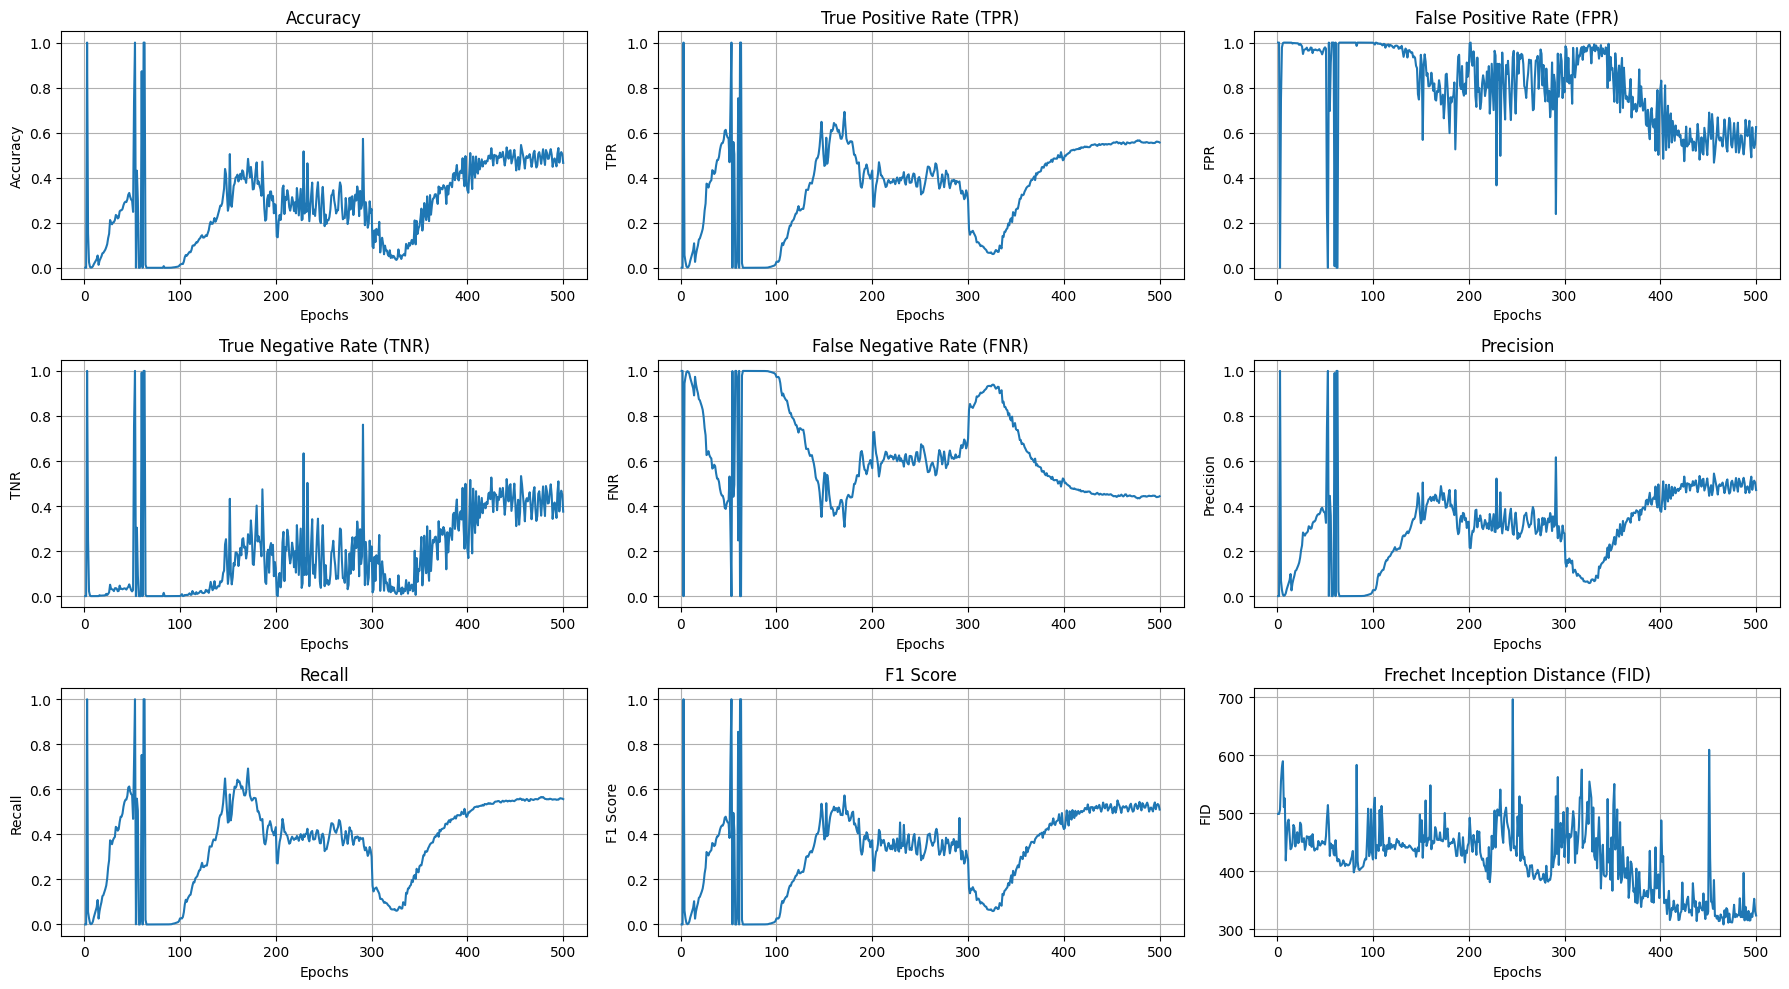

In [8]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torchmetrics.image.fid import FrechetInceptionDistance
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Create directories
save_dir = '/content/drive/MyDrive/model_checkpoints/'  # Change this to your desired directory
os.makedirs(save_dir, exist_ok=True)
directory = '/content/evaluation/'
if not os.path.exists(directory):
    os.makedirs(directory)  # Create the directory if it doesn't exist

# Calculate classification metrics for the discriminator
def calculate_classification_metrics(disc, gen, val_loader, device):
    gen.eval()
    disc.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)

            # Discriminator on real images
            # Assuming x is your input and y is the corresponding label for real images.
            batch_size = x.size(0)  # Dynamically get the current batch size

            # Discriminator on real images
            D_real = disc(x, y)
            real_preds = (torch.sigmoid(D_real) >= 0.5).cpu().numpy()  # Predictions for real images

            # Extend y_true with 1s for real images (1 = real)
            y_true.extend([1] * len(real_preds.flatten().tolist()))  # Ground truth for real images is 1
            y_pred.extend(real_preds.flatten().tolist())  # Extend predictions for real images

            # Generate fake images using the generator
            y_fake = gen(x)

            # Discriminator on fake images
            D_fake = disc(x, y_fake)
            fake_preds = (torch.sigmoid(D_fake) < 0.5).cpu().numpy()  # Predictions for fake images

            # Extend y_true with 0s for fake images (0 = fake)
            y_true.extend([0] * len(real_preds.flatten().tolist()))  # Ground truth for fake images is 0
            y_pred.extend(fake_preds.flatten().tolist())  # Extend predictions for fake images

    # Convert to numpy arrays for metrics
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print(f"y_true size: {(y_true.shape)}, y_pred size: {(y_pred.shape)}")  # Check sizes here


    # Confusion matrix elements
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # True Positive Rate (TPR)
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0

    # False Positive Rate (FPR)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    # True Negative Rate (TNR)
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

    # False Negative Rate (FNR)
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    # Precision
    precision = precision_score(y_true, y_pred)

    # Recall (equivalent to TPR)
    recall = recall_score(y_true, y_pred)

    # F1 Score
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}, TPR: {tpr:.4f}, FPR: {fpr:.4f}, TNR: {tnr:.4f}, FNR: {fnr:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    return accuracy, tpr, fpr, tnr, fnr, precision, recall, f1

# FID Calculation (using torchmetrics)
def calculate_fid(gen, val_loader, device, fid):
    gen.eval()
    fid.reset()  # Reset FID metric before calculation
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y_fake = gen(x)
            y_fake_tensor = y_fake.cpu().float()
            y_real_tensor = y.cpu().float()

            # Update FID with real and fake images
            fid.update(y_fake_tensor, real=False)
            fid.update(y_real_tensor, real=True)

    fid_score = fid.compute().item()  # Compute FID score
    print(f"FID: {fid_score}")
    return fid_score

# PSNR calculation
def calculate_psnr(gen, val_loader, device):
    gen.eval()
    total_psnr = 0.0
    num_batches = 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            y_fake = gen(x)

            mse = torch.mean((y - y_fake) ** 2)
            if mse == 0:
                psnr = 100
            else:
                psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))

            total_psnr += psnr.item()
            num_batches += 1

    avg_psnr = total_psnr / num_batches
    print(f"PSNR: {avg_psnr:.4f}")
    return avg_psnr

# Plot metrics
def plot_metrics(metrics, num_epochs):
    epochs = list(range(1, num_epochs + 1))

    plt.figure(figsize=(18, 10))

    # Accuracy plot
    plt.subplot(3, 3, 1)
    plt.plot(epochs, metrics['accuracy'], label="Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)

    # TPR plot
    plt.subplot(3, 3, 2)
    plt.plot(epochs, metrics['tpr'], label="TPR")
    plt.title("True Positive Rate (TPR)")
    plt.xlabel("Epochs")
    plt.ylabel("TPR")
    plt.grid(True)

    # FPR plot
    plt.subplot(3, 3, 3)
    plt.plot(epochs, metrics['fpr'], label="FPR")
    plt.title("False Positive Rate (FPR)")
    plt.xlabel("Epochs")
    plt.ylabel("FPR")
    plt.grid(True)

    # TNR plot
    plt.subplot(3, 3, 4)
    plt.plot(epochs, metrics['tnr'], label="TNR")
    plt.title("True Negative Rate (TNR)")
    plt.xlabel("Epochs")
    plt.ylabel("TNR")
    plt.grid(True)

    # FNR plot
    plt.subplot(3, 3, 5)
    plt.plot(epochs, metrics['fnr'], label="FNR")
    plt.title("False Negative Rate (FNR)")
    plt.xlabel("Epochs")
    plt.ylabel("FNR")
    plt.grid(True)

    # Precision plot
    plt.subplot(3, 3, 6)
    plt.plot(epochs, metrics['precision'], label="Precision")
    plt.title("Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.grid(True)

    # Recall plot
    plt.subplot(3, 3, 7)
    plt.plot(epochs, metrics['recall'], label="Recall")
    plt.title("Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.grid(True)

    # F1 Score plot
    plt.subplot(3, 3, 8)
    plt.plot(epochs, metrics['f1'], label="F1 Score")
    plt.title("F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.grid(True)

    # FID plot
    plt.subplot(3, 3, 9)
    plt.plot(epochs, metrics['fid'], label="FID")
    plt.title("Frechet Inception Distance (FID)")
    plt.xlabel("Epochs")
    plt.ylabel("FID")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Main function
def main():
    disc = Discriminator(in_channels=3).to(config.DEVICE)
    gen = Generator(in_channels=3, features=64).to(config.DEVICE)
    opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))
    opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    if config.LOAD_MODEL:
        load_checkpoint(config.CHECKPOINT_GEN, gen, opt_gen, config.LEARNING_RATE)
        load_checkpoint(config.CHECKPOINT_DISC, disc, opt_disc, config.LEARNING_RATE)

    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    # Initialize metric storage
    metrics = {
        'accuracy': [],
        'tpr': [],
        'fpr': [],
        'tnr': [],
        'fnr': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'fid': [],
        'psnr': []
    }

    # Initialize FID object from torchmetrics
    fid = FrechetInceptionDistance(normalize=True).to('cpu')
    for epoch in range(config.NUM_EPOCHS):
        train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)

        # Calculate metrics every epoch
        accuracy, tpr, fpr, tnr, fnr, precision, recall, f1 = calculate_classification_metrics(disc, gen, val_loader, config.DEVICE)
        fid_score = calculate_fid(gen, val_loader, config.DEVICE, fid)
        psnr_score = calculate_psnr(gen, val_loader, config.DEVICE)

        # Store metrics for plotting later
        metrics['accuracy'].append(accuracy)
        metrics['tpr'].append(tpr)
        metrics['fpr'].append(fpr)
        metrics['tnr'].append(tnr)
        metrics['fnr'].append(fnr)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1'].append(f1)
        metrics['fid'].append(fid_score)
        metrics['psnr'].append(psnr_score)

        print(f"Epoch {epoch} - Metrics: Accuracy: {accuracy:.4f}, TPR: {tpr:.4f}, FPR: {fpr:.4f}, FID: {fid_score:.4f}, PSNR: {psnr_score:.4f}")

        # Save model checkpoints every 50 epochs
        if epoch % 50 == 49:
            print(f"Saving model at epoch {epoch}")
            torch.save({
                'epoch': epoch,
                'generator_state_dict': gen.state_dict(),
                'optimizer_gen_state_dict': opt_gen.state_dict(),
            }, f"{save_dir}generator_epoch_{epoch}.pth")

            torch.save({
                'epoch': epoch,
                'discriminator_state_dict': disc.state_dict(),
                'optimizer_disc_state_dict': opt_disc.state_dict(),
            }, f"{save_dir}discriminator_epoch_{epoch}.pth")

            save_some_examples(gen, val_loader, epoch, folder="evaluation")

    # Plot metrics after training is complete
    plot_metrics(metrics, config.NUM_EPOCHS)


if __name__ == "__main__":
    main()
